In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from IPython.display import display, Math
plt.rcParams['figure.max_open_warning'] = 200

In [2]:
t_unit = "s"
v_unit = "mVpp"
T_unit = "K"
f_unit = "Hz"

In [3]:
# # Definition of the function to fit # #
# # Linear as we are doing logarithimc scale # #
def f(x,a,b):
    res = a-x/b
    return res

### User Functions [open only if needed; too much code :) ]

In [109]:
# # Definition of the function to add incertity depending on the scale of the aparata # #
def error(value):
    sensibility_error = 0
    if value < 1000 and value >= 100:
      sensibility_error = 0.001/m.sqrt(12)
    if value < 100 and value >= 10:
      sensibility_error = 0.0001/m.sqrt(12)
    if value < 10 and value >= 1:
      sensibility_error = 0.00001/m.sqrt(12)
    if value < 1 and value >= 0.1:
      sensibility_error = 0.000001/m.sqrt(12)
    reading_error = 0.0292*value #2.92% of the value
    scale_error = 0.00025*10**3
    err = m.sqrt( (sensibility_error)**2 + (reading_error)**2 + (scale_error)**2 )
    return err


def chidof(obs, exp, sigma, dof):
    obs_arr = np.array(obs)
    exp_arr = np.array(exp)
    sigma_arr = np.array(sigma)
    return sum((obs_arr - exp_arr)**2/sigma_arr**2) / dof


def fitandplot(path, filename, f, initial, plot, entire):
    file = pd.ExcelFile(path+filename)
    sheets = file.sheet_names
    data = pd.read_excel(path+filename, sheet_name=None)
    
    Q = []
    errQ = []
    chisq = []
    Q1 = []
    errQ1 = []
    Q2 = []
    errQ2 = []
    T_mean = []
    errT = []
    chisq1 = []
    chisq2 = []

    for sheet in sheets:
        v = np.array(data[sheet]['Voltage'])    # Gets v
        v_error = [error(val)/val for val in v] # Calculate the error of log(v)
        v = np.log(v)                           # Calculates log(v)
        
        vlh = 4                                 # How many points in the first set
        v1 = v[:vlh]
        v2 = v[vlh:]
        v1_error = v_error[:vlh]
        v2_error = v_error[vlh:]
        

        
        t = np.array(data[sheet]['Time'])
        t1 = t[:vlh]
        t2 = t[vlh:]

        T = np.array(data[sheet]['T'])
        T_value = np.mean(np.array([T[0],T[1]]))
        T_error = abs(T[1]-T[0])/2

        f_0 = np.array(data[sheet]['f0'][0])
        errf_0 = 0.02

        t_unit = "s"
        v_unit = "mVpp"
        T_unit = "K"
        f_unit = "Hz"

        if entire == True:
            resval,rescov = curve_fit(f, t, v, initial, sigma = v_error)
            reserr = np.sqrt(np.diag(rescov))
            dof = len(v) - len(initial)
            chi_norm = chidof(v, f(t,*resval), v_error, dof)
            Q_value = f_0*resval[1]*m.pi
            Q_error = Q_value*m.sqrt( (reserr[1]/resval[1])**2 + (errf_0/f_0)**2 )
            Q.append(Q_value)
            errQ.append(Q_error)
            chisq.append(chi_norm)
            
        resval1,rescov1 = curve_fit(f, t1, v1, initial, sigma = v1_error)
        resval2,rescov2 = curve_fit(f, t2, v2, initial, sigma = v2_error)
        
        reserr1 = np.sqrt(np.diag(rescov1))
        reserr2 = np.sqrt(np.diag(rescov2))
        
        dof1 = len(v1) - len(initial)
        dof2 = len(v2) - len(initial)
        
        chi_norm1 = chidof(v1, f(t1,*resval1), v1_error, dof1)
        chi_norm2 = chidof(v2, f(t2,*resval2), v2_error, dof2)

        # # Calculus of the Q-value # #
        Q_value1 = f_0*resval1[1]*m.pi
        Q_error1 = Q_value1*m.sqrt( (reserr1[1]/resval1[1])**2 + (errf_0/f_0)**2 )
        
        Q_value2 = f_0*resval2[1]*m.pi
        Q_error2 = Q_value2*m.sqrt( (reserr2[1]/resval2[1])**2 + (errf_0/f_0)**2 )

        Q1.append(Q_value1)
        errQ1.append(Q_error1)
        chisq1.append(chi_norm1)
        
        Q2.append(Q_value2)
        errQ2.append(Q_error2)
        chisq2.append(chi_norm2)
        
        T_mean.append(T_value)
        errT.append(T_error)
        
        
        if plot == True :
            # # Plot of the data with fit # #
            #sampling time
            h = max([abs((max(t1)-min(t1))/100),1])
            fit_time1 = np.arange(min(t1), max(t1)+h, h)
            
            h = max([abs((max(t2)-min(t2))/100),1])
            fit_time2 = np.arange(min(t2), max(t2)+h, h)
            
            fit_amplitude1 = f(fit_time1,*resval1)
            fit_amplitude2 = f(fit_time2,*resval2)

            if entire == True:
                h = max([abs((max(t)-min(t))/100),1])
                fit_time = np.arange(min(t), max(t)+h, h)
                fit_amplitude = f(fit_time,*resval)
            
            fig = plt.figure(figsize=(6,4), dpi=100);
            fig.suptitle(r"Data from {0} of {1}".format(sheet, filename))
            plt.xlabel(r"$t$ ({0})".format(t_unit), size = 10)
            plt.ylabel(r"Logarithmic Amplitude $(\log({0}))$".format(v_unit), size = 10)
            plt.plot(t,v,'.',c='k', ms=6)
            plt.errorbar(t, v, yerr=v_error, fmt=".k", capsize=3,alpha = 0.65,label="Data")
            plt.plot(fit_time1,fit_amplitude1,'--',c='red',label="Fit of First points")
            plt.plot(fit_time2,fit_amplitude2,'--',c='blue',label="Fit of Last points")
            if entire == True:
                plt.plot(fit_time, fit_amplitude,'--',c='green',label="Fit of all points")

            text_entire =""
            if entire == True:
                text_entire ='\n'.join((
                r'Q = {0:.2f} $\pm$ {1:.2f}'.format(Q_value,Q_error),
                r'$\chi^2/dof$ = {0:.2f} ({1})'.format(chi_norm, dof)))

            textstr = '\n'.join((
            r'Q1 = {0:.2f} $\pm$ {1:.2f}'.format(Q_value1,Q_error1),
            r'Q2 = {0:.2f} $\pm$ {1:.2f}'.format(Q_value2,Q_error2),
            r'$\chi^2_1/dof_1$ = {0:.2f} ({1})'.format(chi_norm1, dof1),
            r'$\chi^2_2/dof_2$ = {0:.2f} ({1})'.format(chi_norm2, dof2),
            text_entire,
            r'T = {0:.2f} $\pm$ {1:.2f} $\mathrm{{{2}}}$'.format(T_value,T_error,T_unit),
            r'$f_0$ = {0:.2f} $\pm$ {1:.02f} $\mathrm{{{2}}}$'.format(f_0,errf_0,f_unit)))

            props = dict(boxstyle='square', facecolor='white', alpha=1)

            plt.text(0.85, 0.6, textstr, fontsize=10,
                    verticalalignment='top',transform=fig.transFigure, bbox=props)
            
            plt.legend()
            %config InlineBackend.figure_format='retina'
            plt.tight_layout()
            plt.grid()
            plt.show()

    return Q1,errQ1,Q2,errQ2,T_mean,errT,chisq1,chisq2

### Analysis

In [113]:
files = ["04_04", "06_04", "13_04", "14_04", "20_04", "21_04"]
extension = ".xlsx"
path = "data/"

In [114]:
data = []
for i in range(len(files)):
    data.append(pd.read_excel(path+files[i]+extension, sheet_name=None))

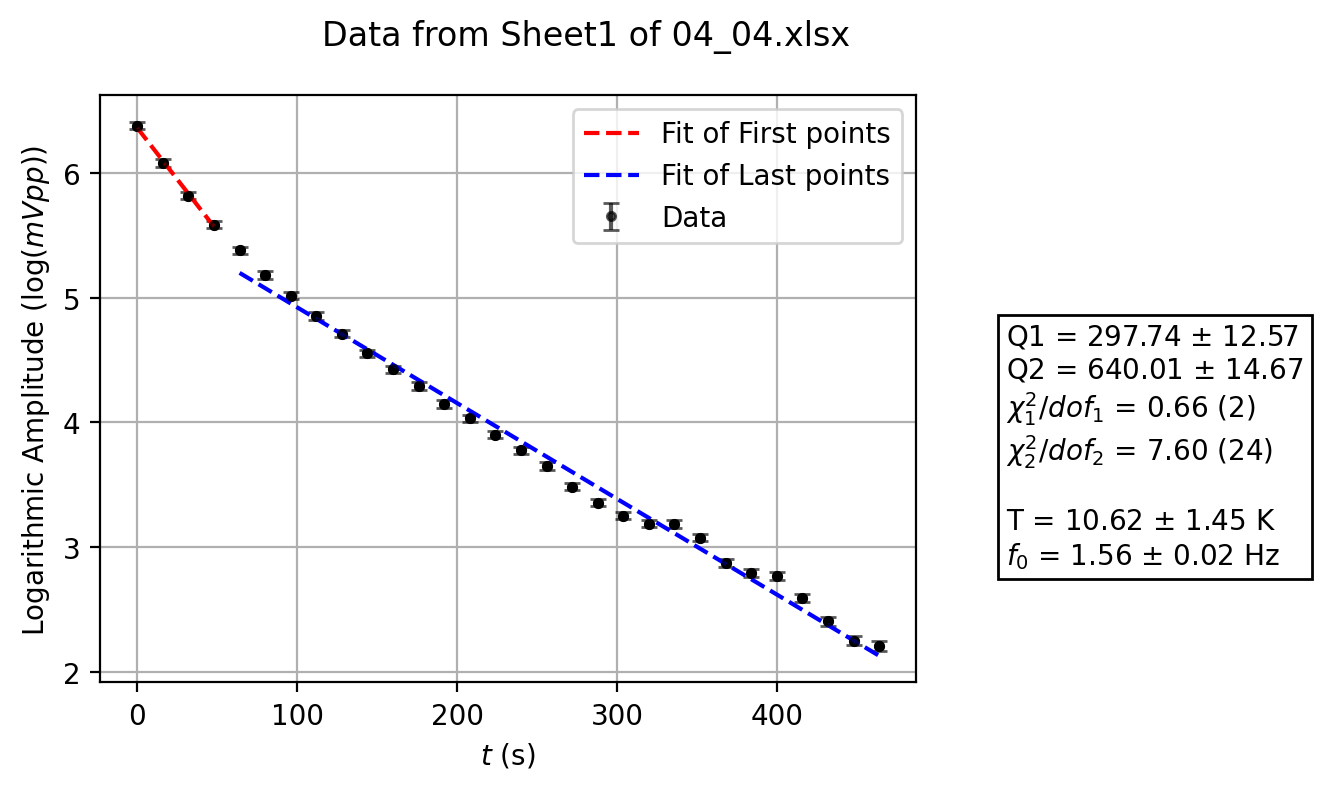

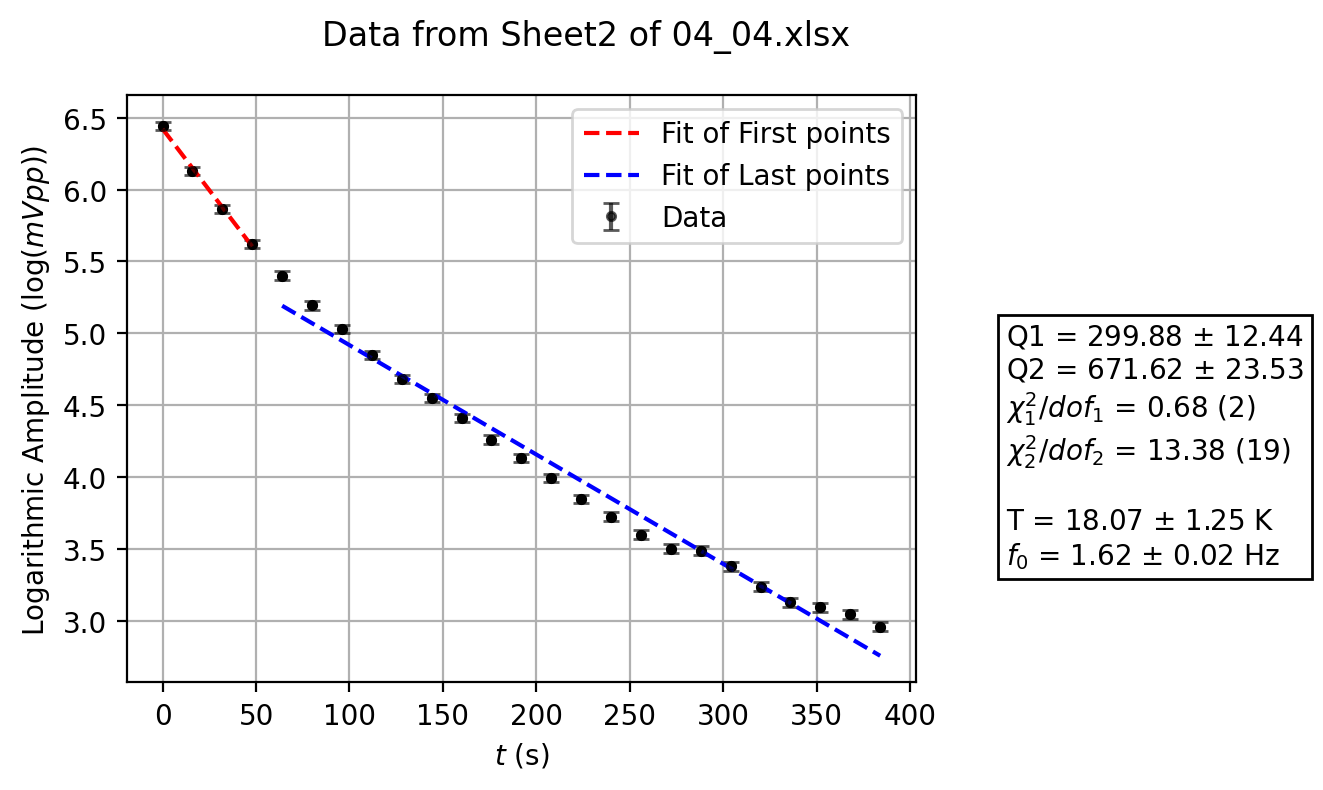

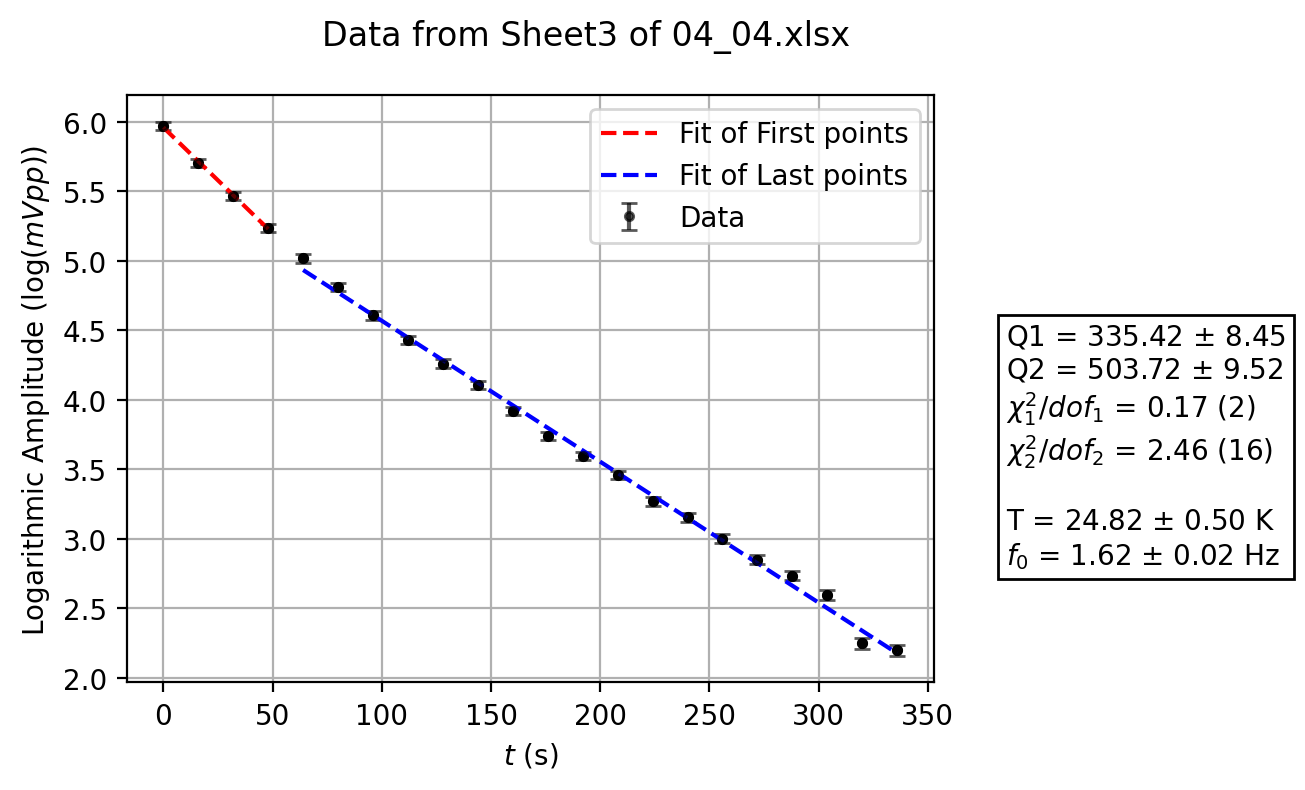

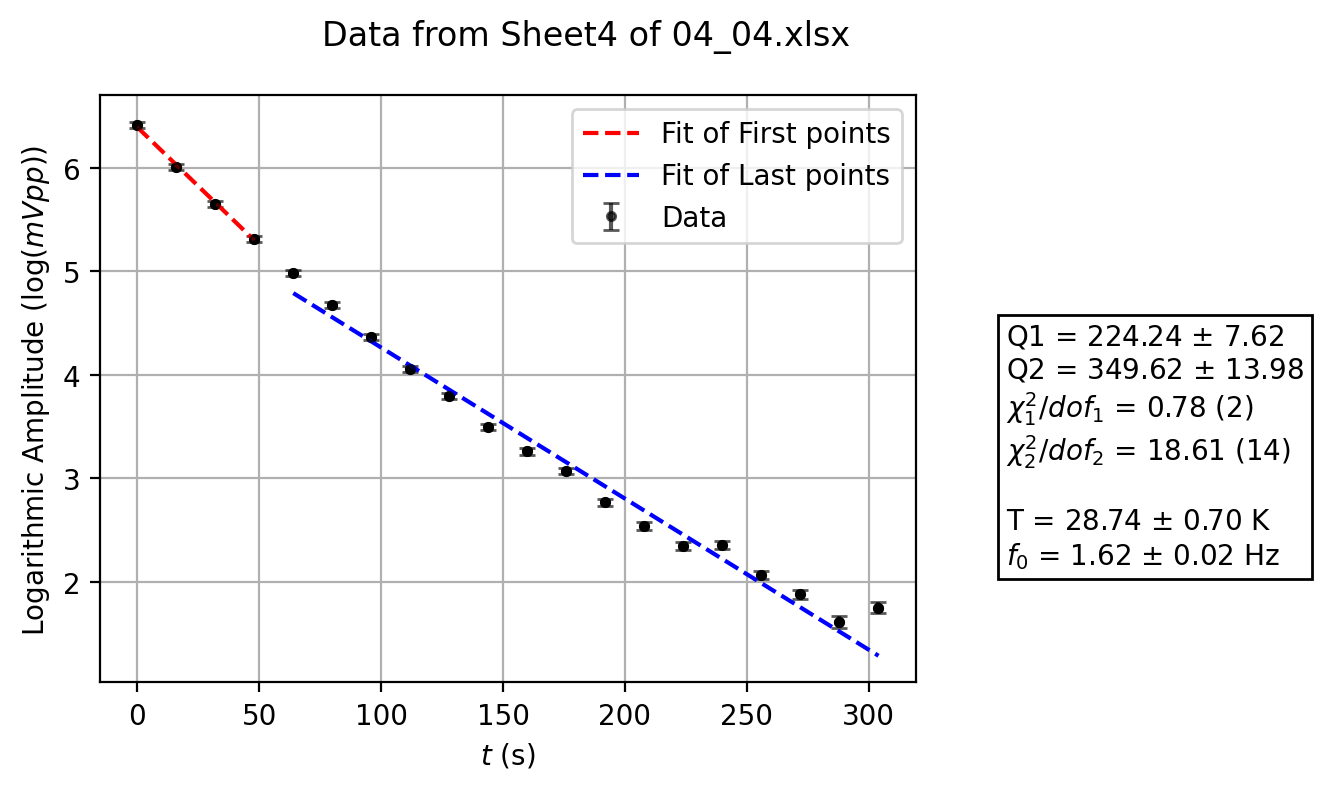

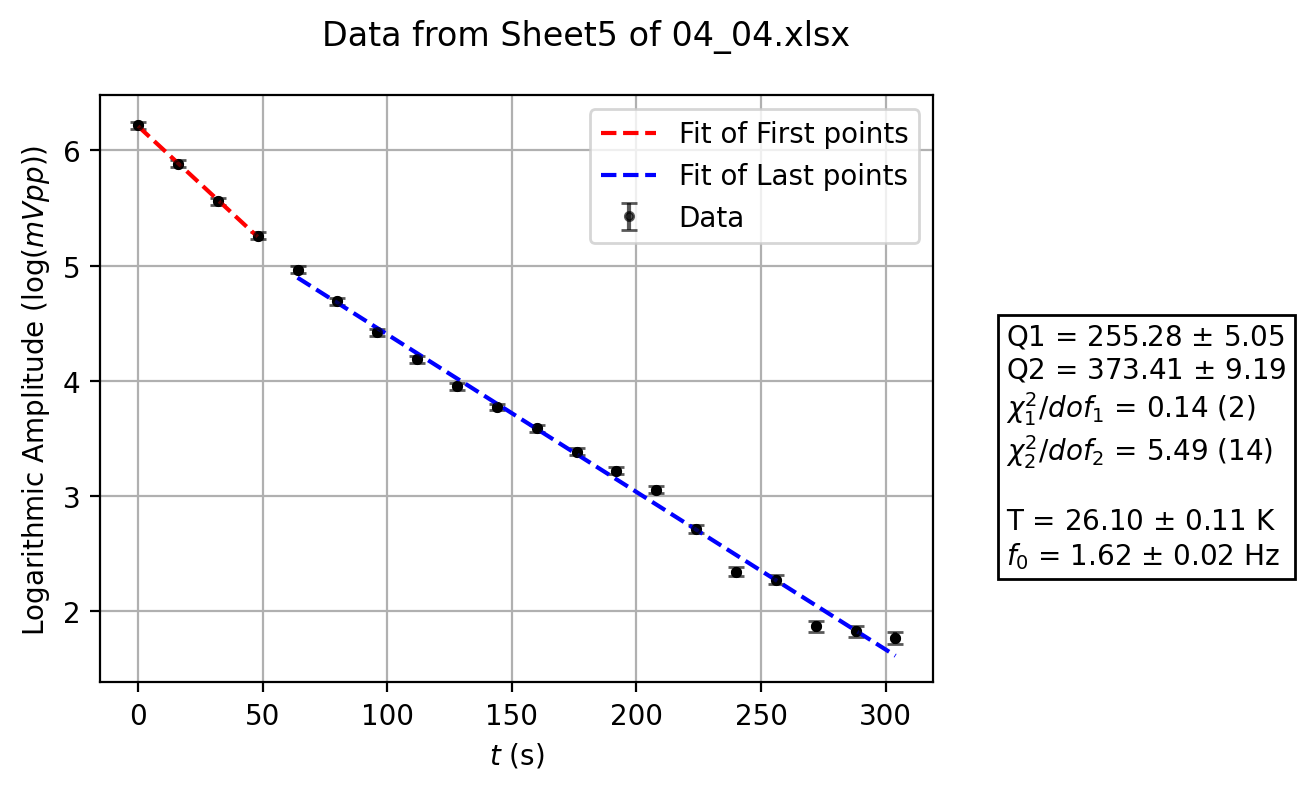

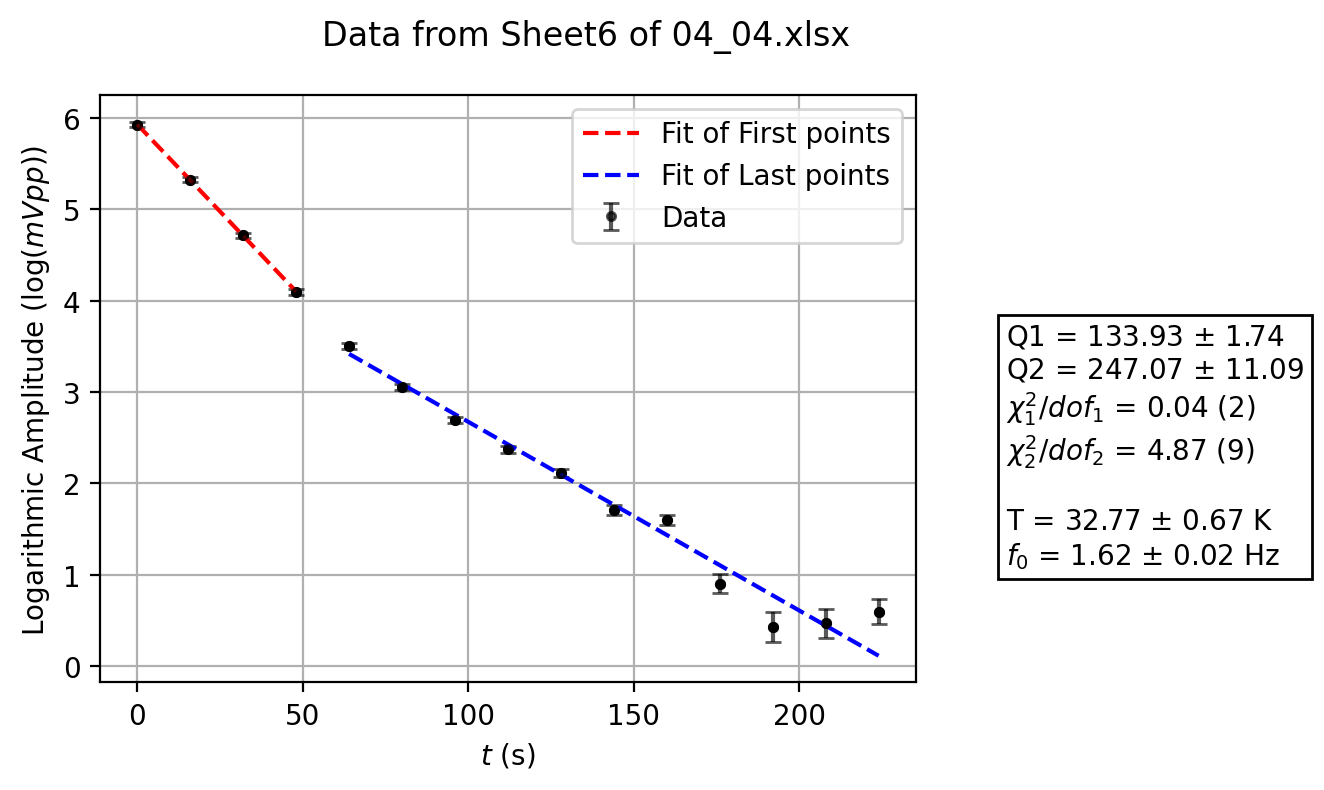

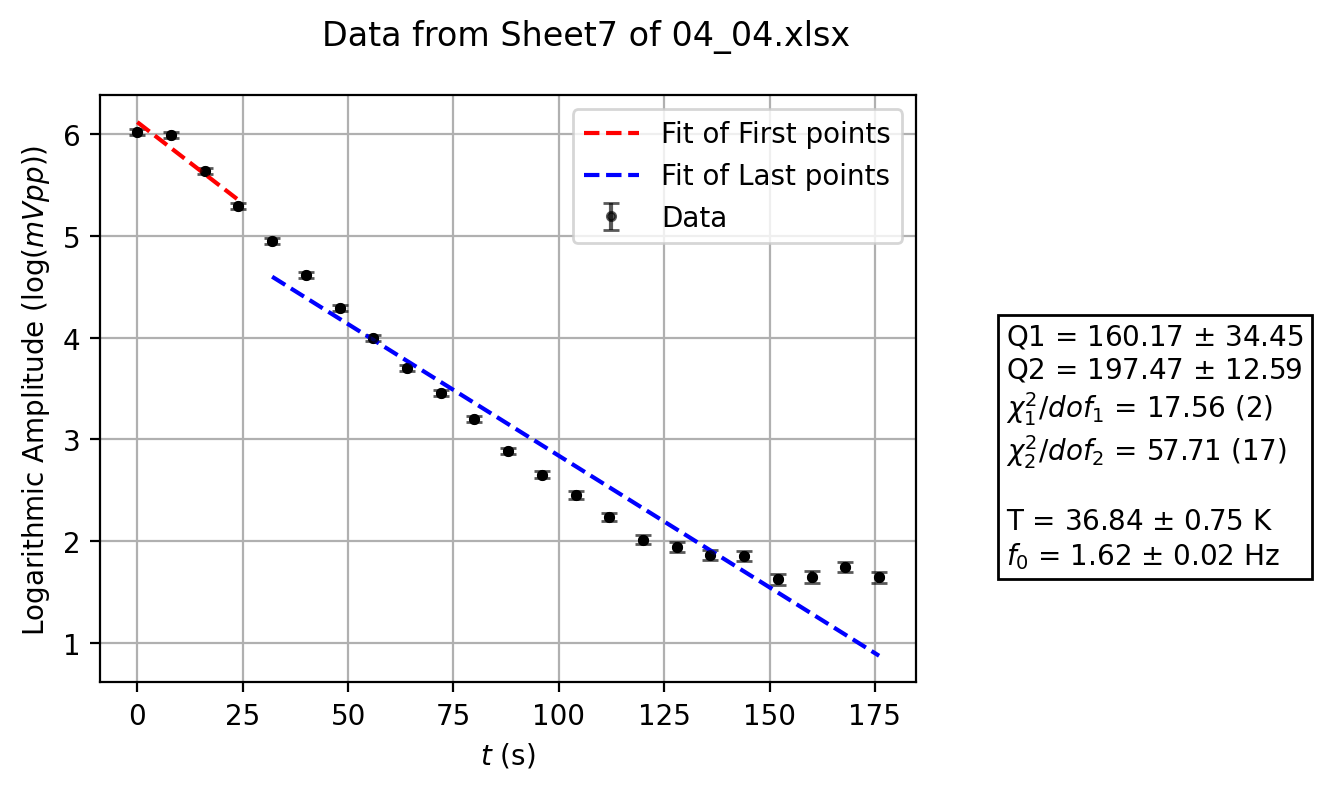

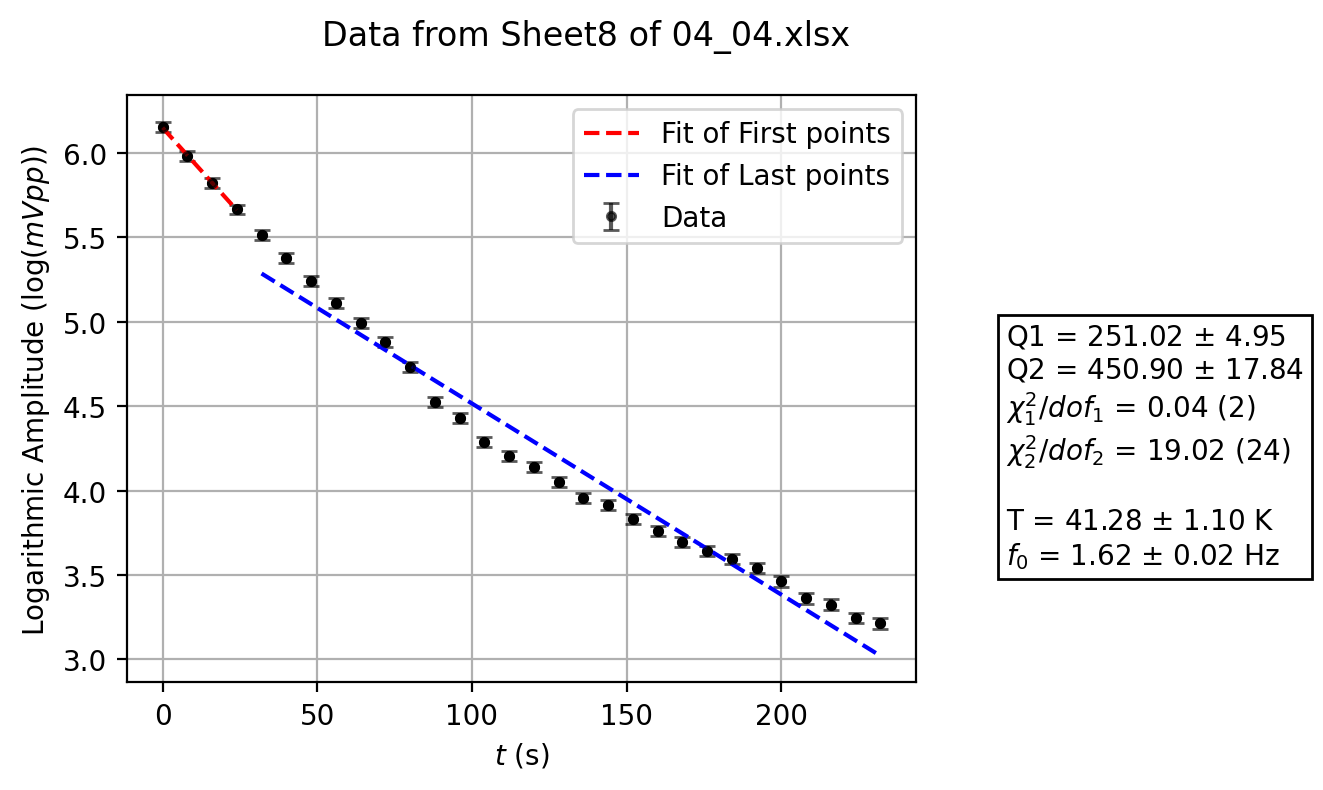

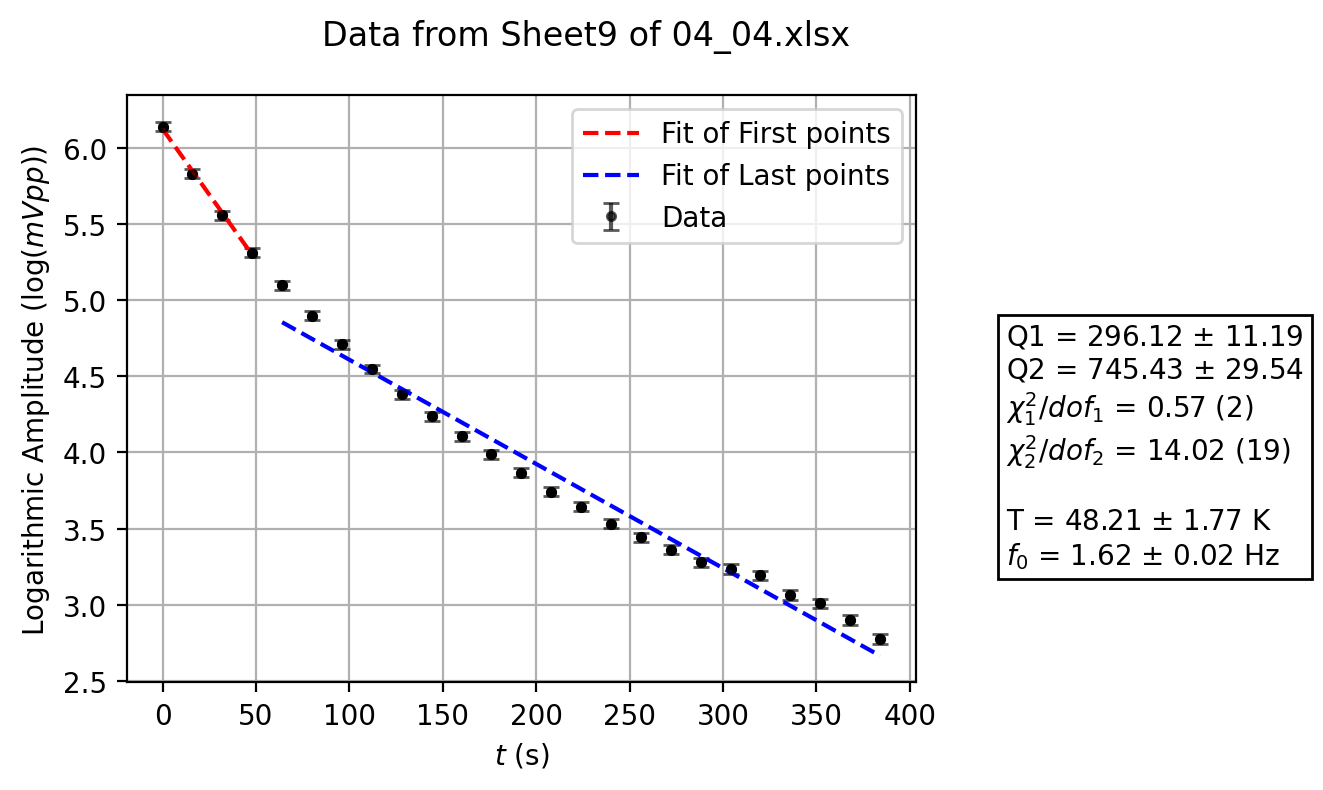

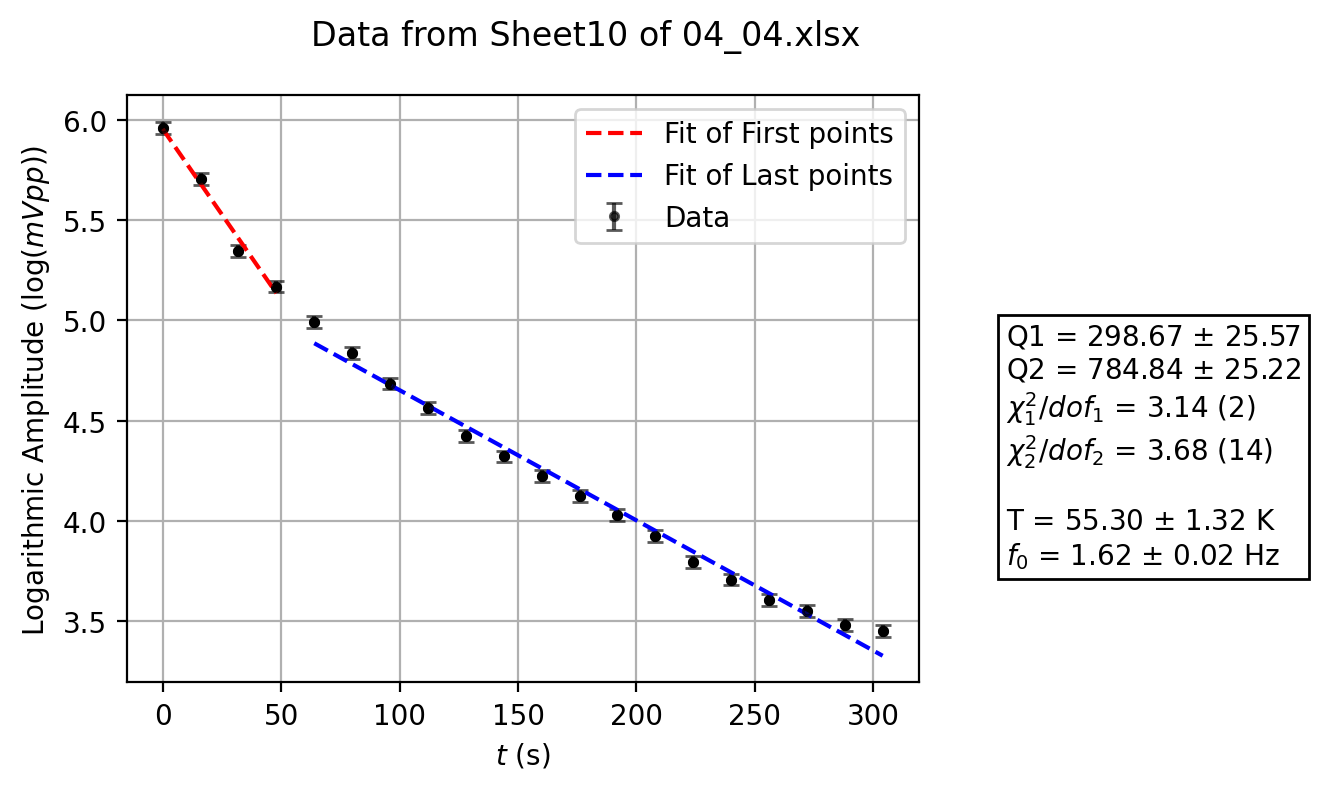

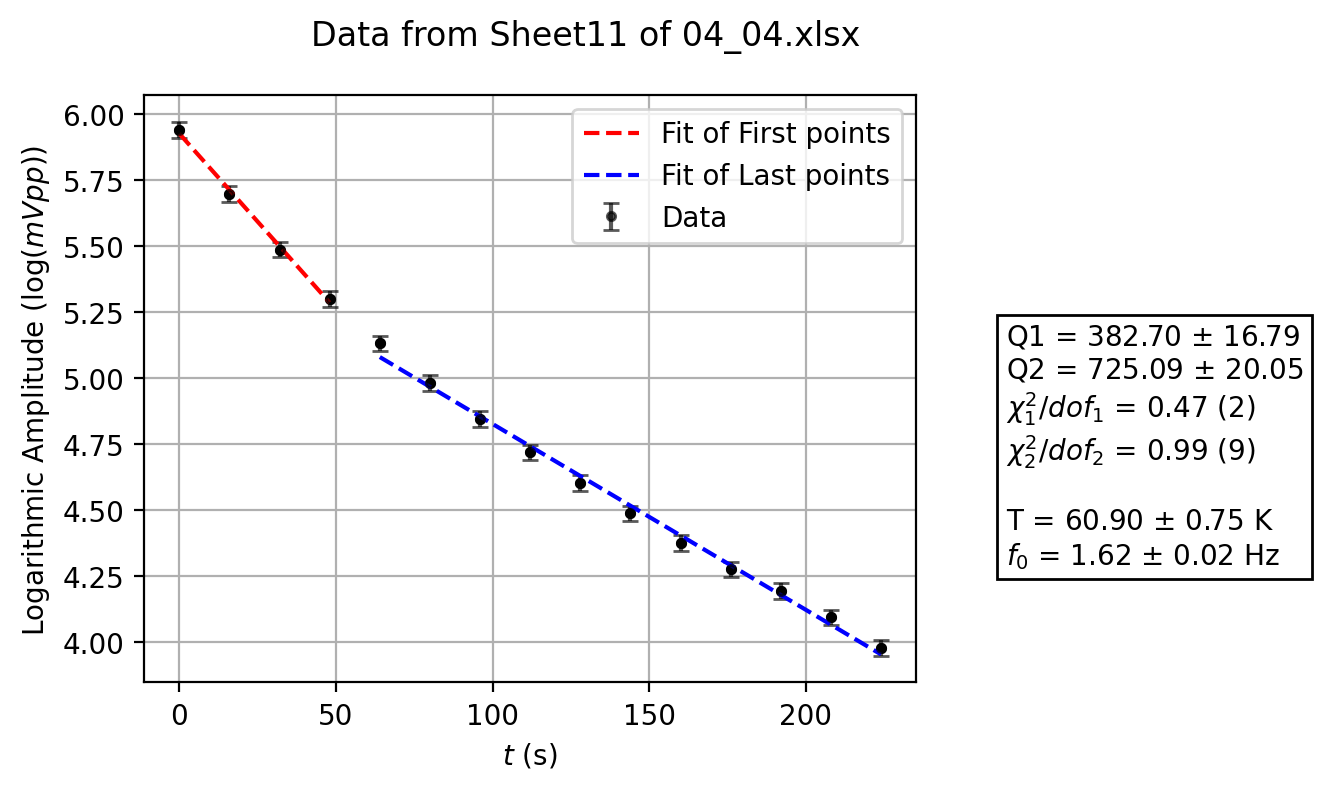

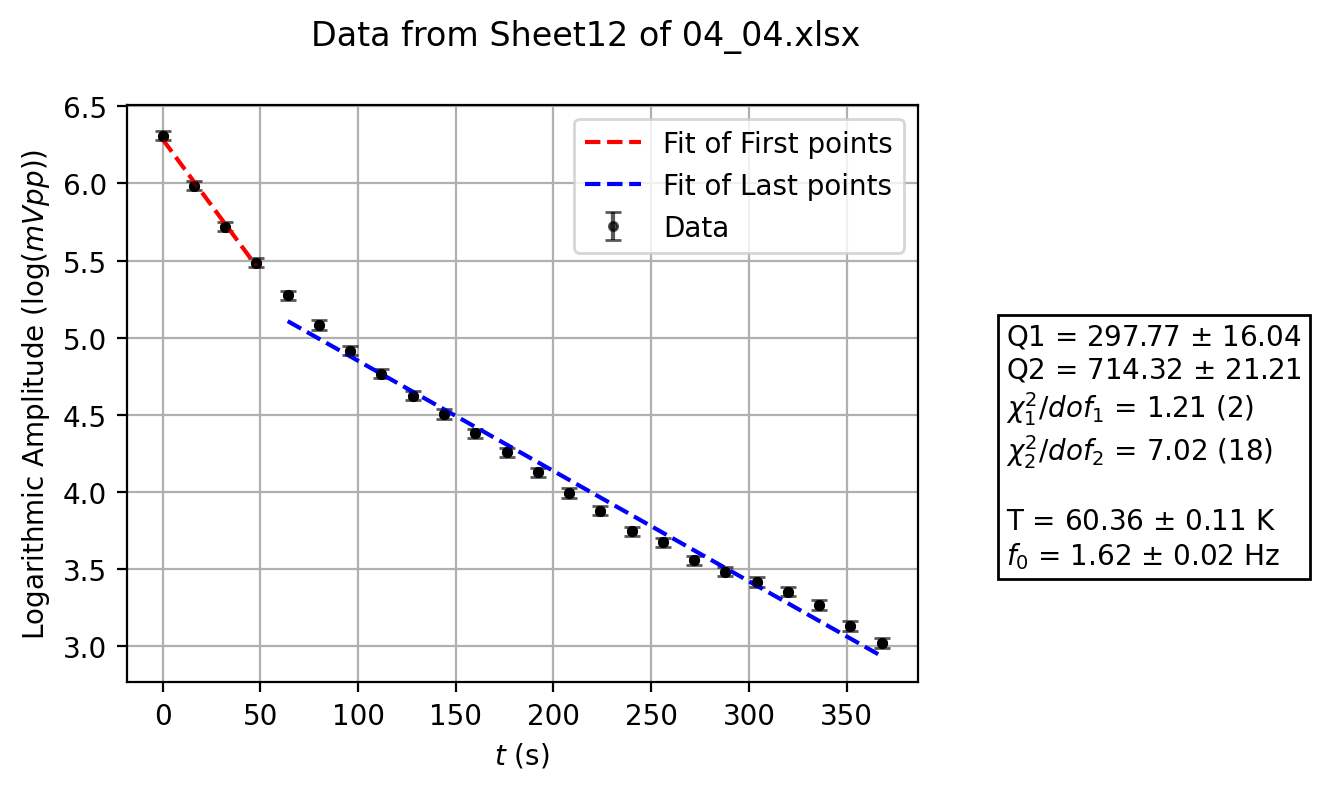

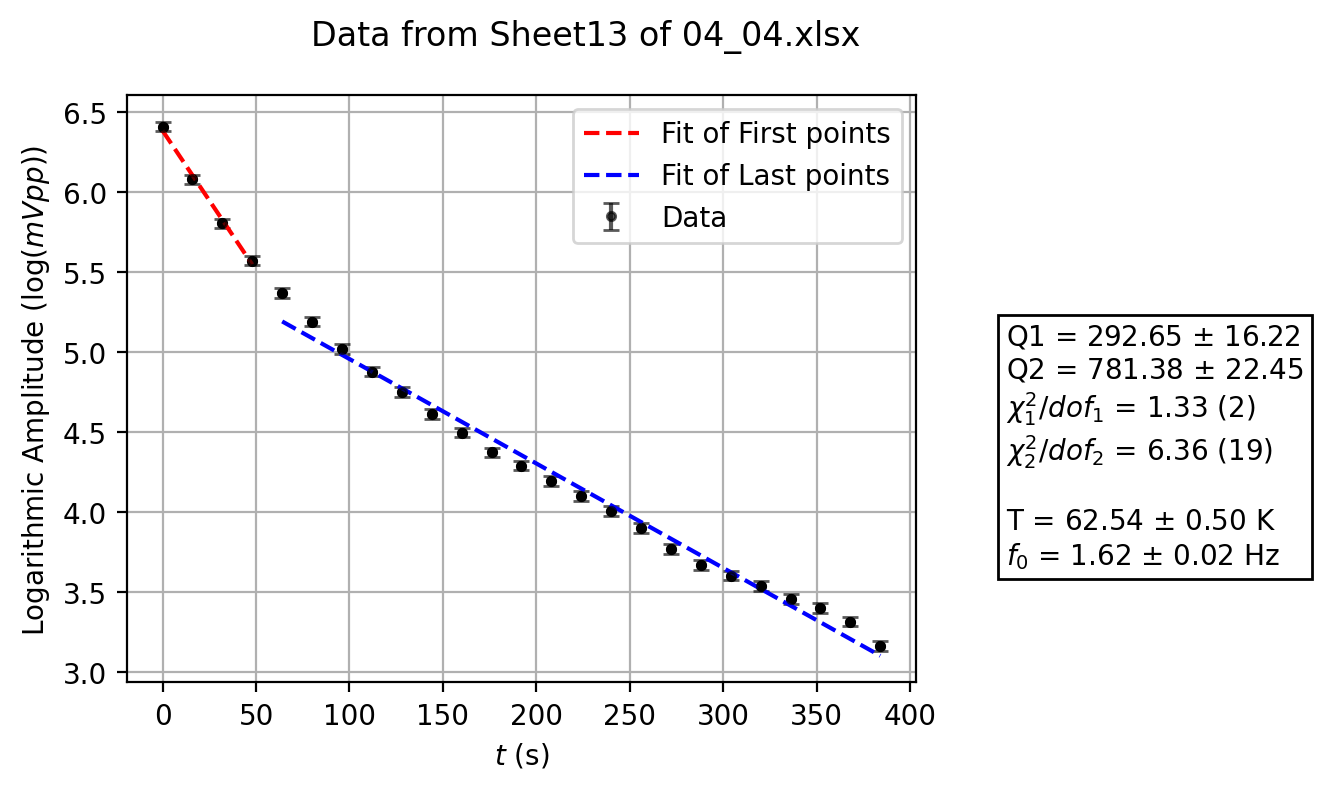

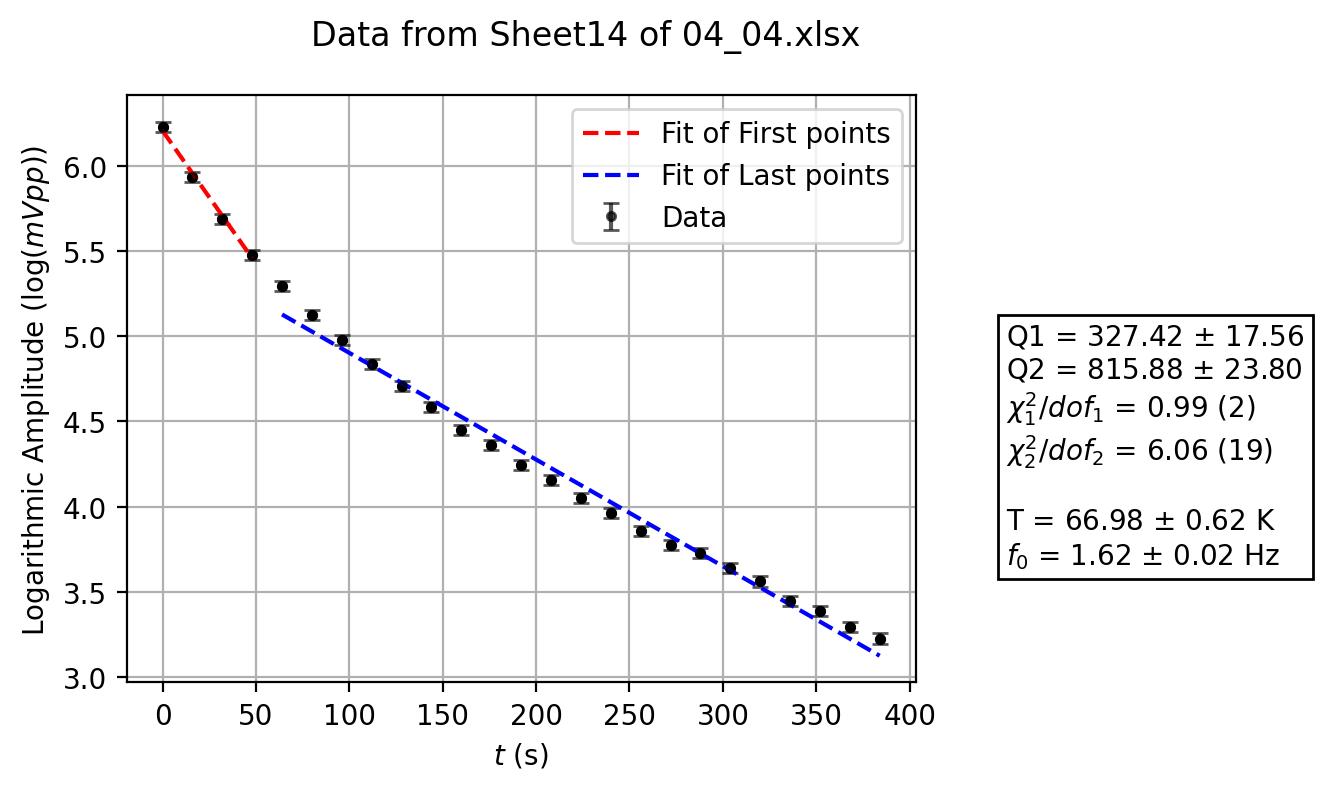

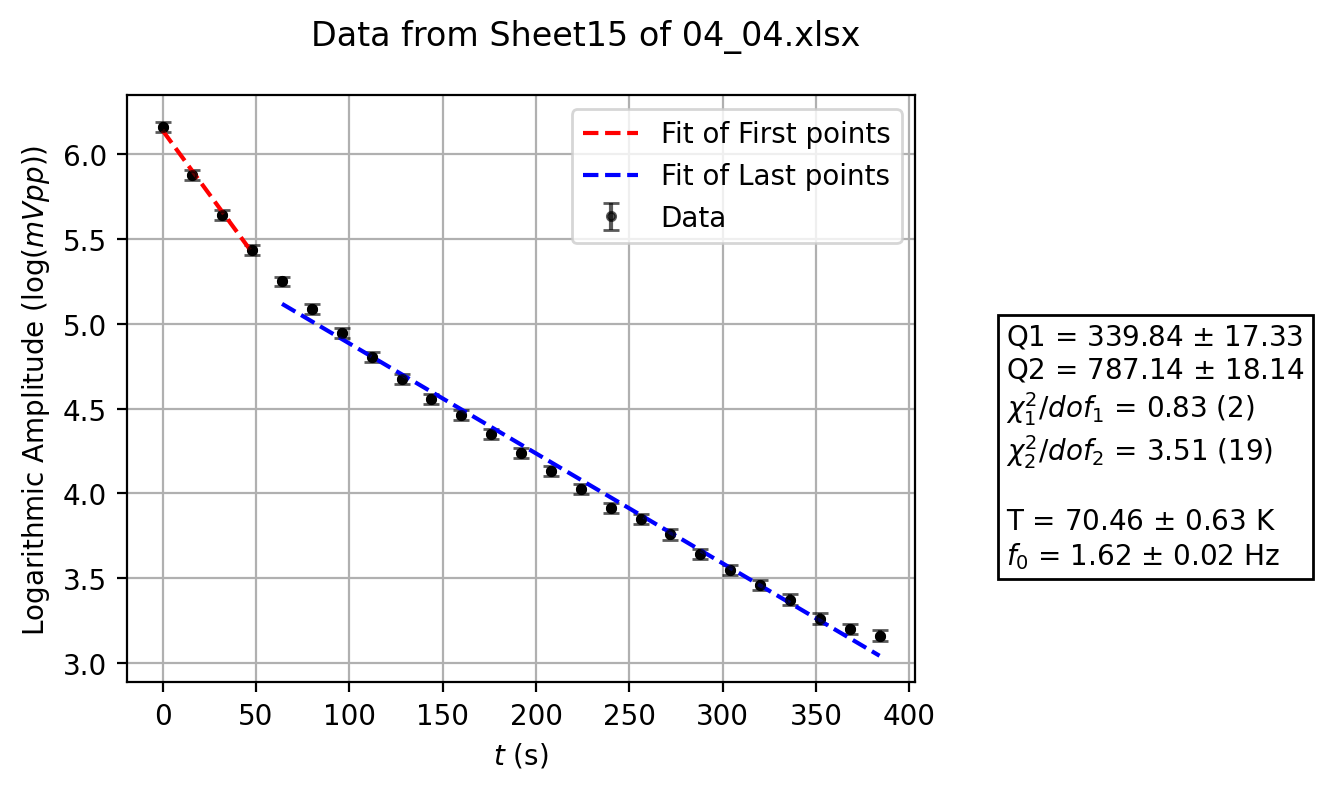

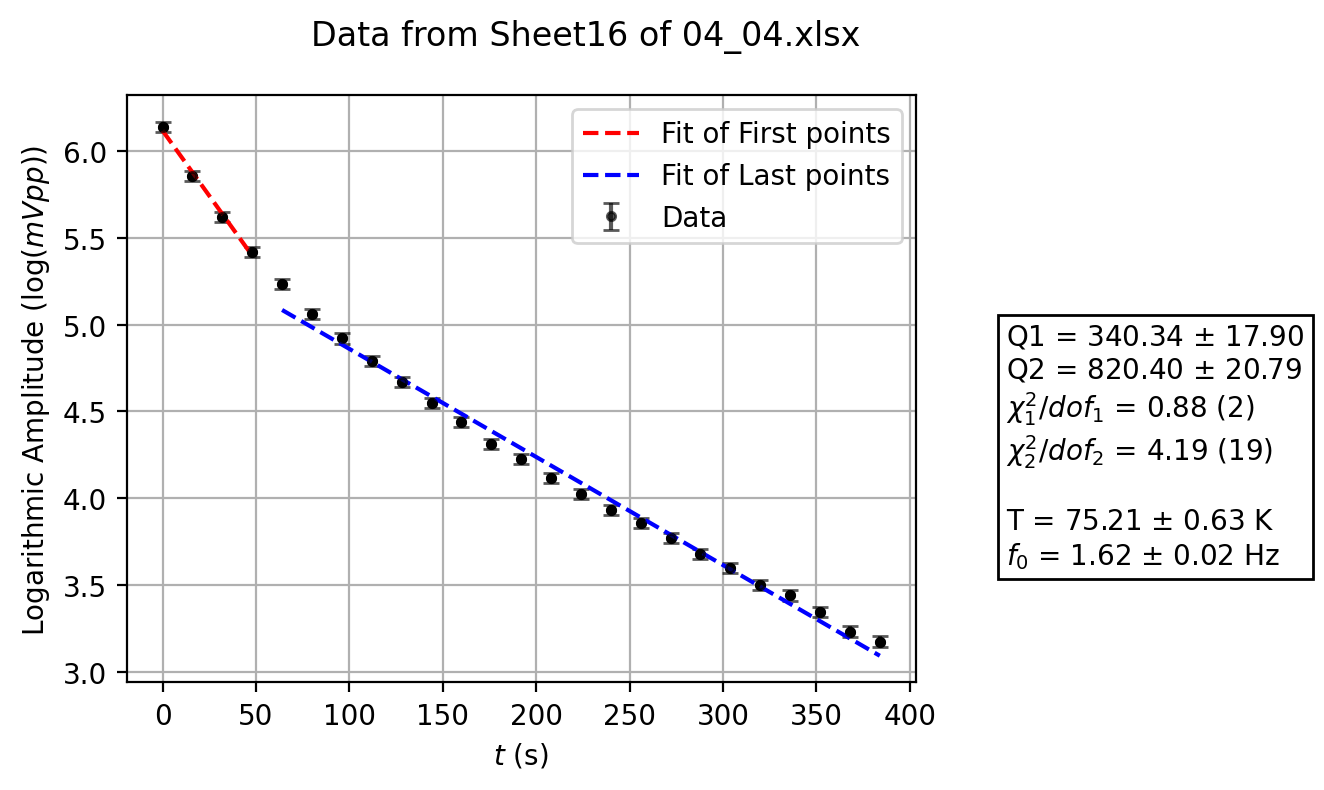

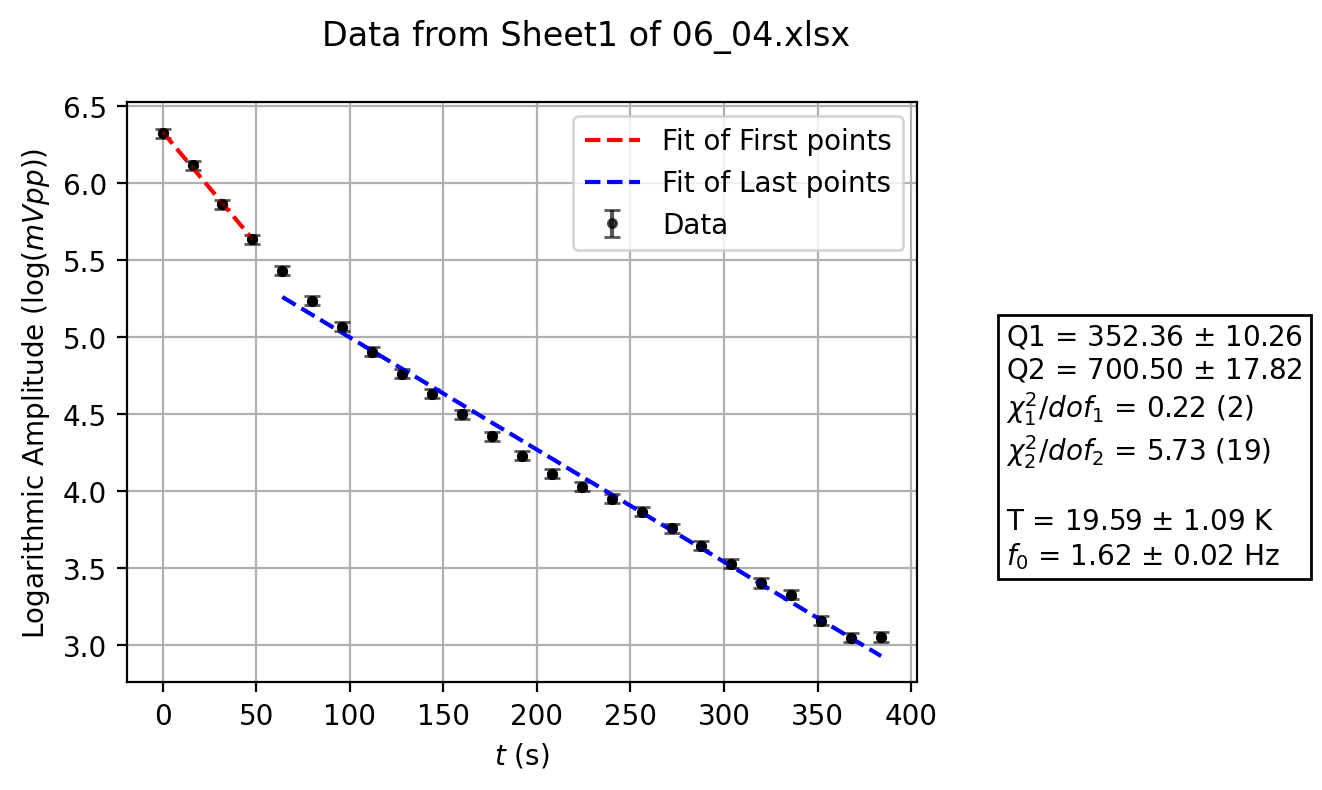

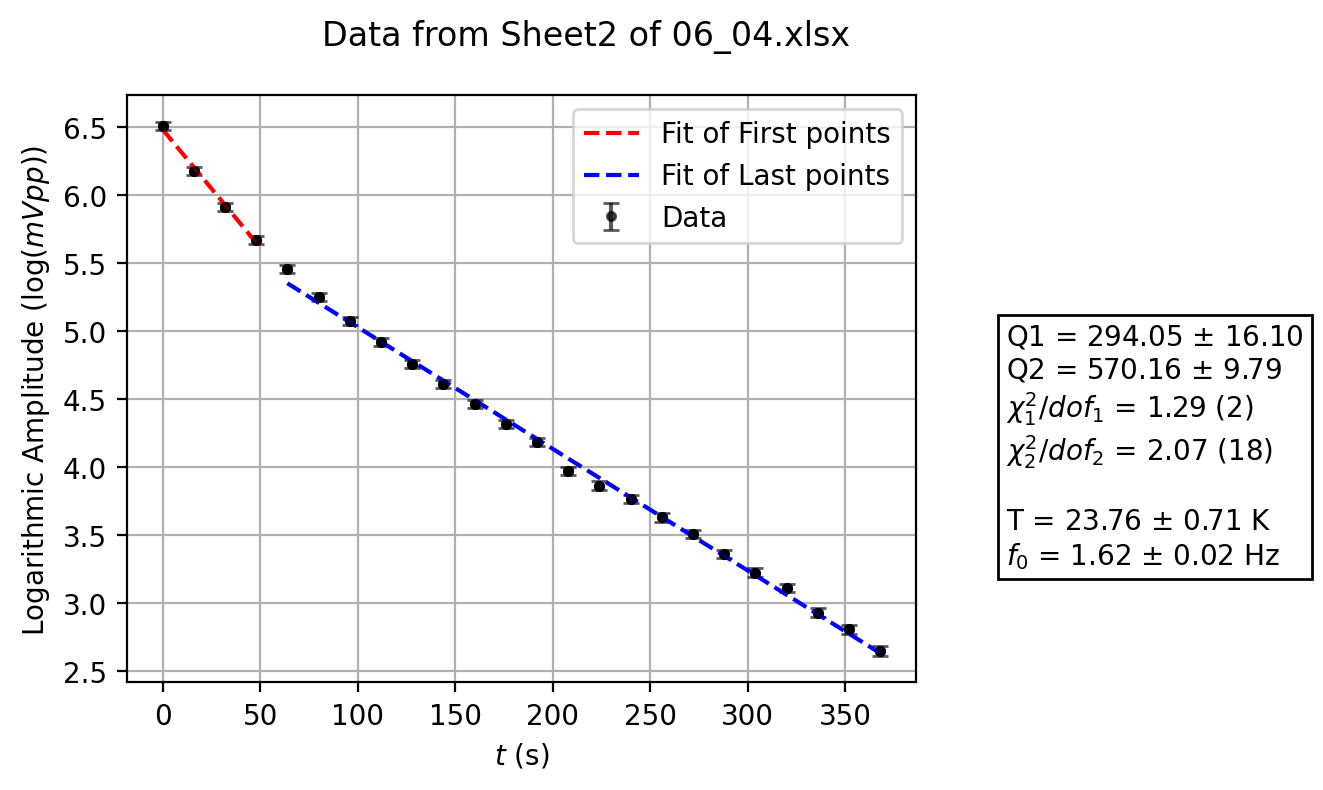

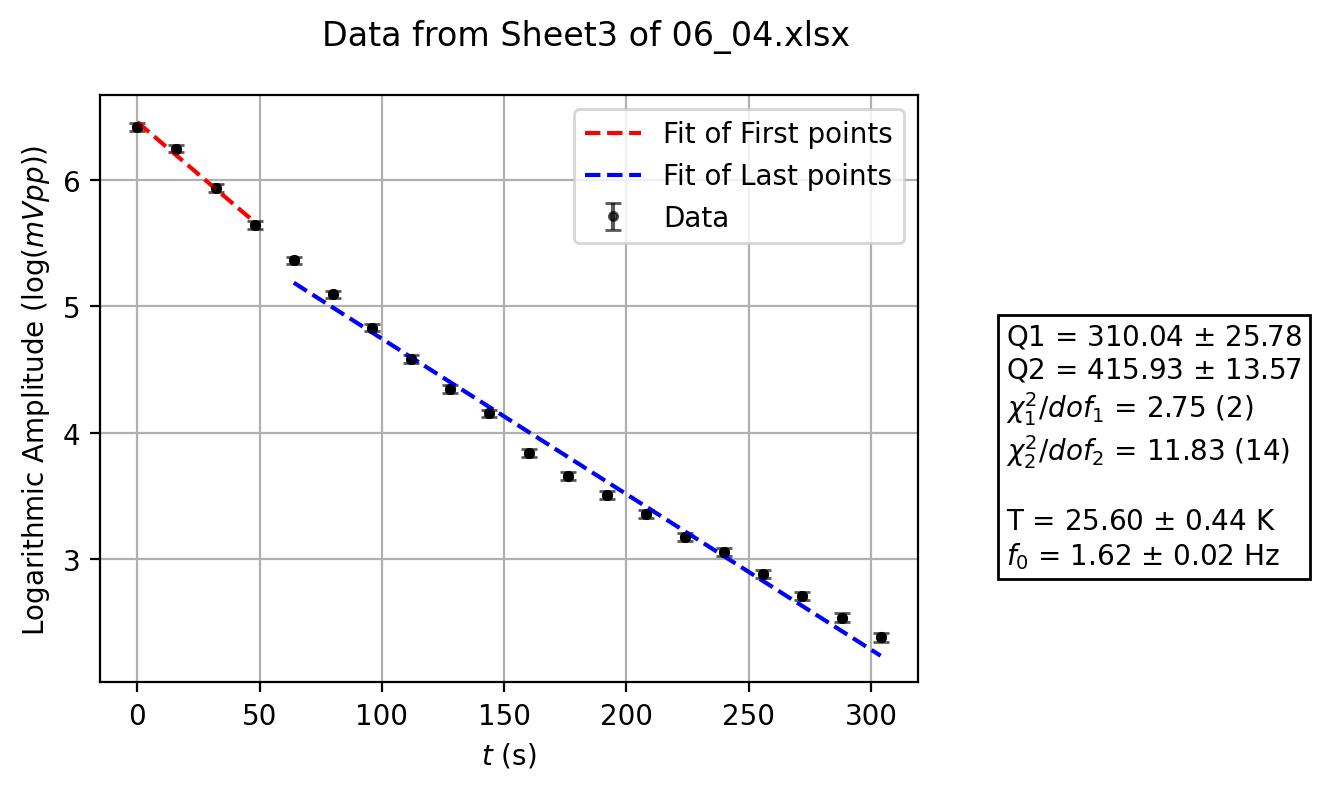

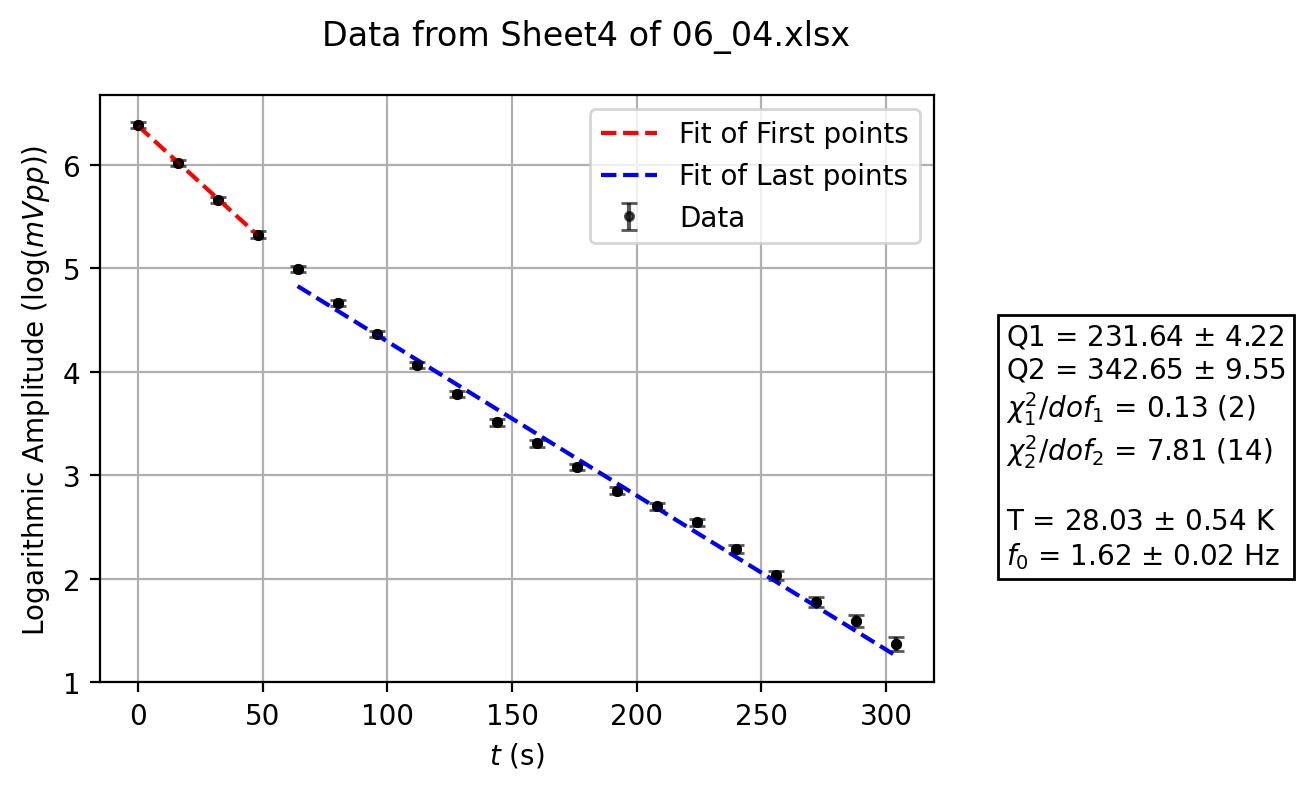

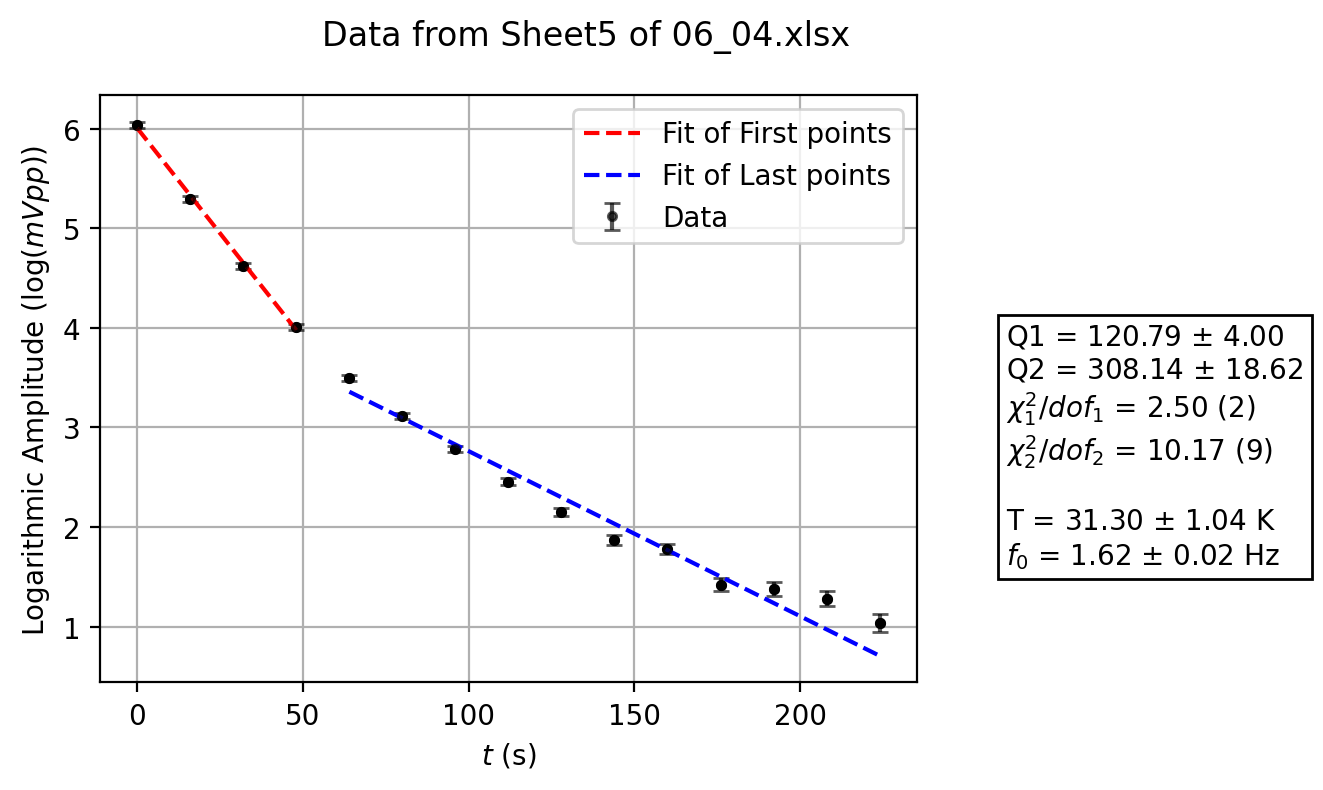

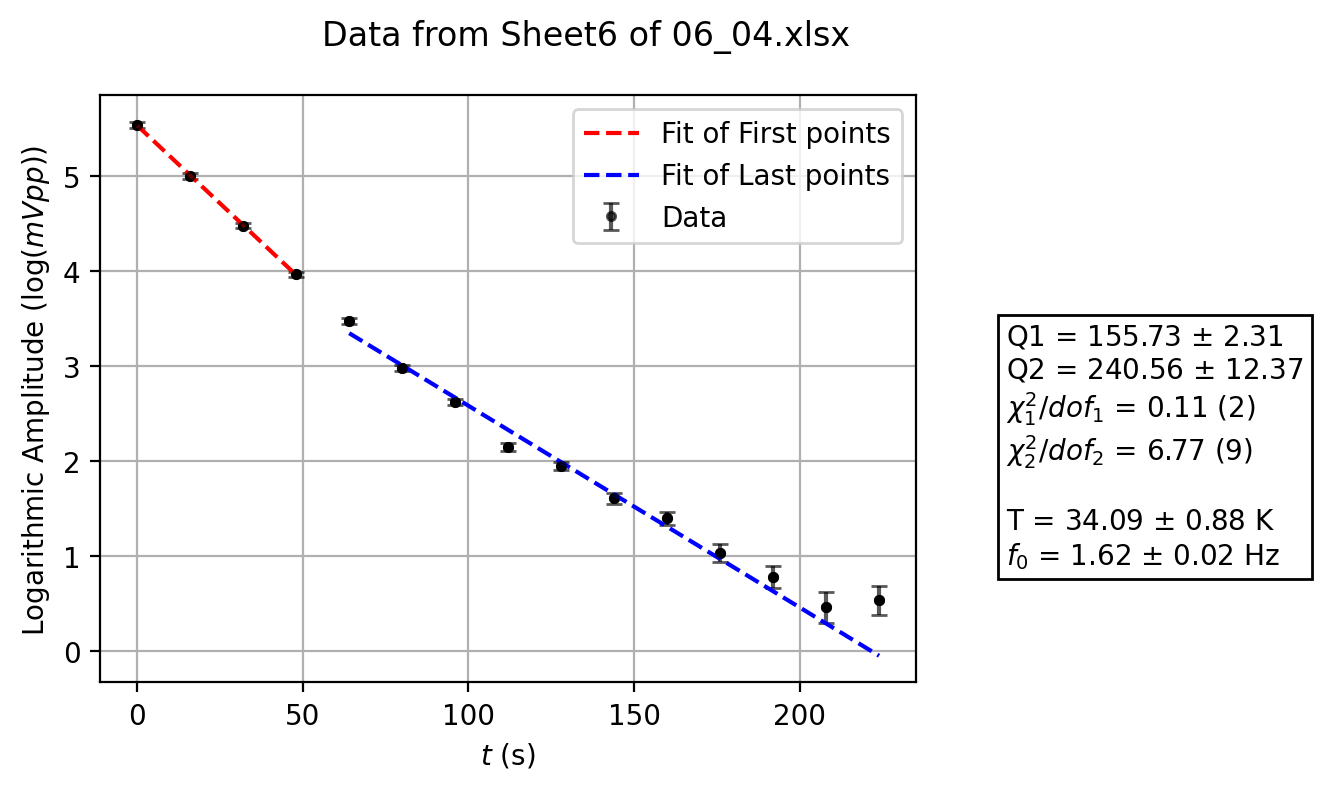

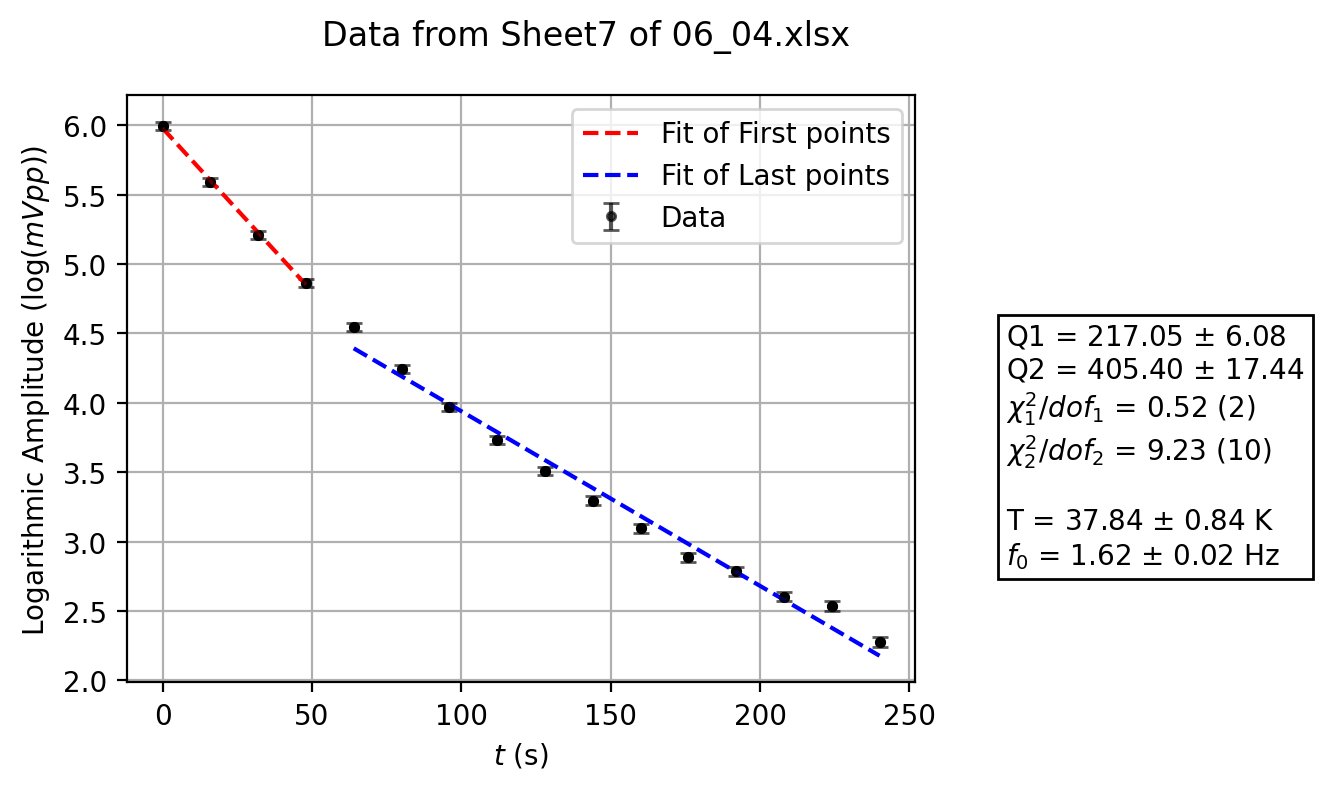

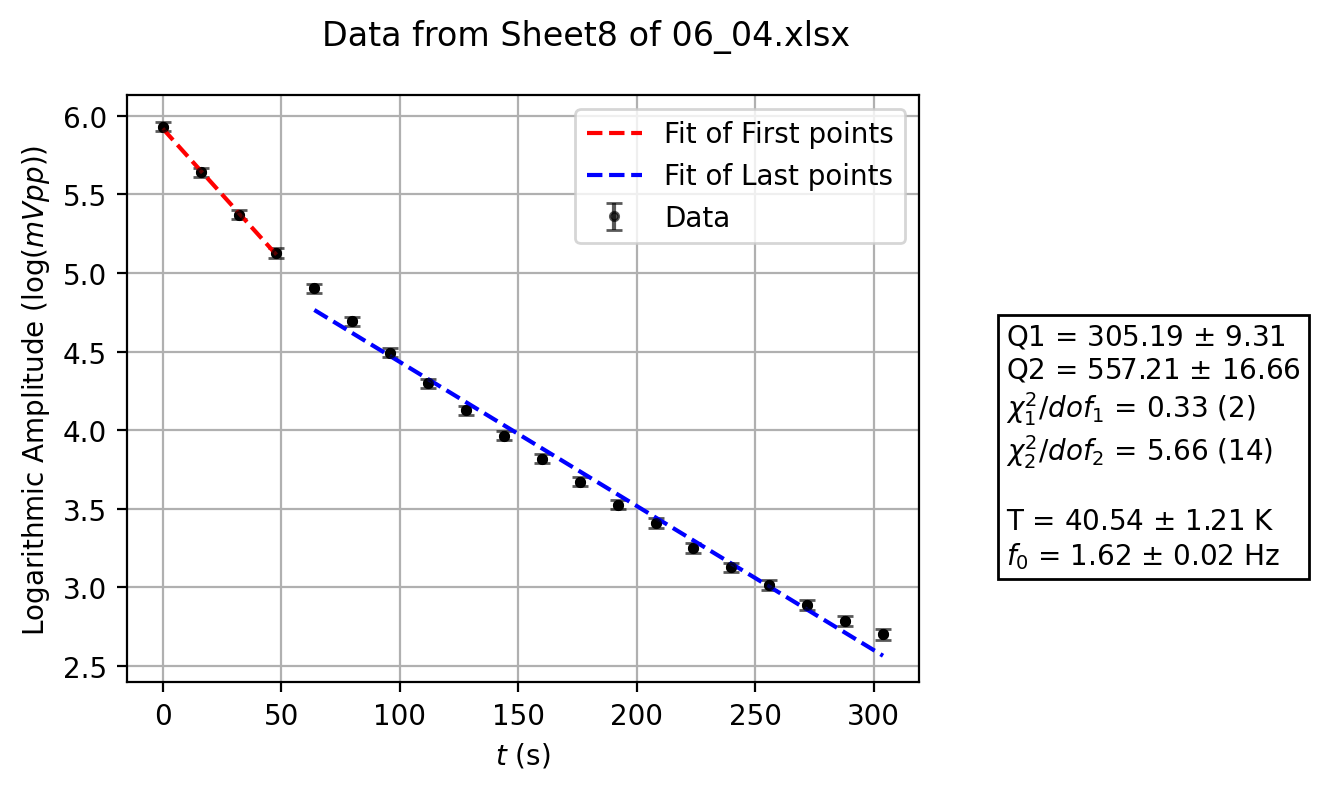

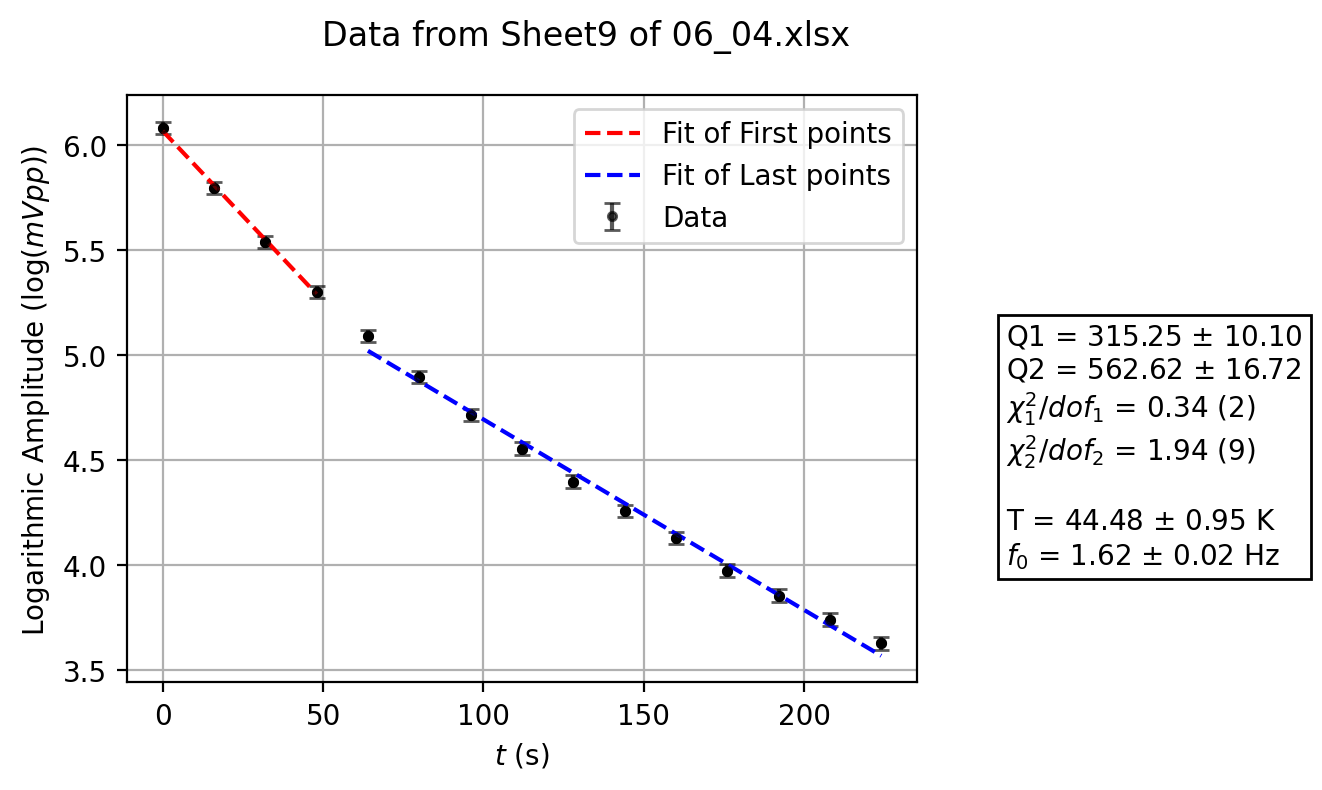

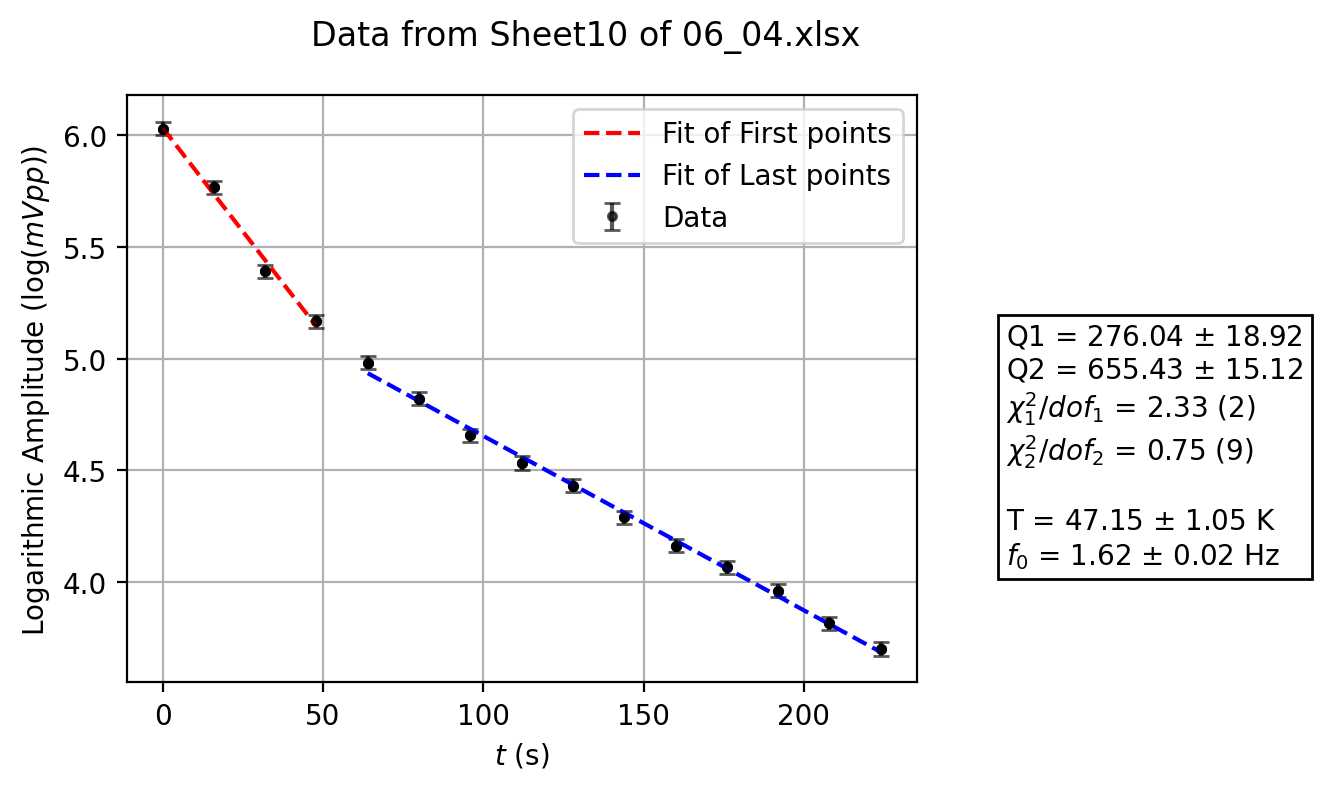

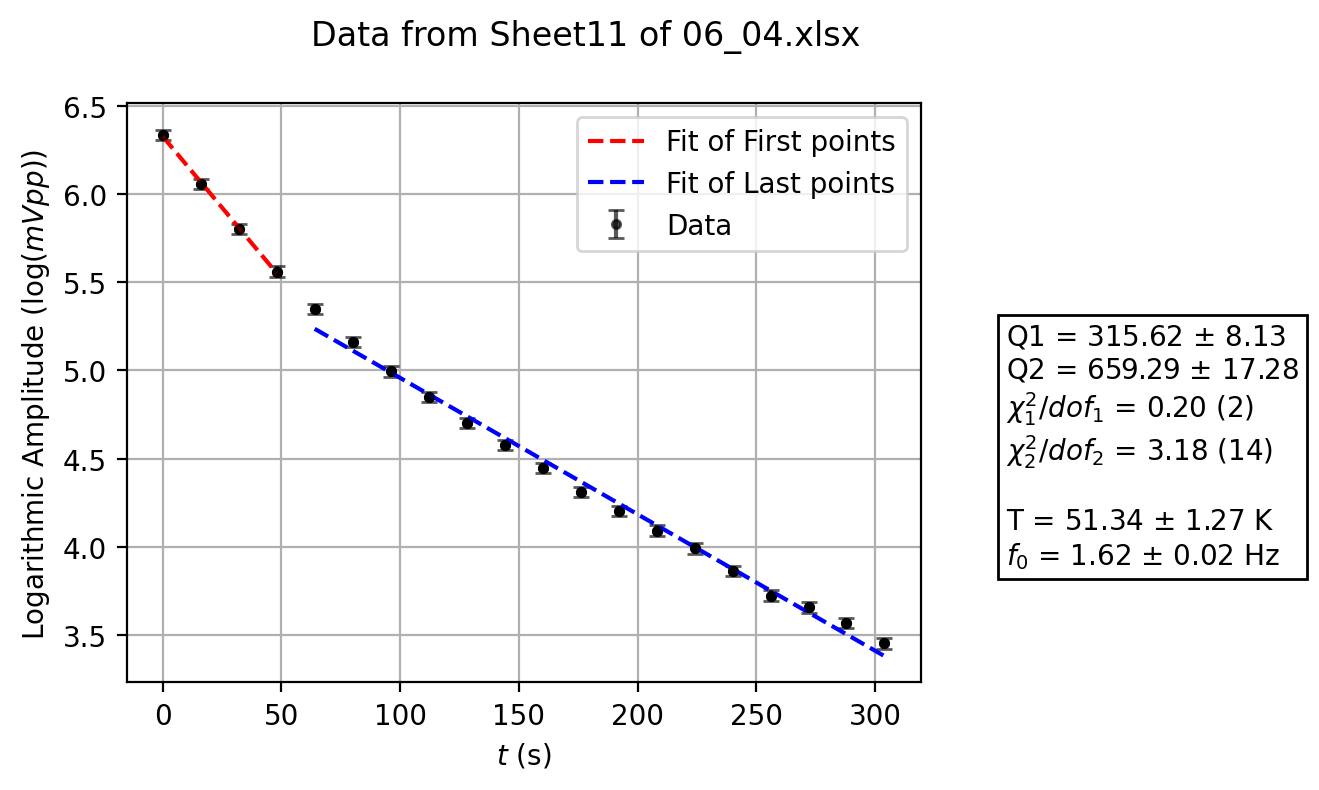

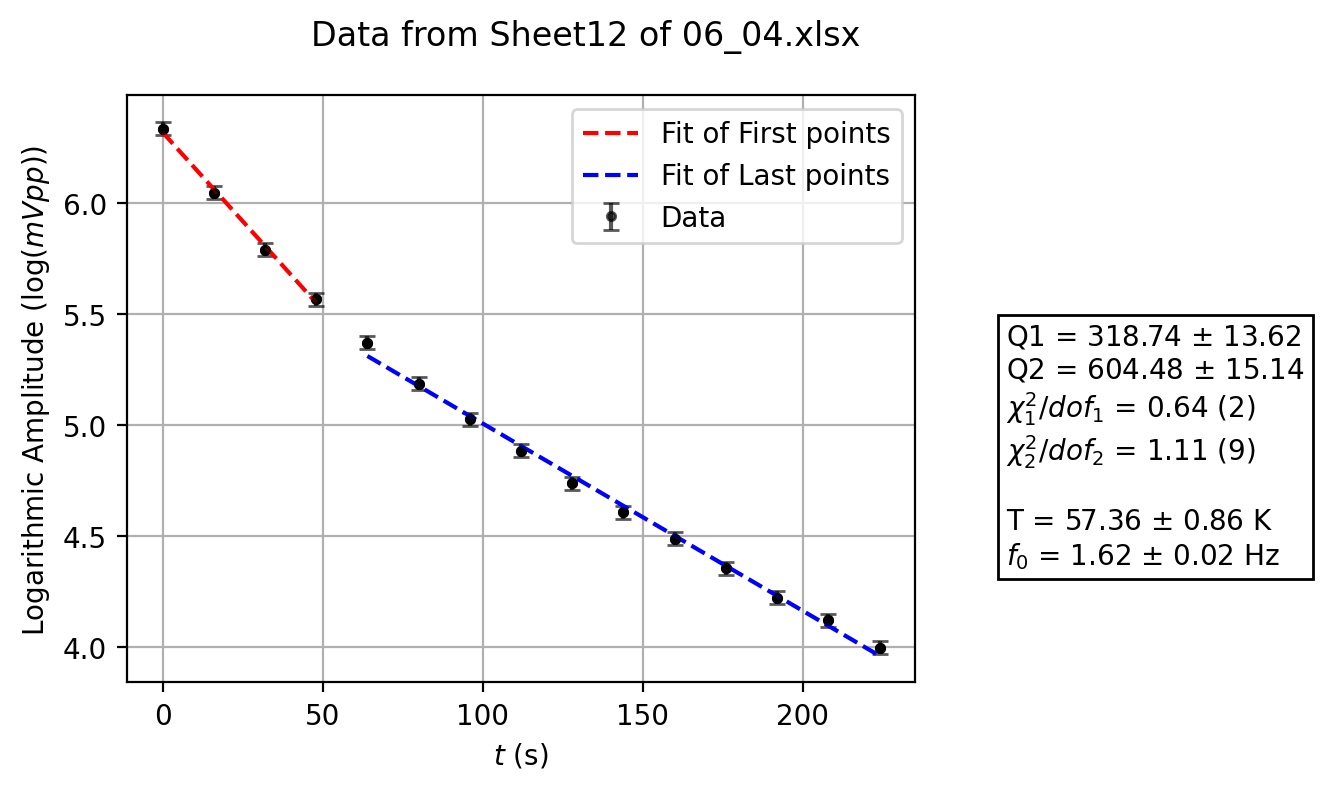

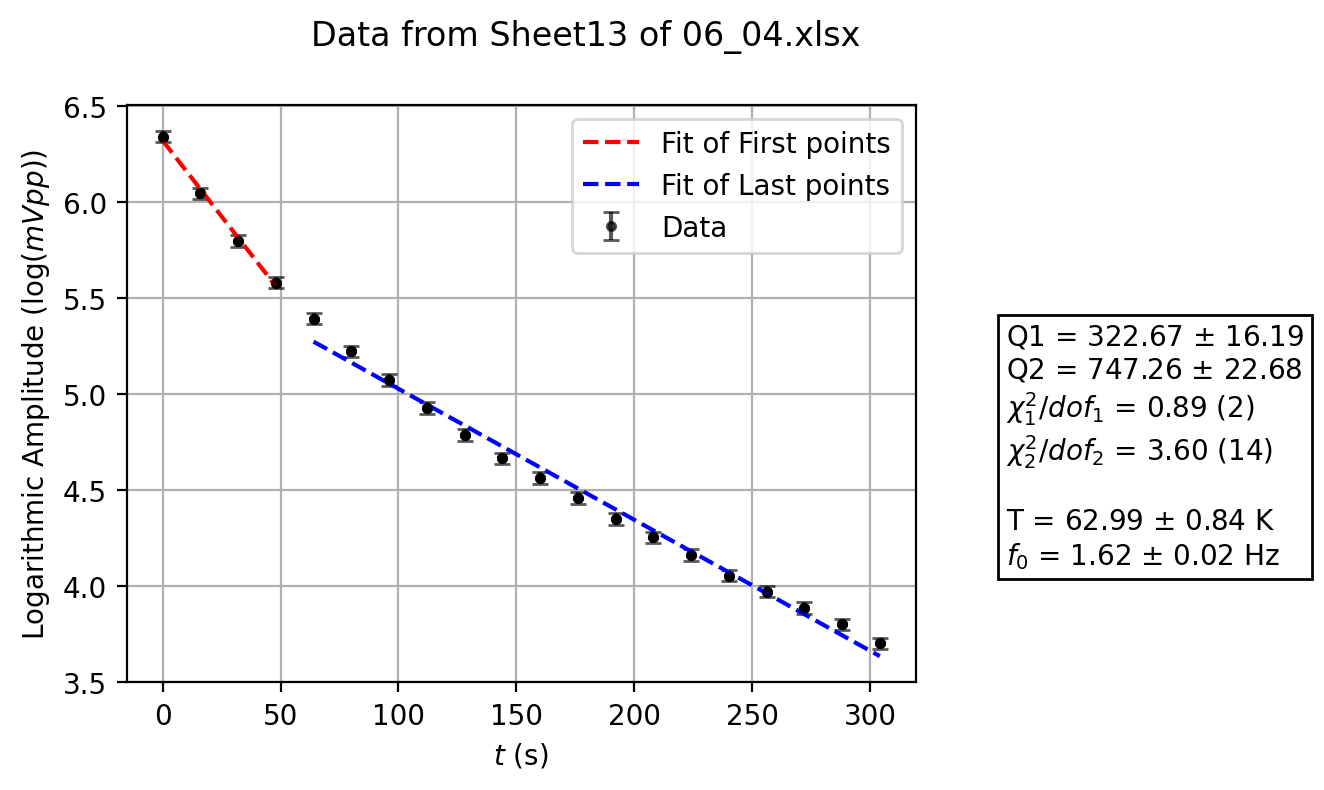

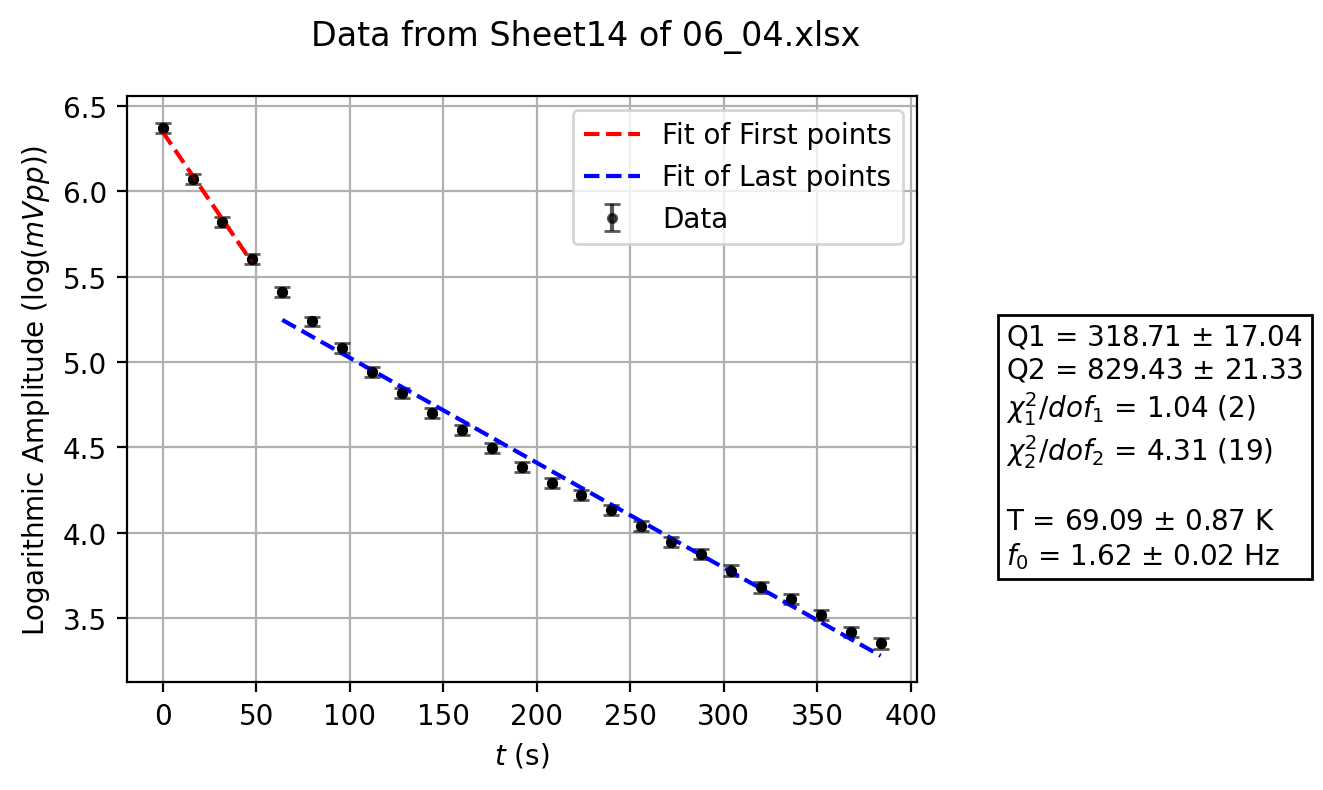

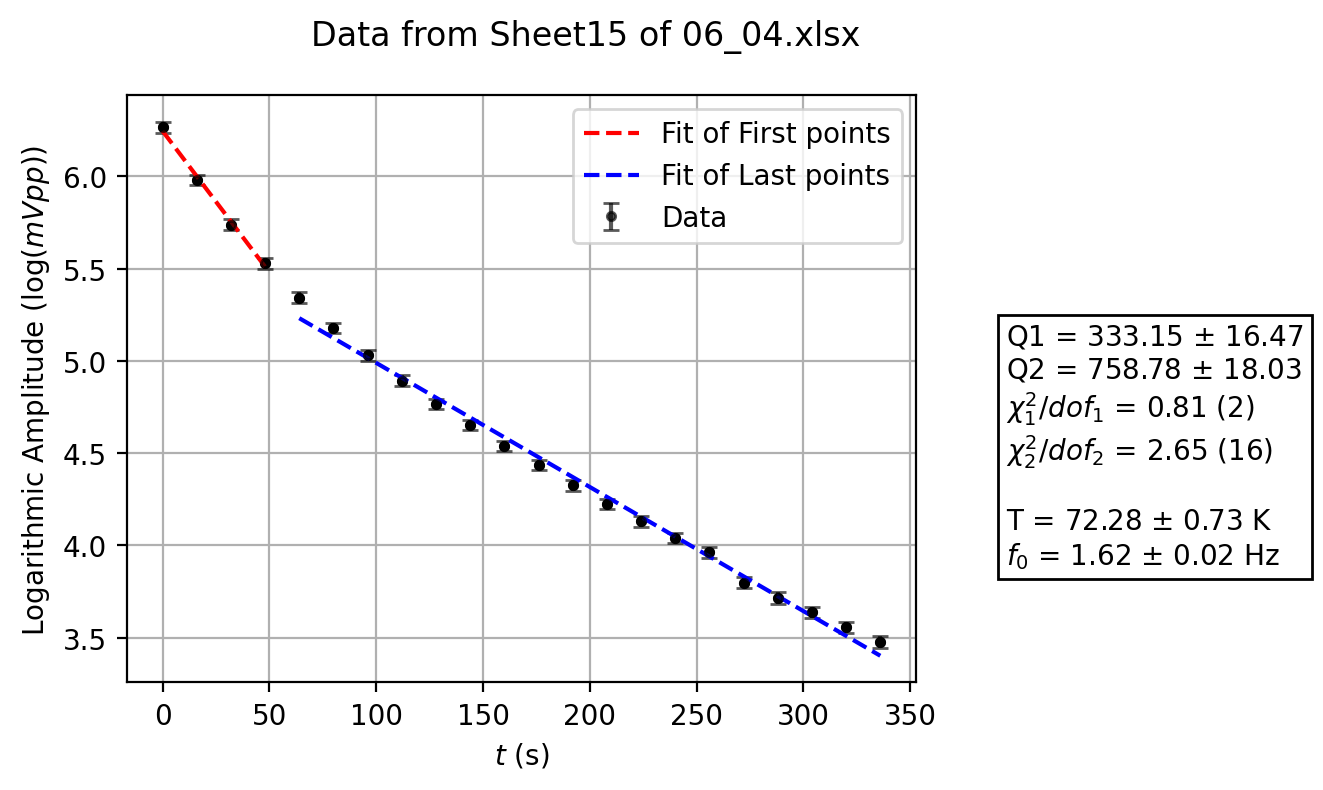

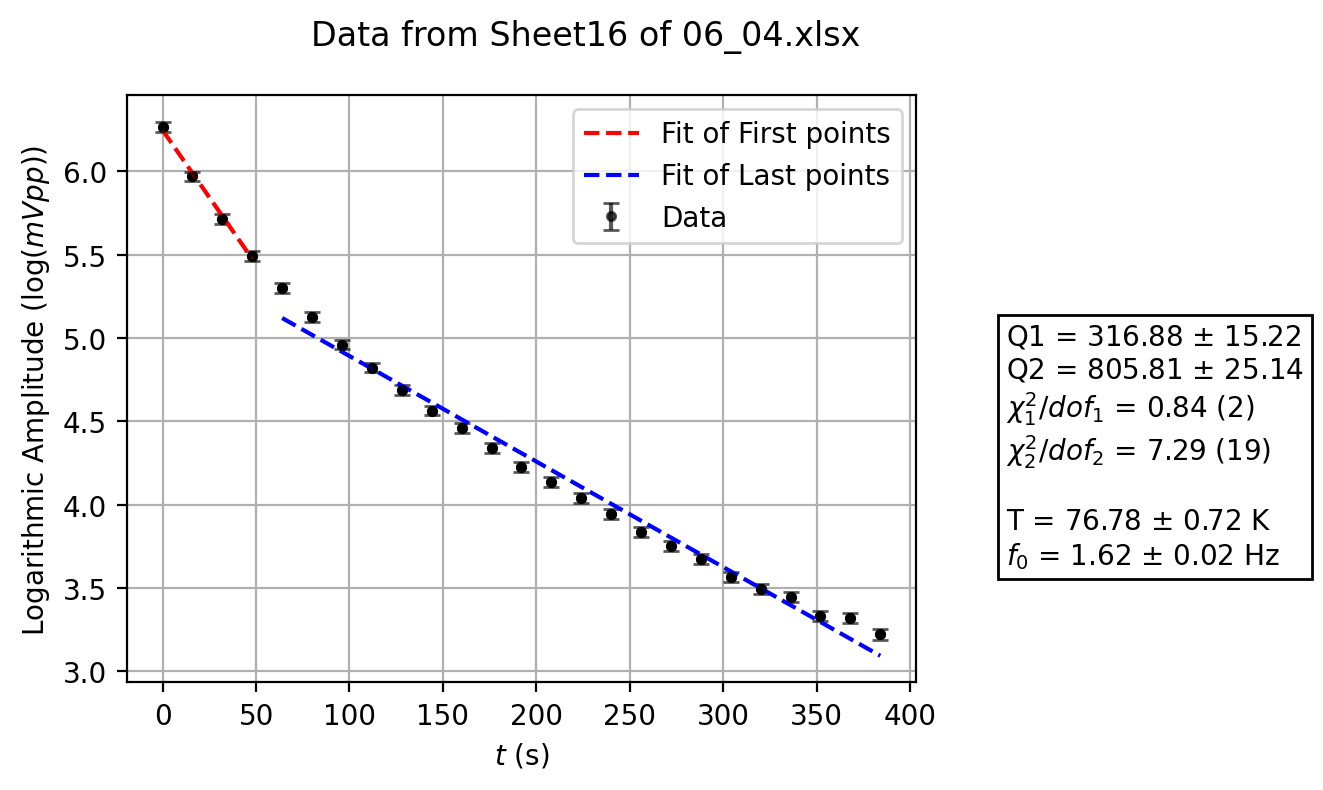

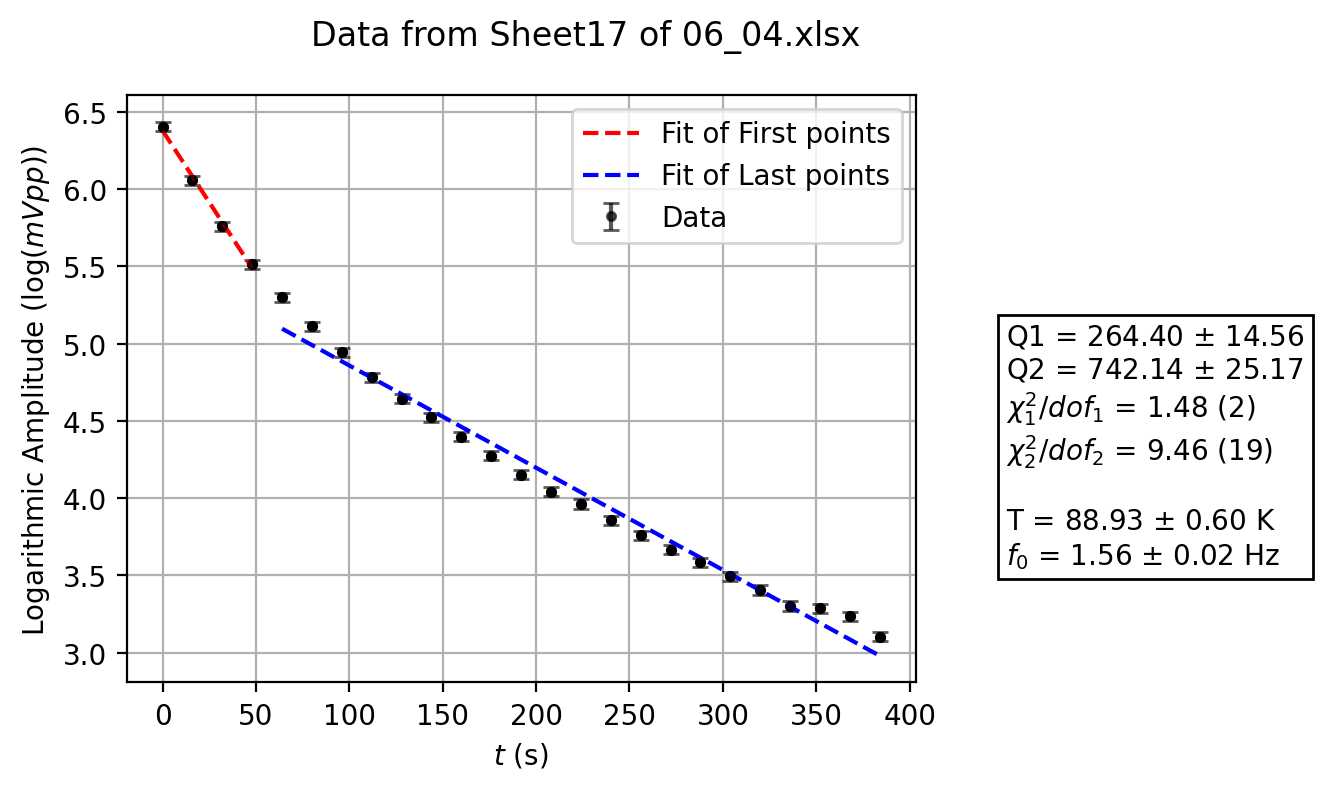

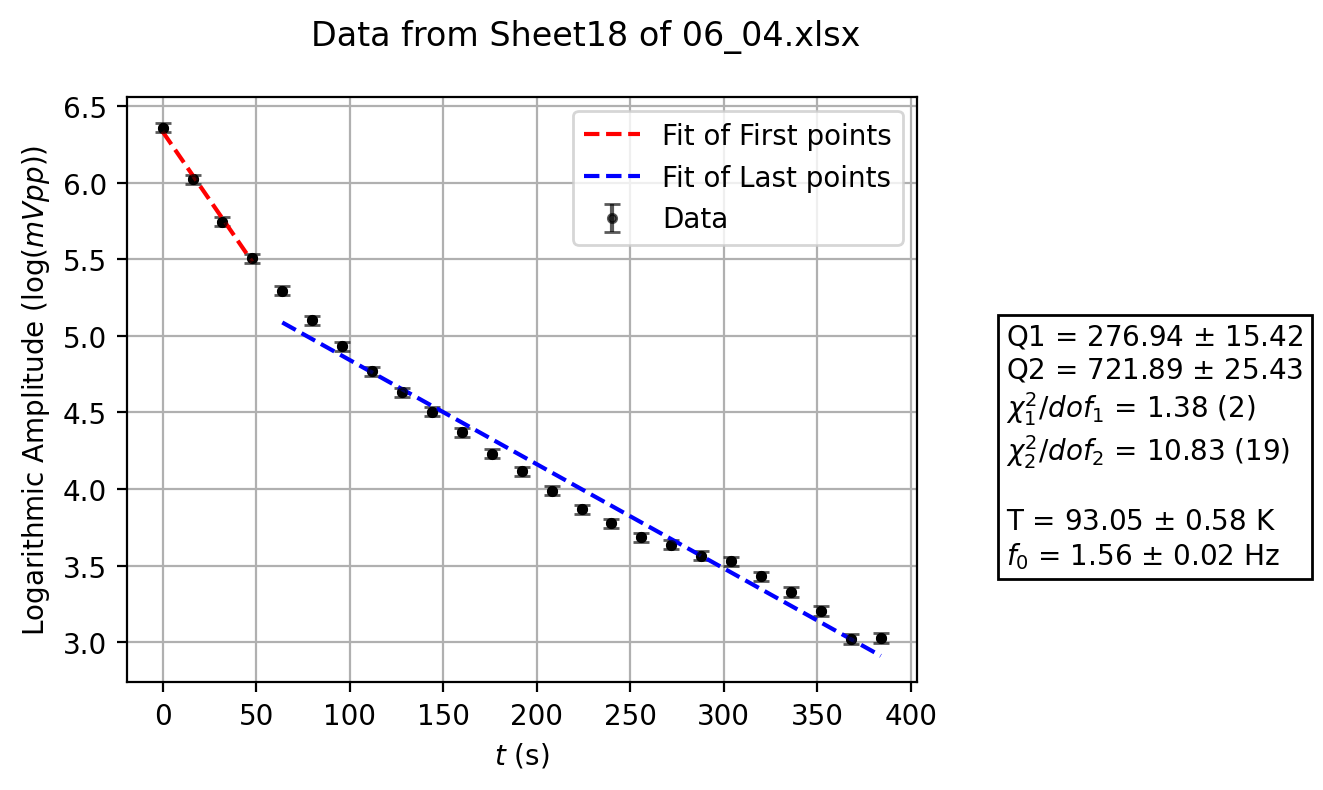

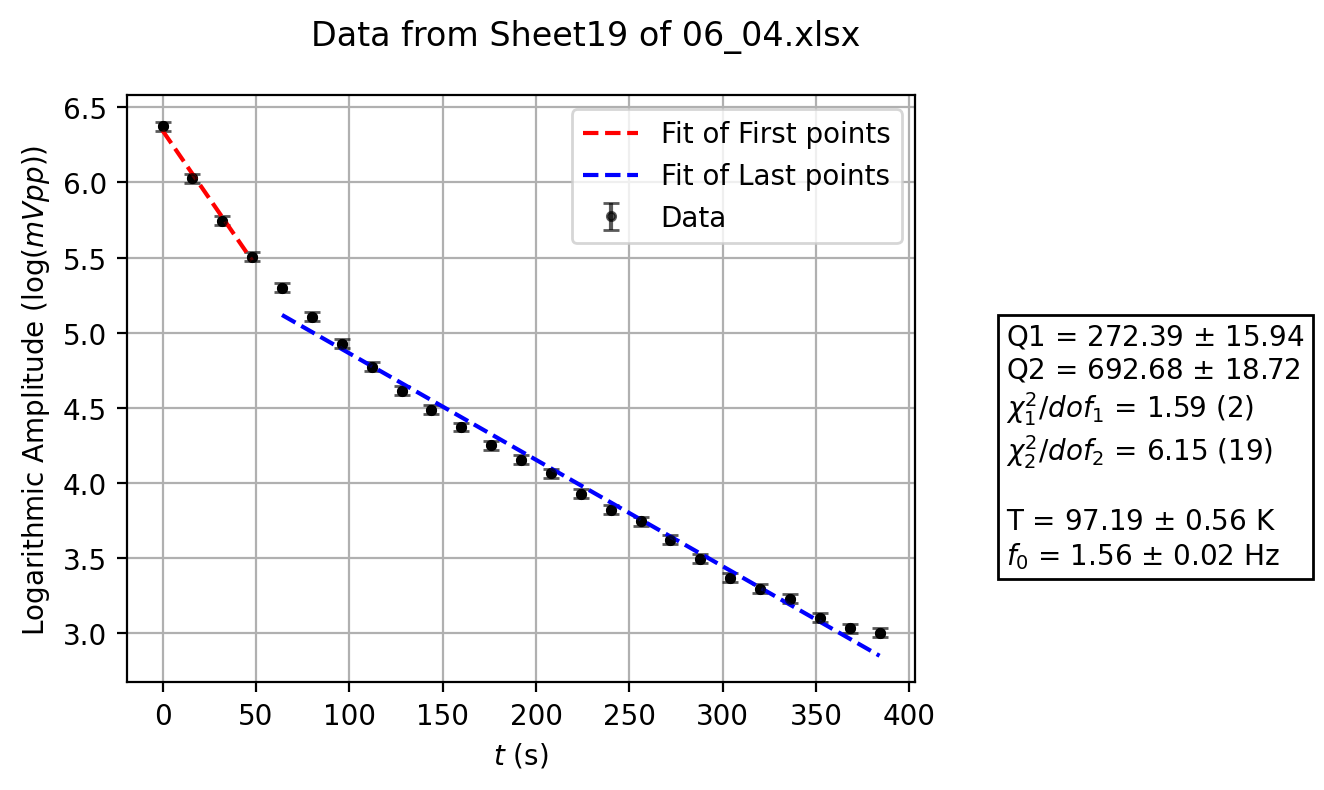

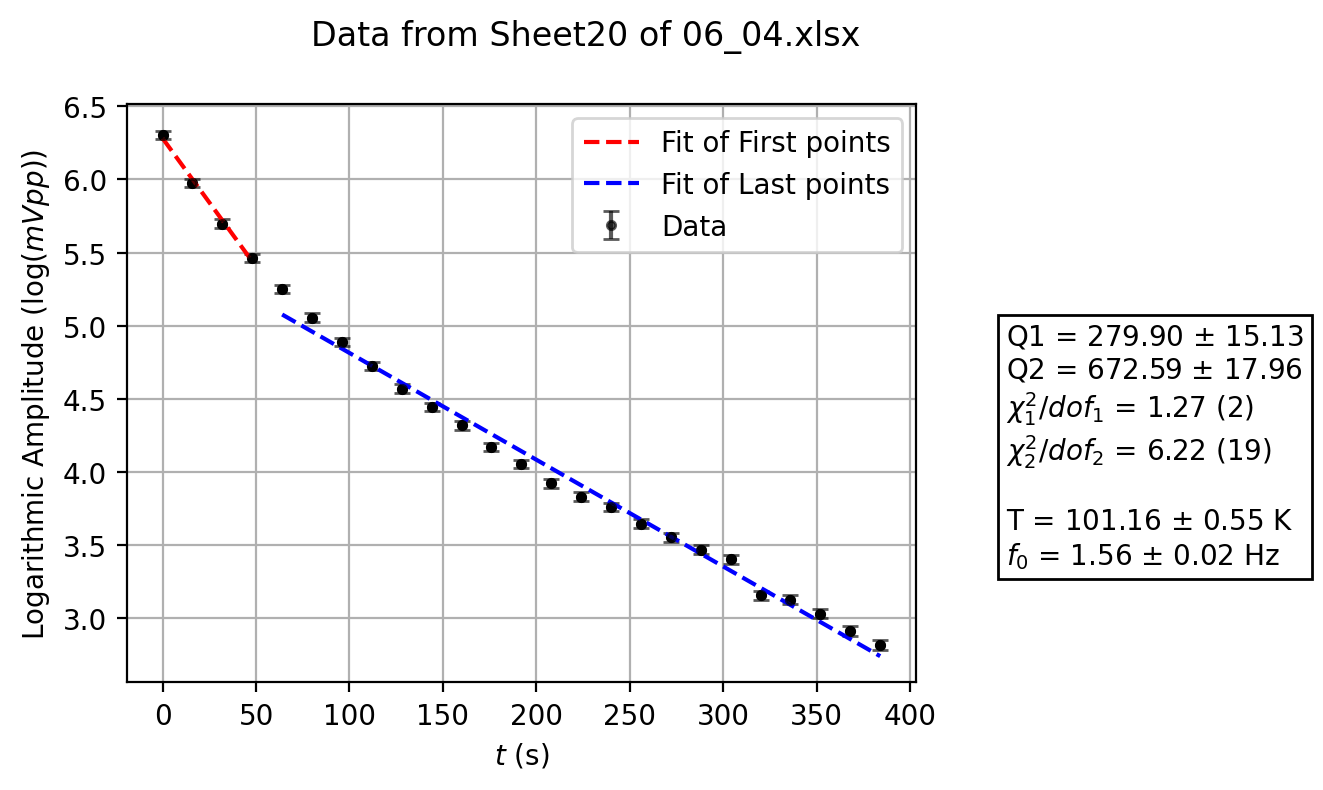

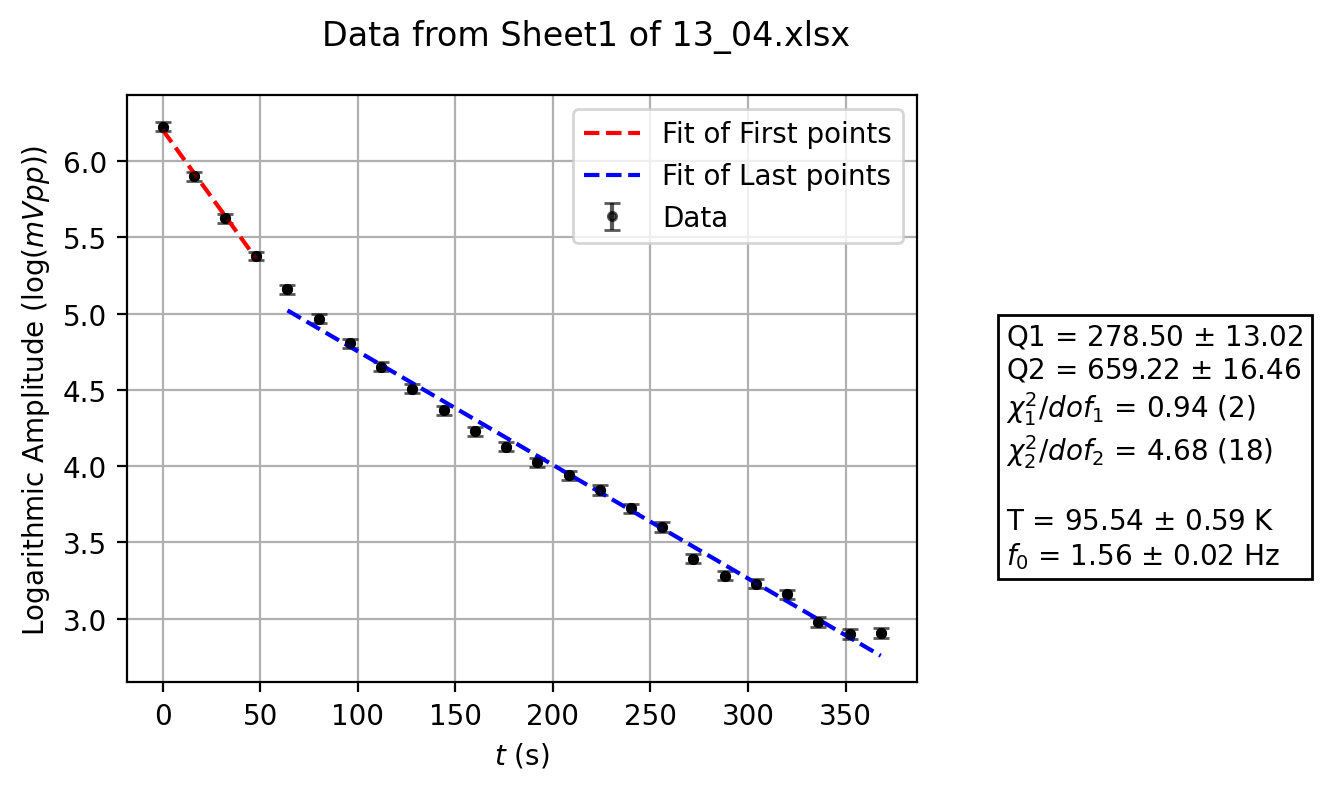

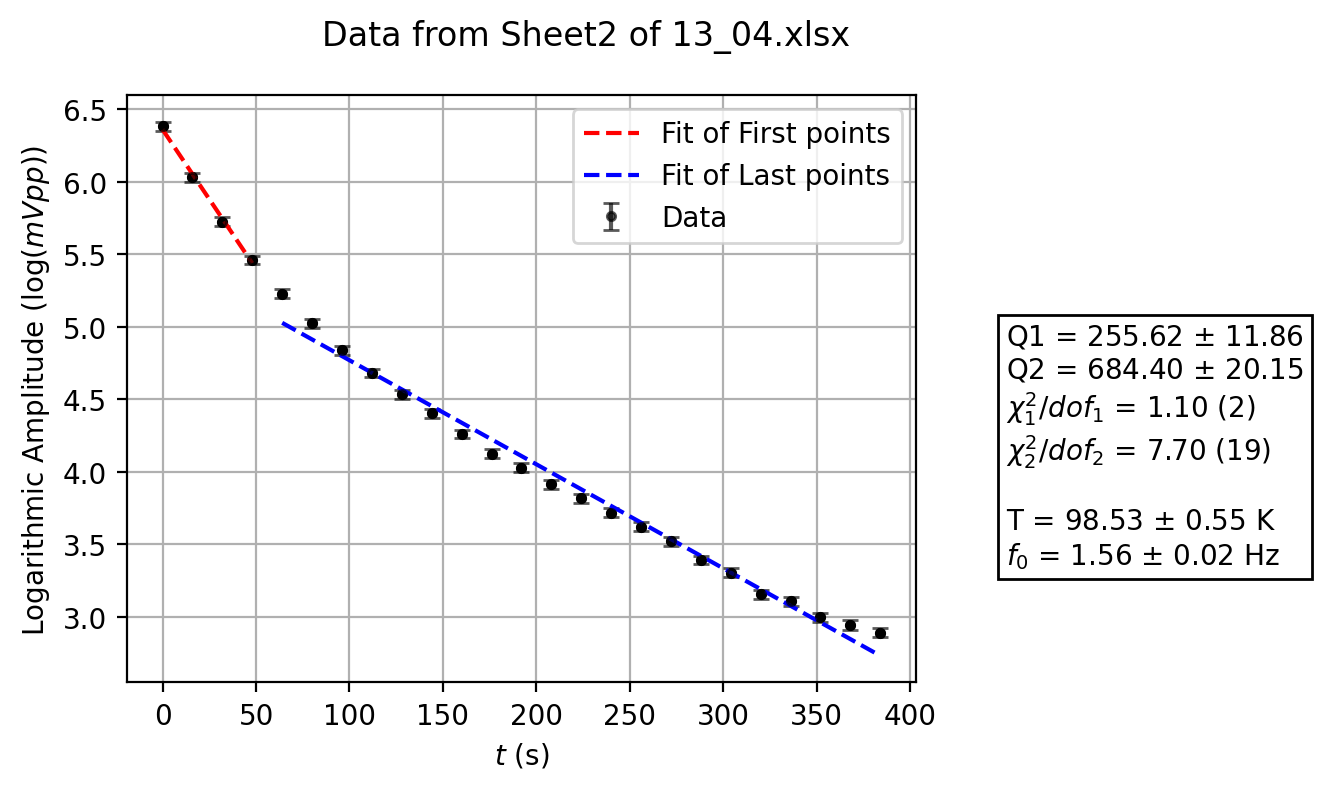

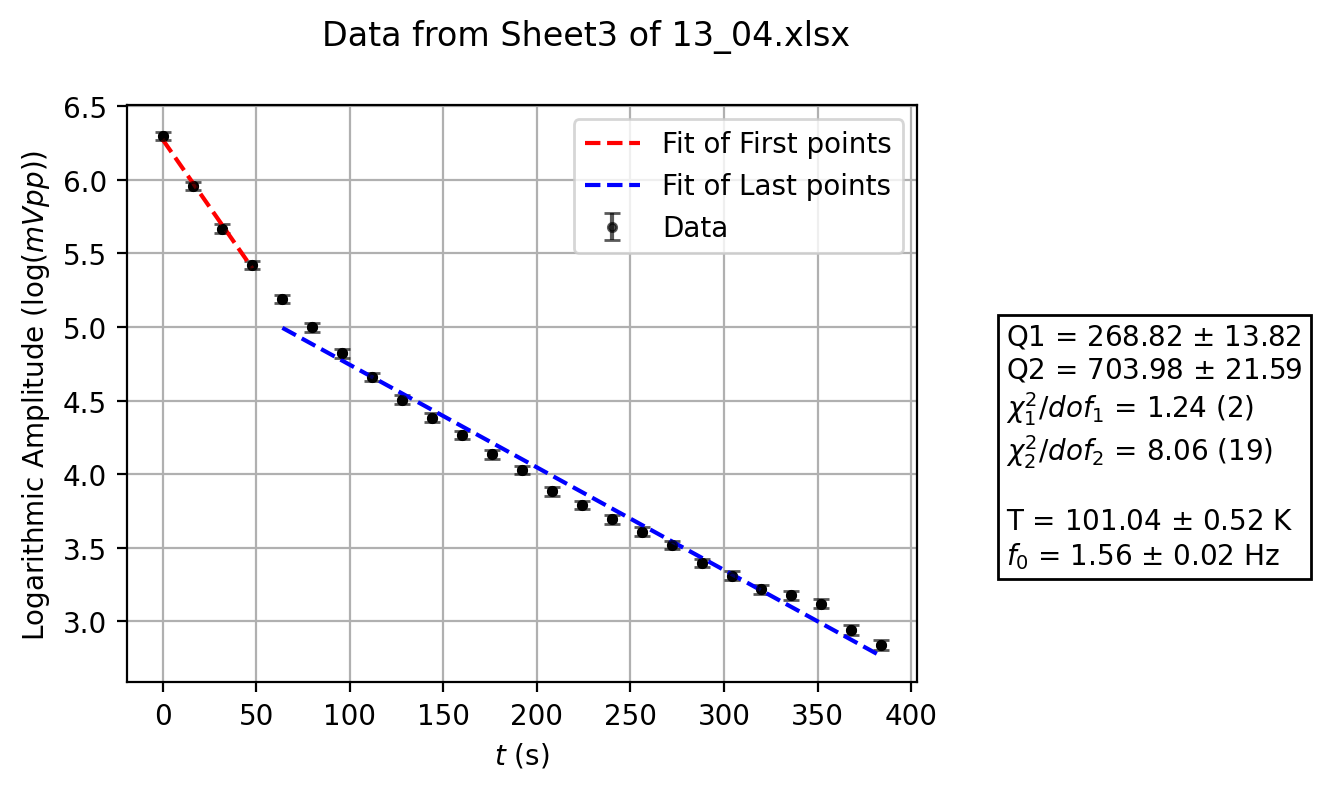

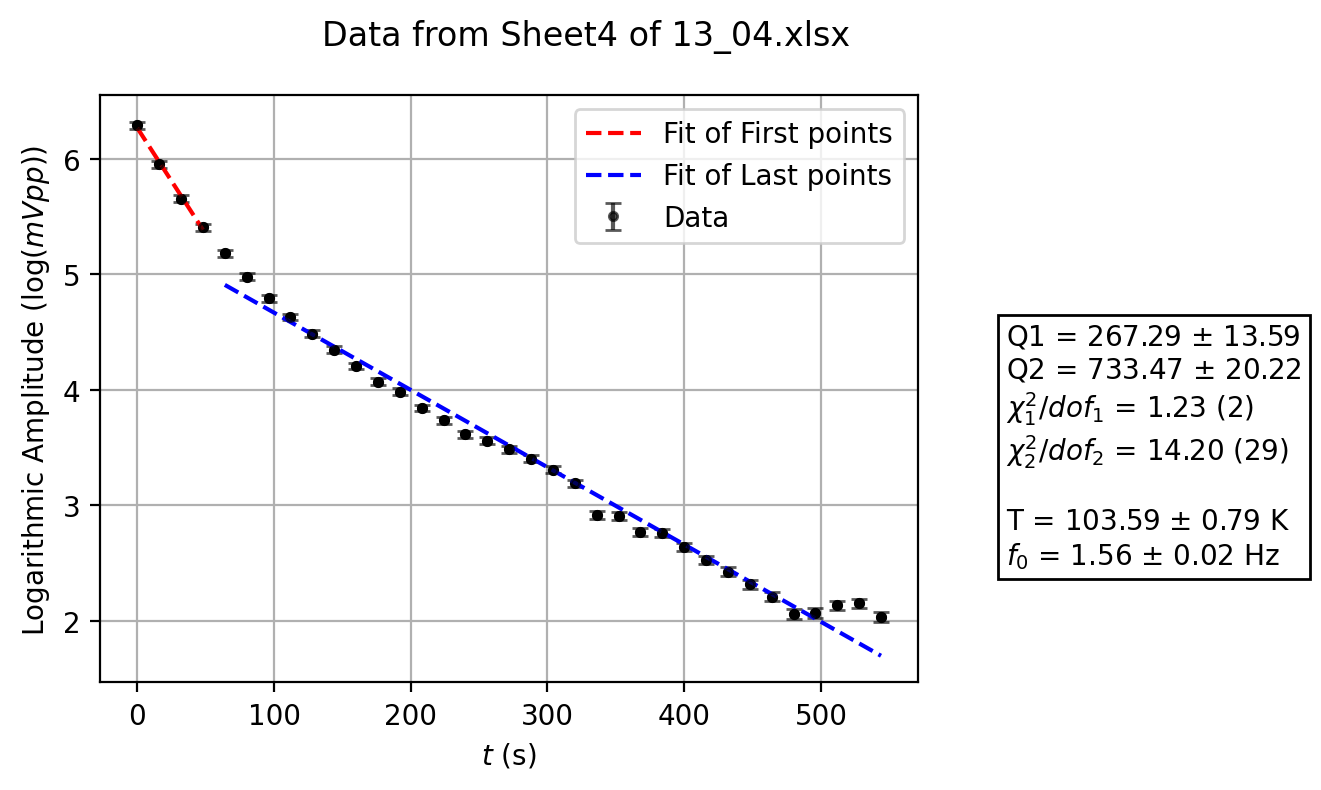

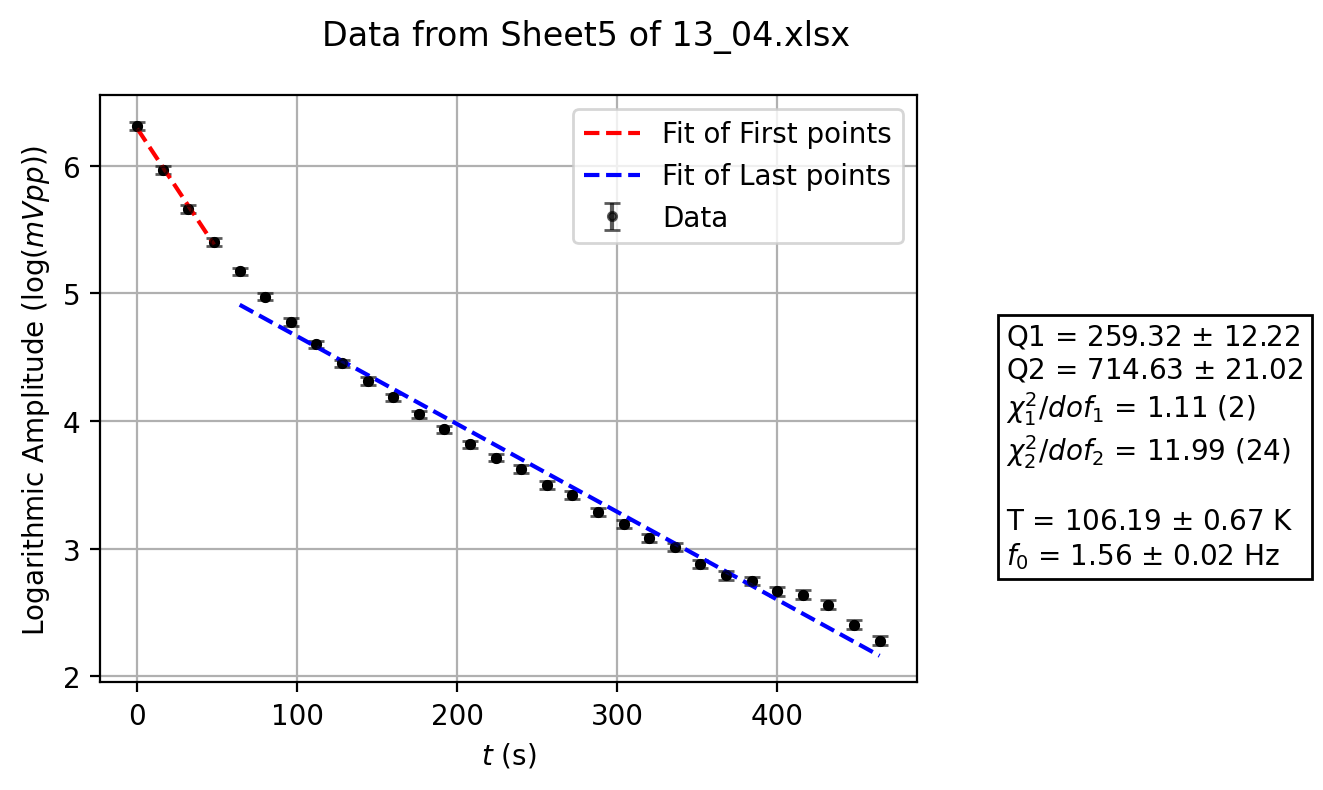

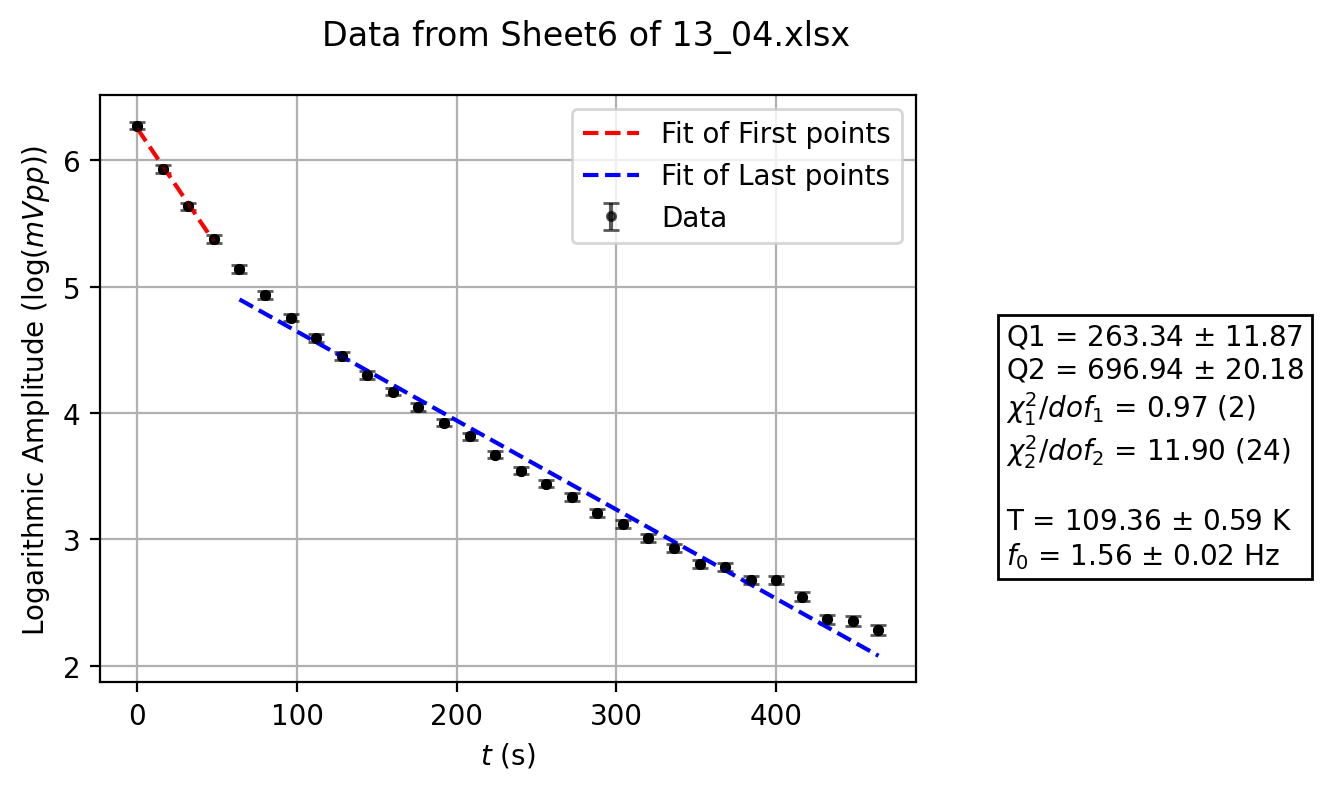

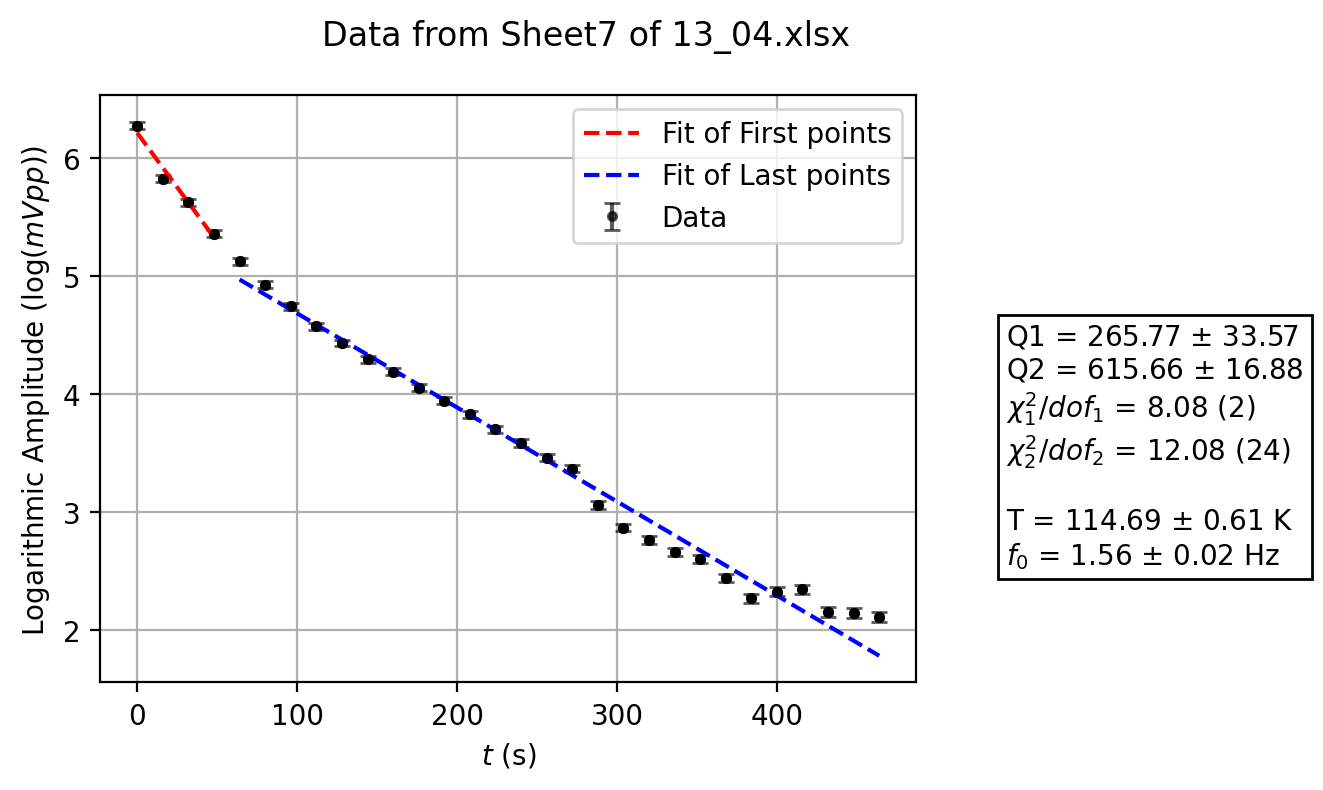

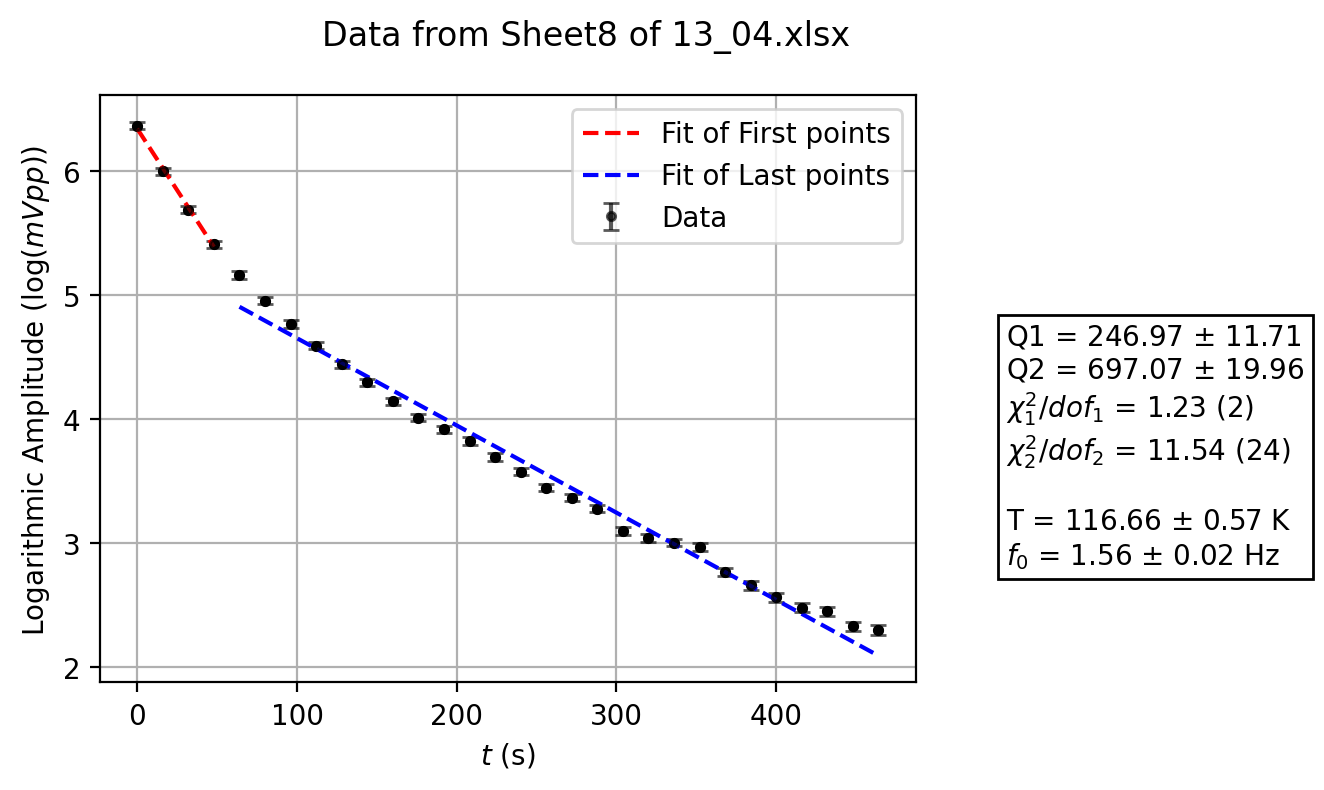

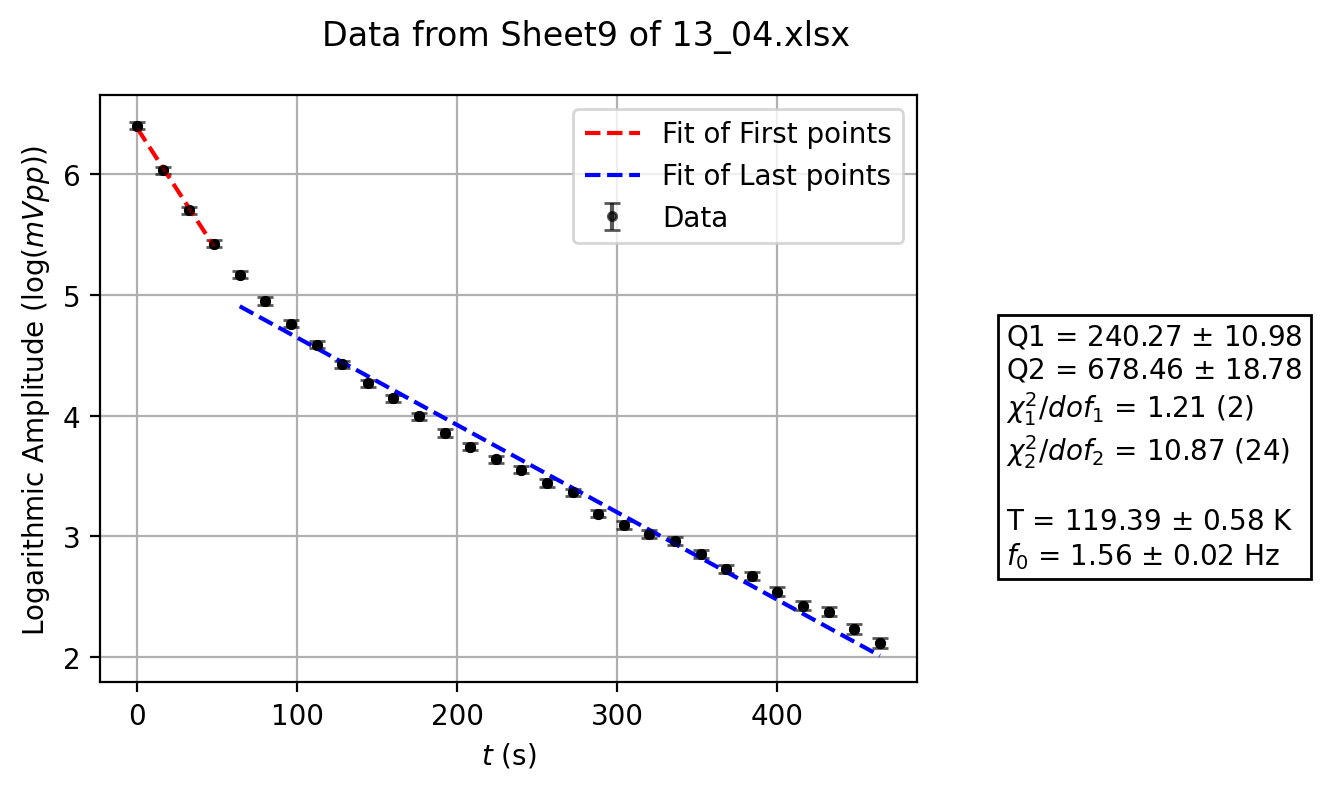

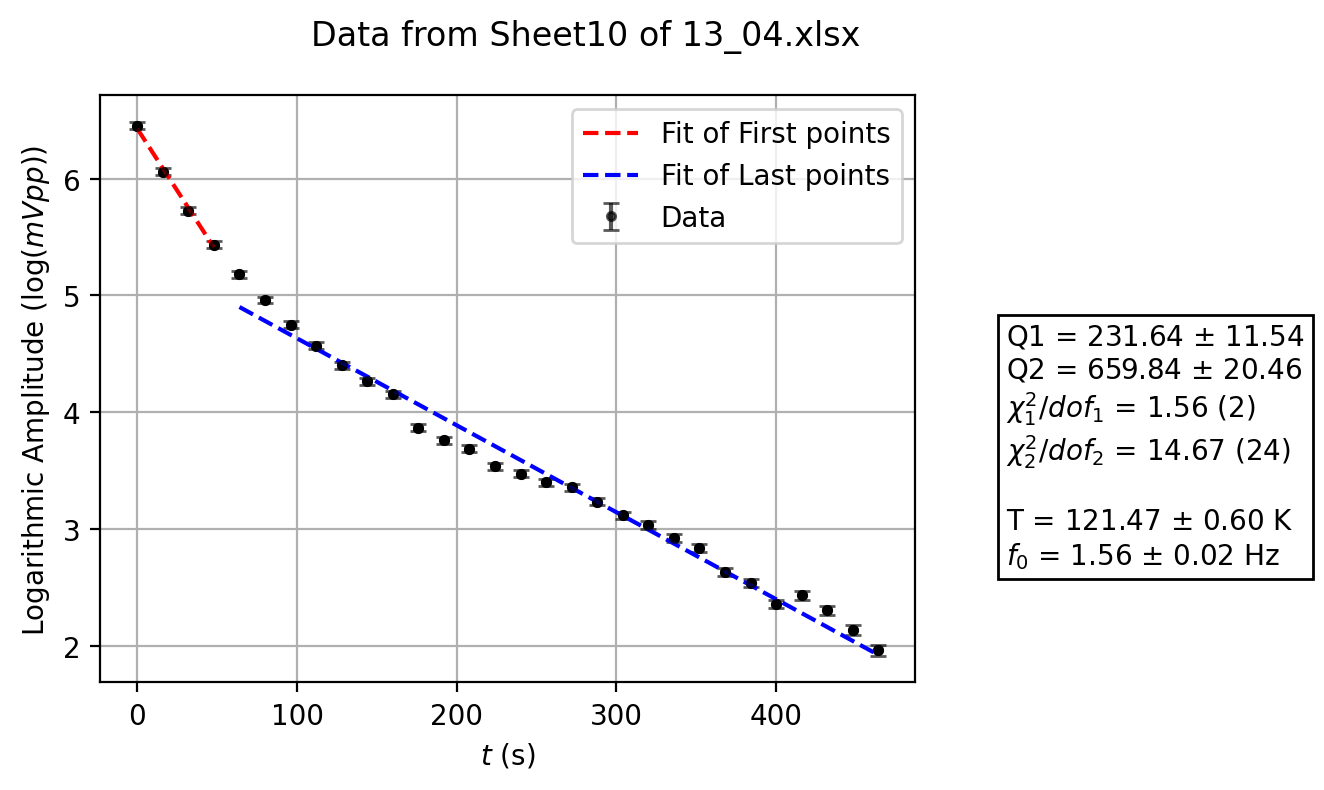

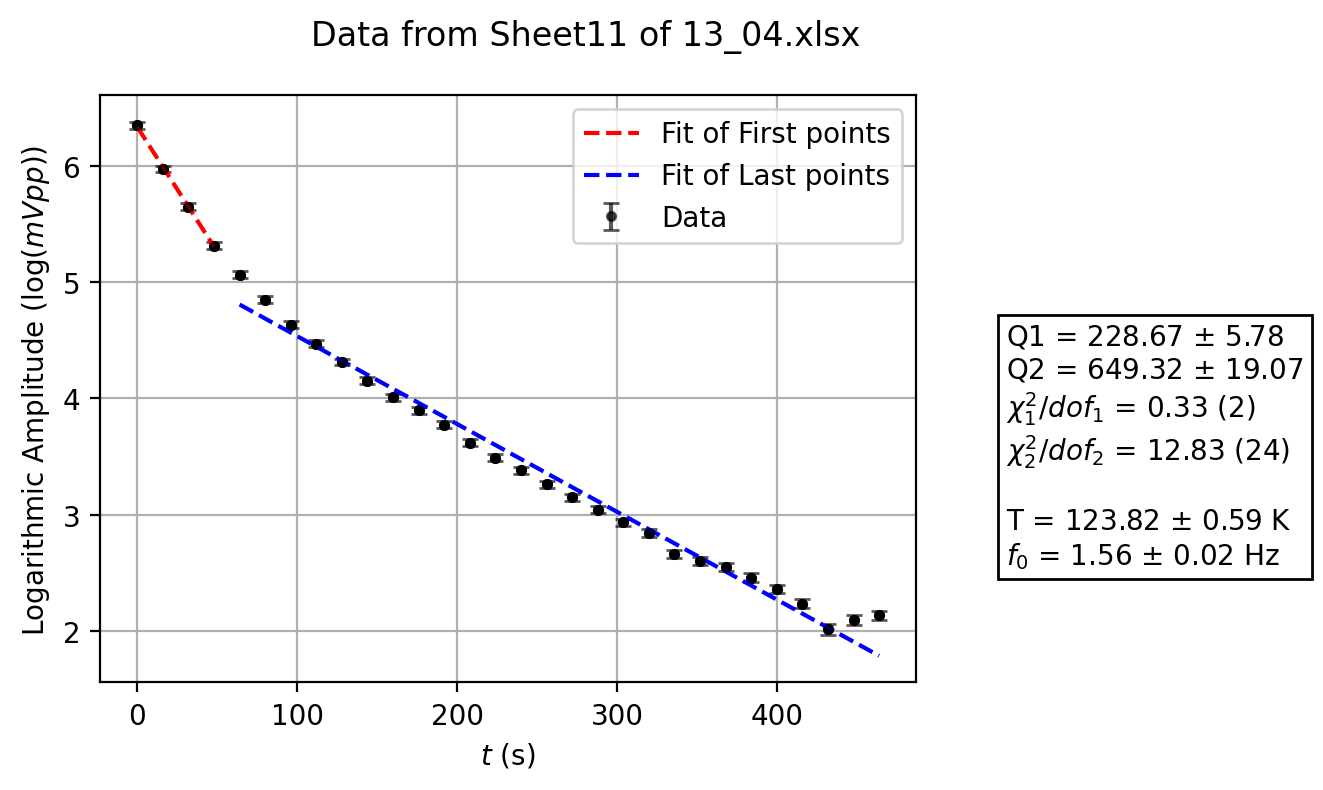

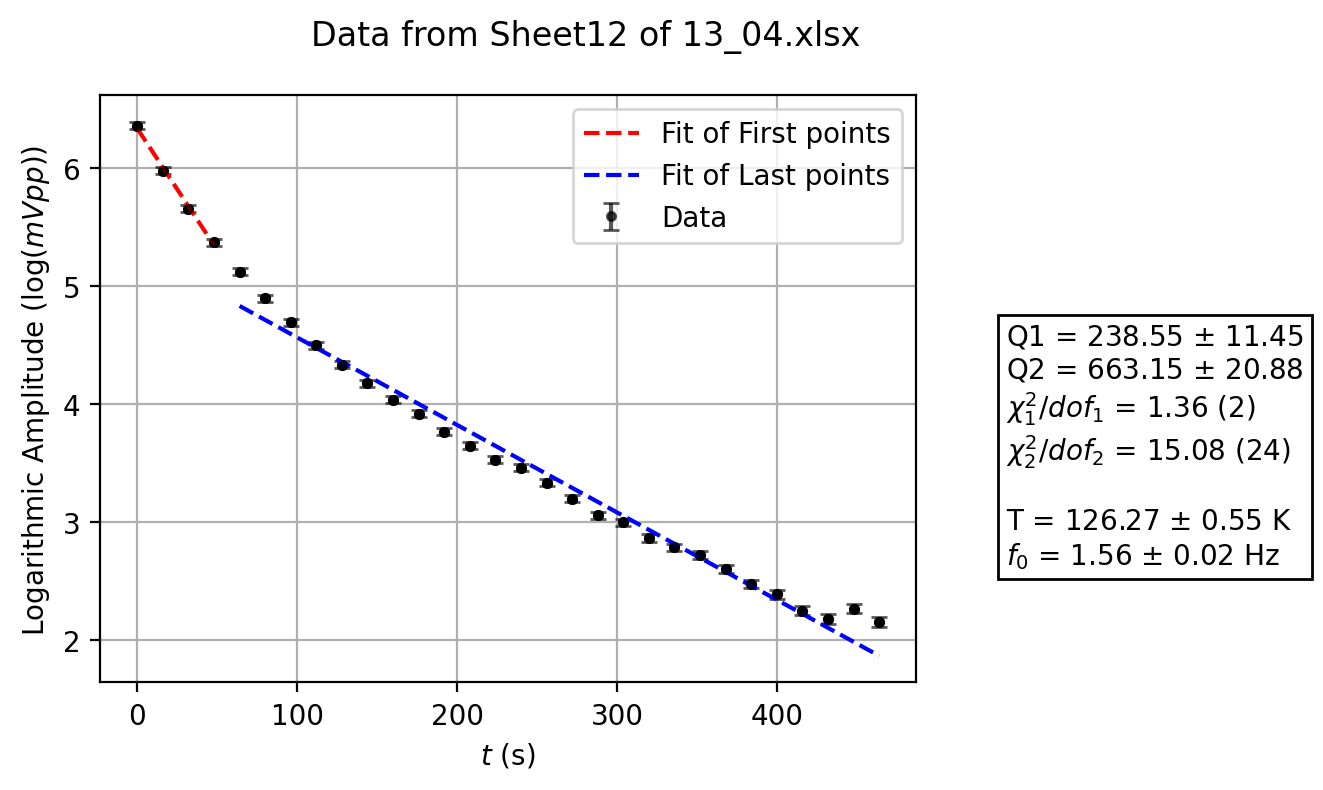

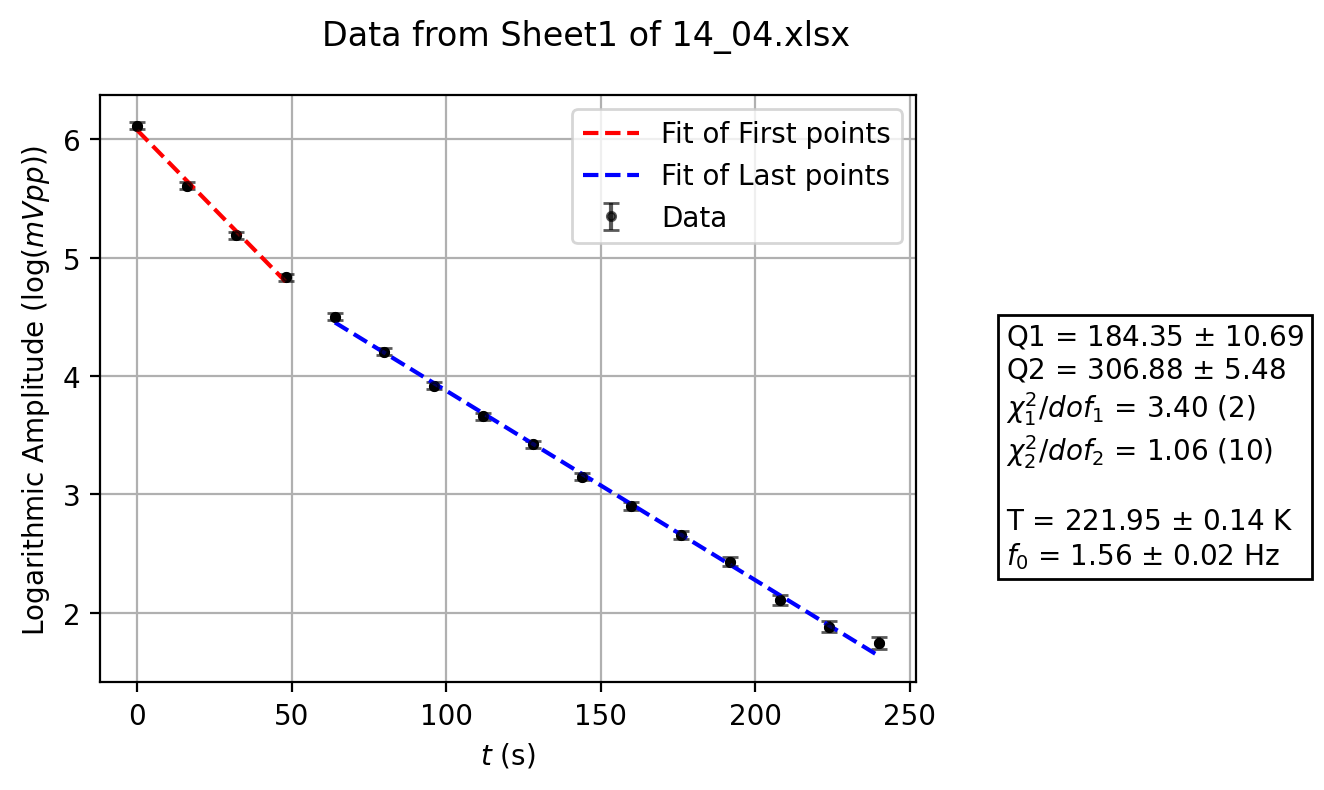

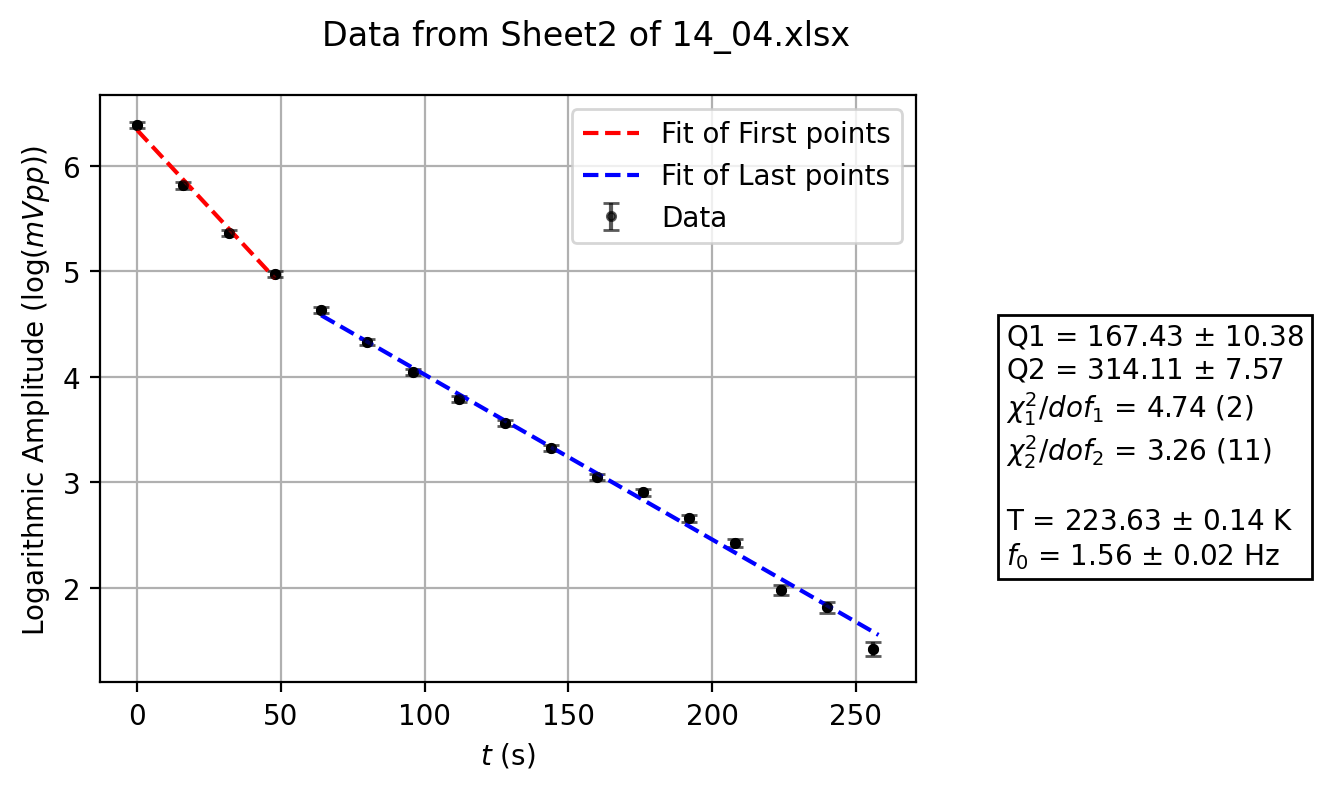

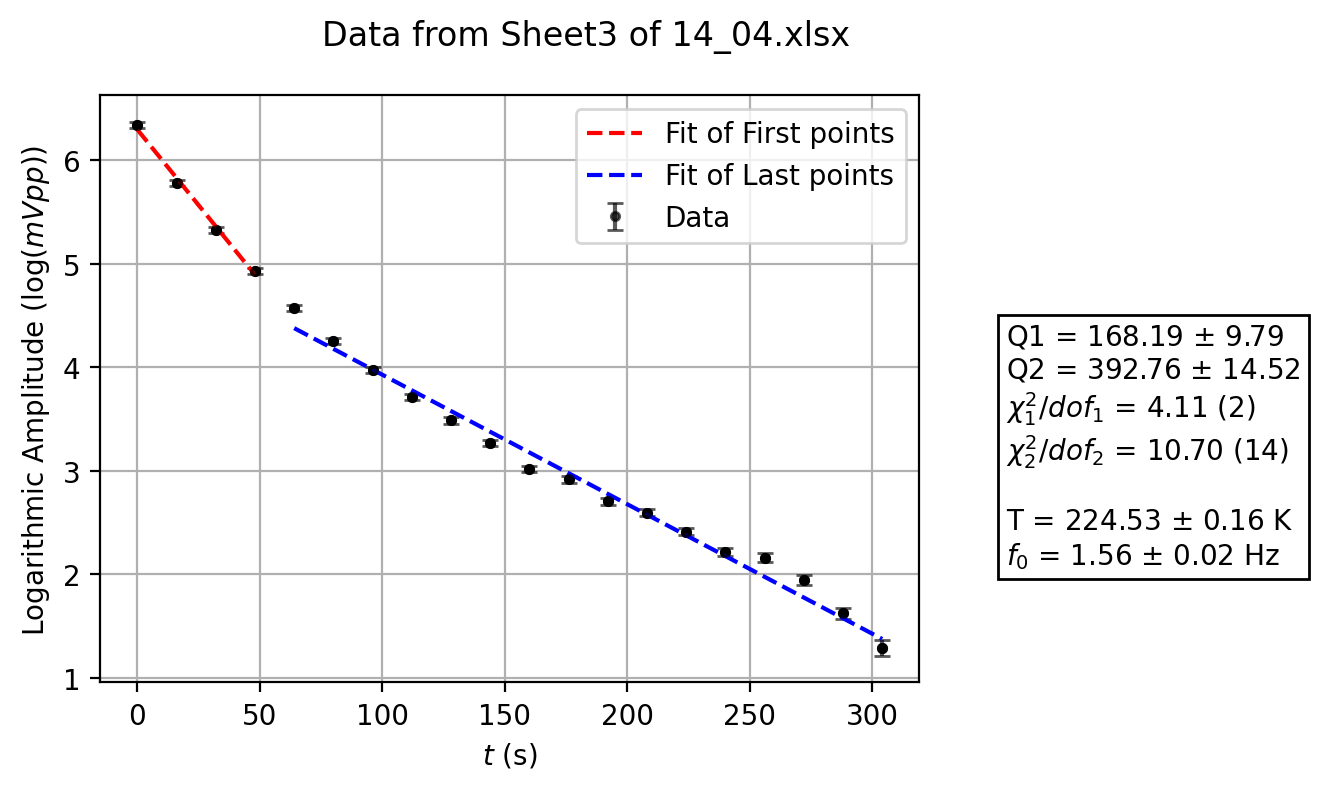

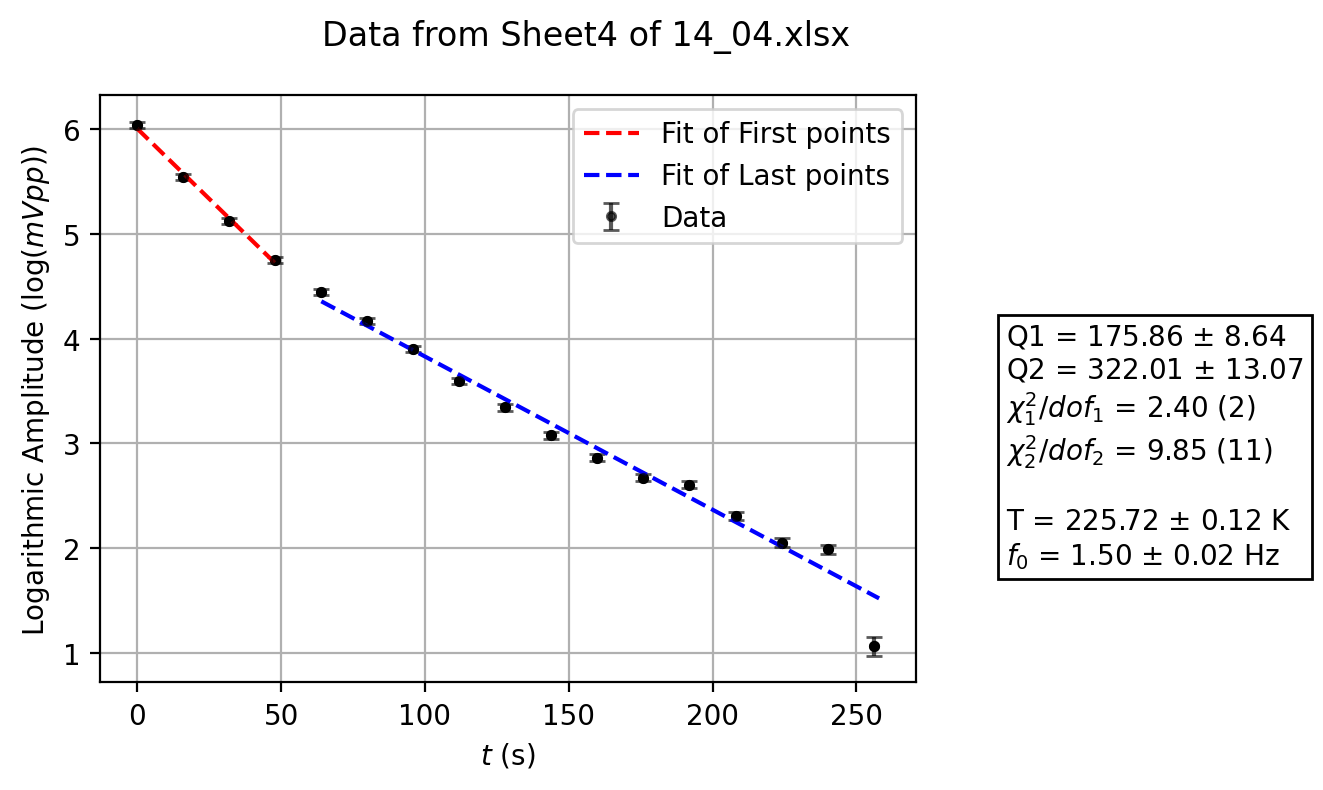

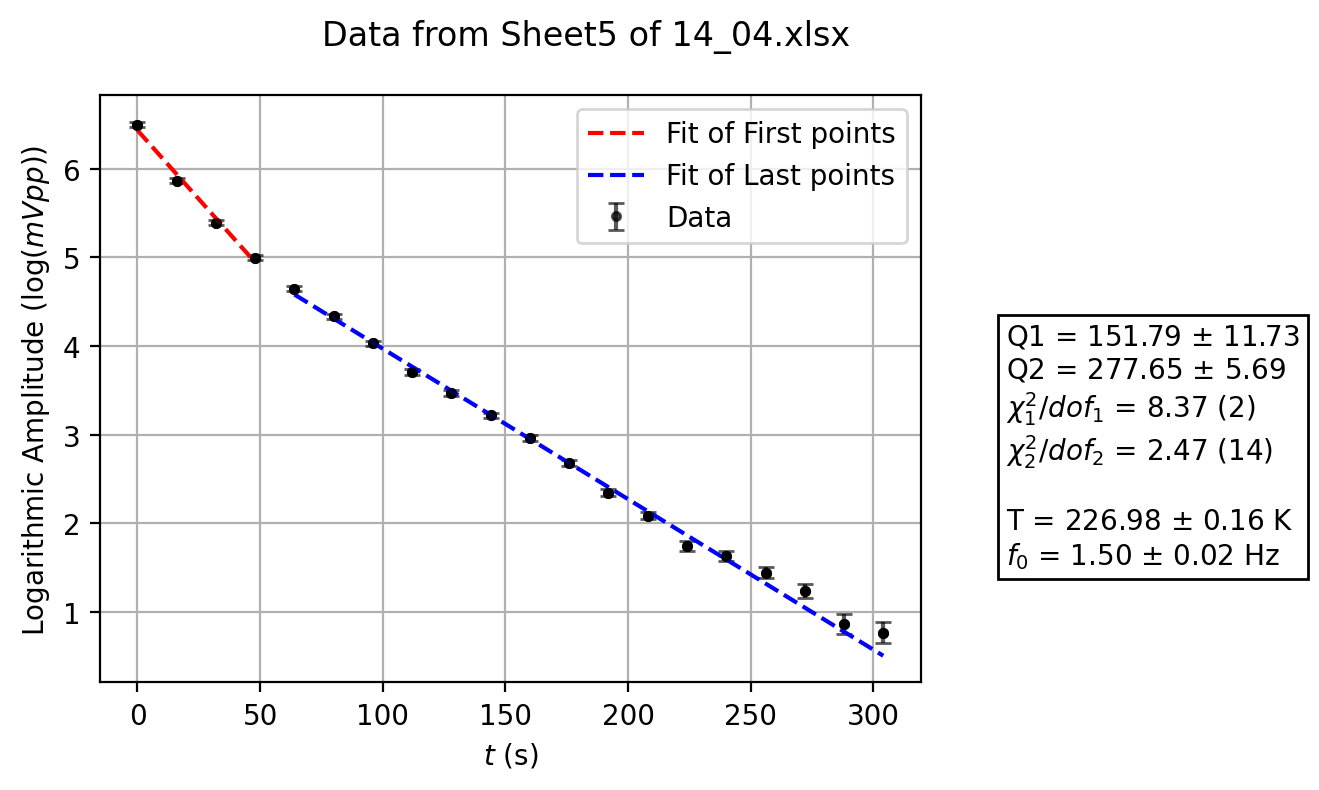

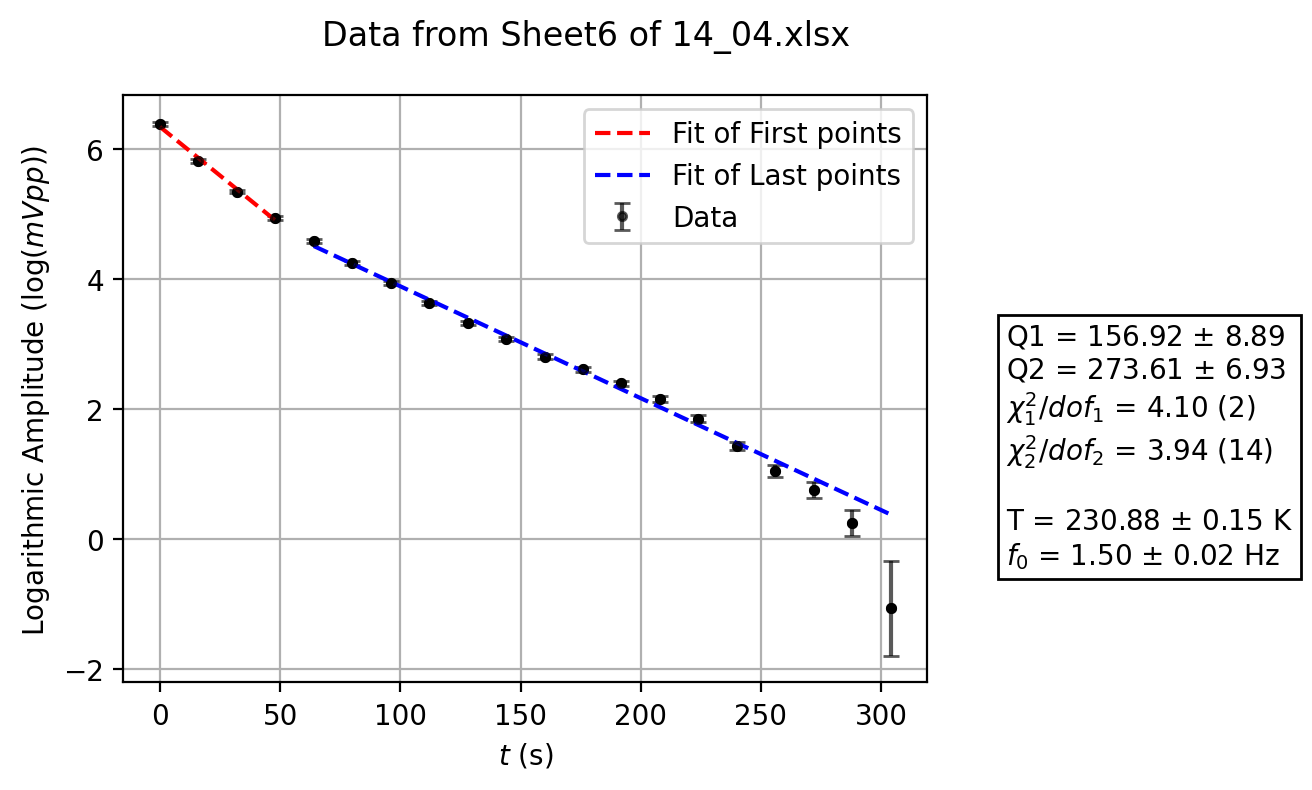

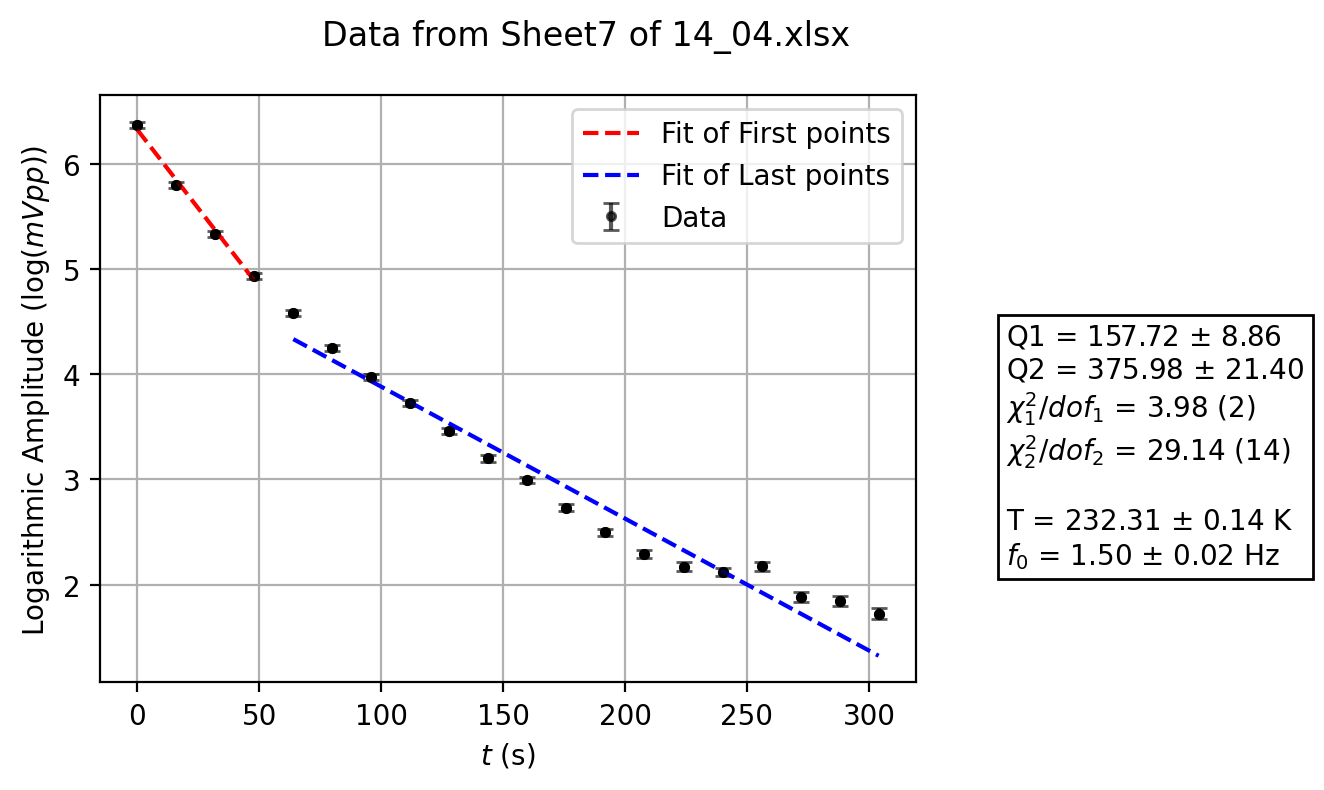

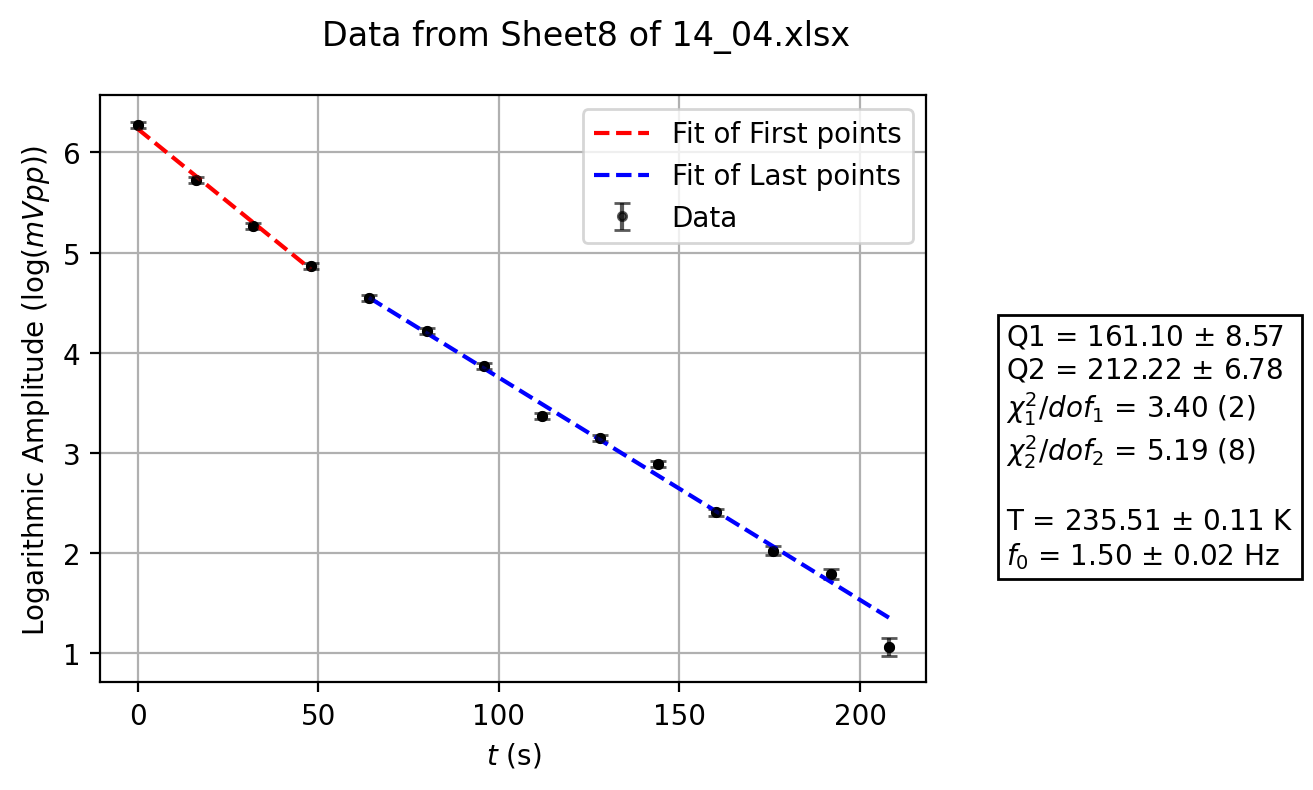

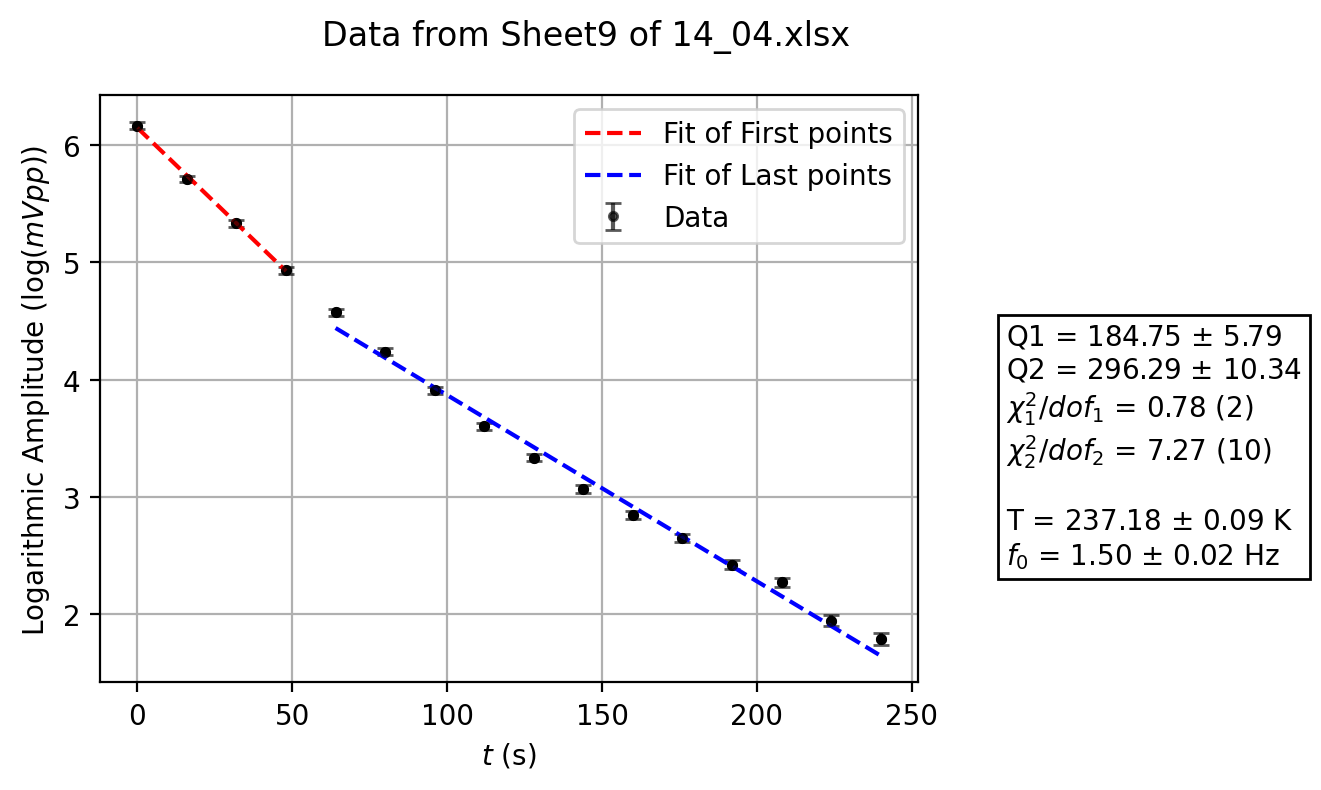

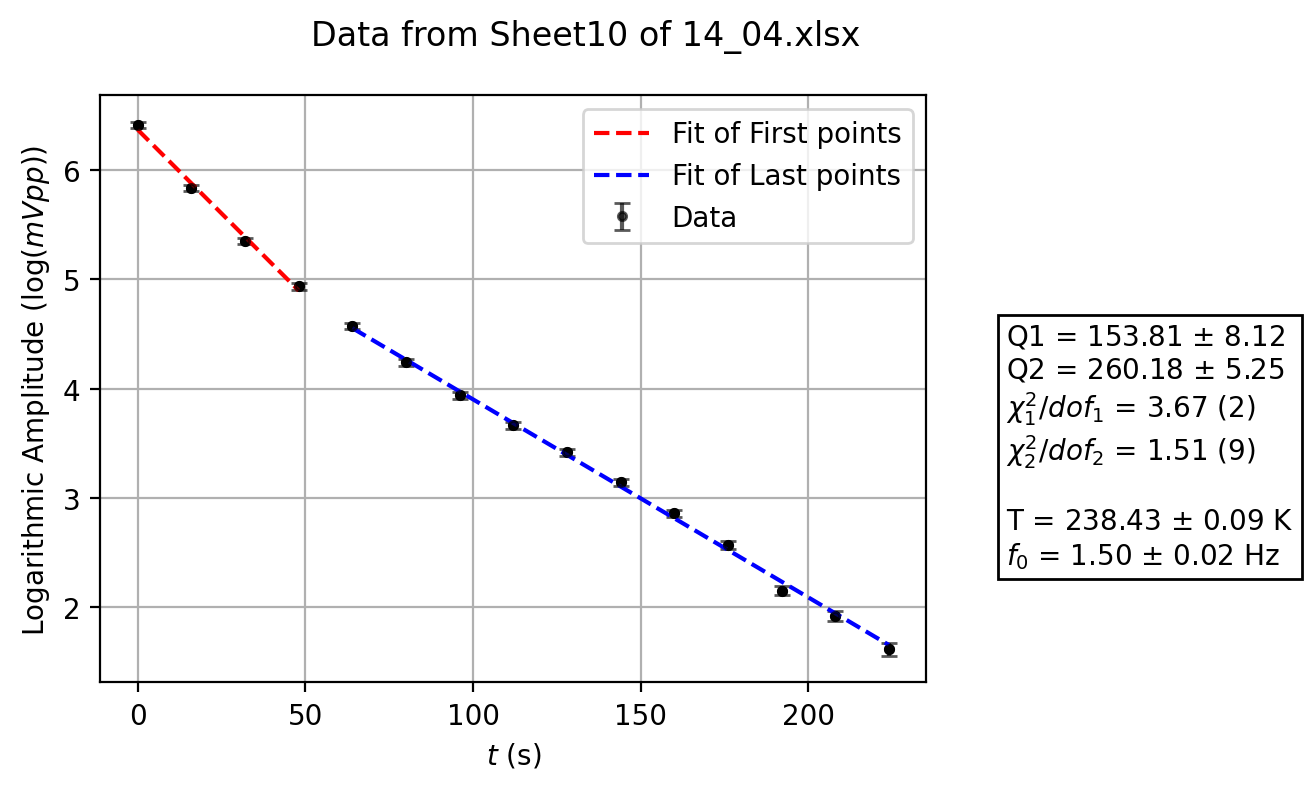

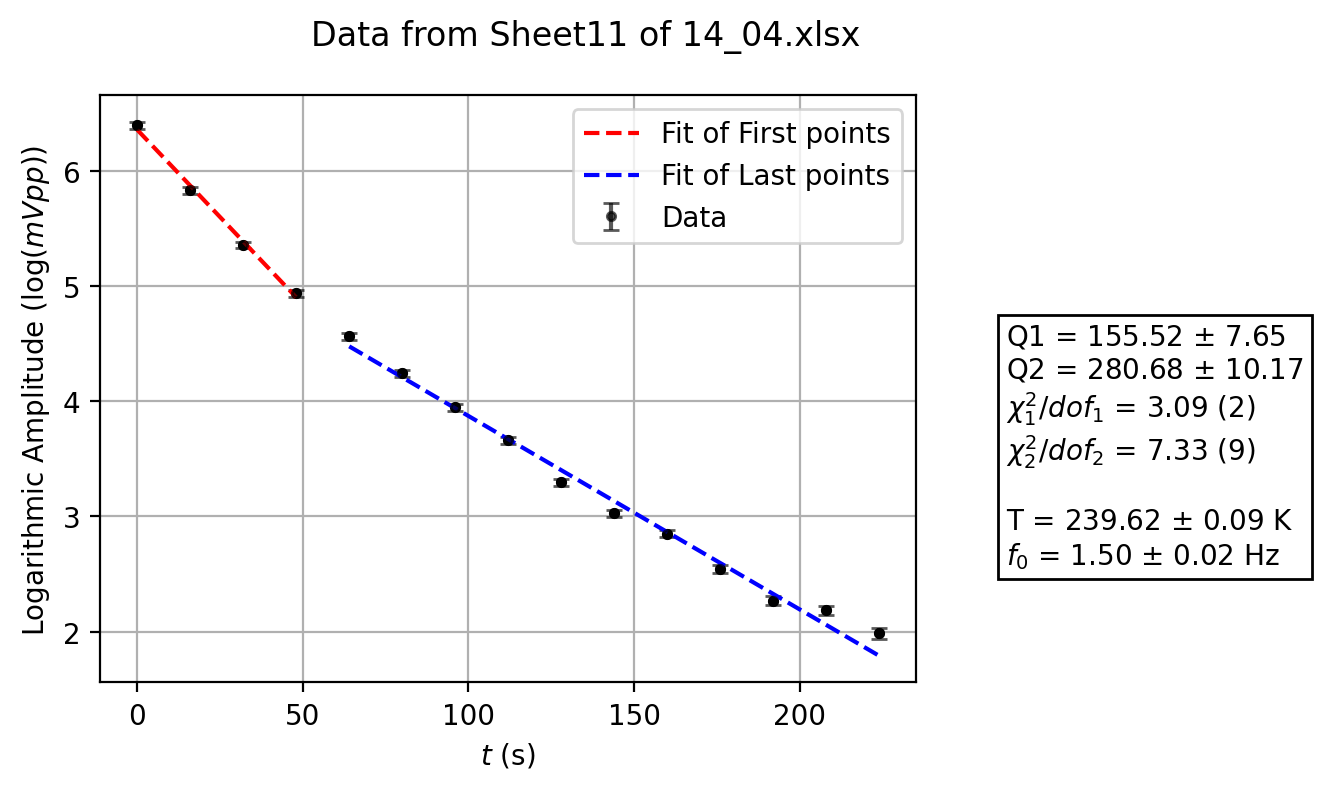

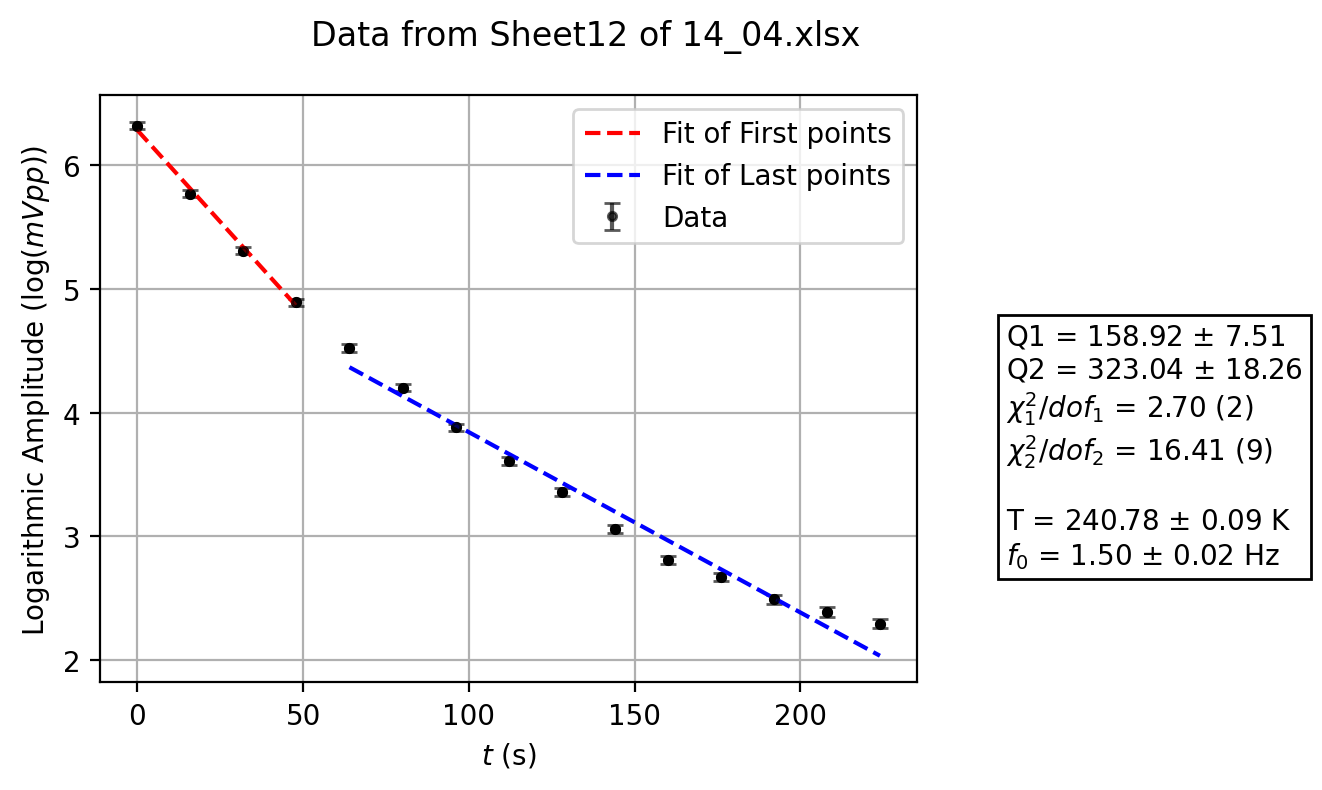

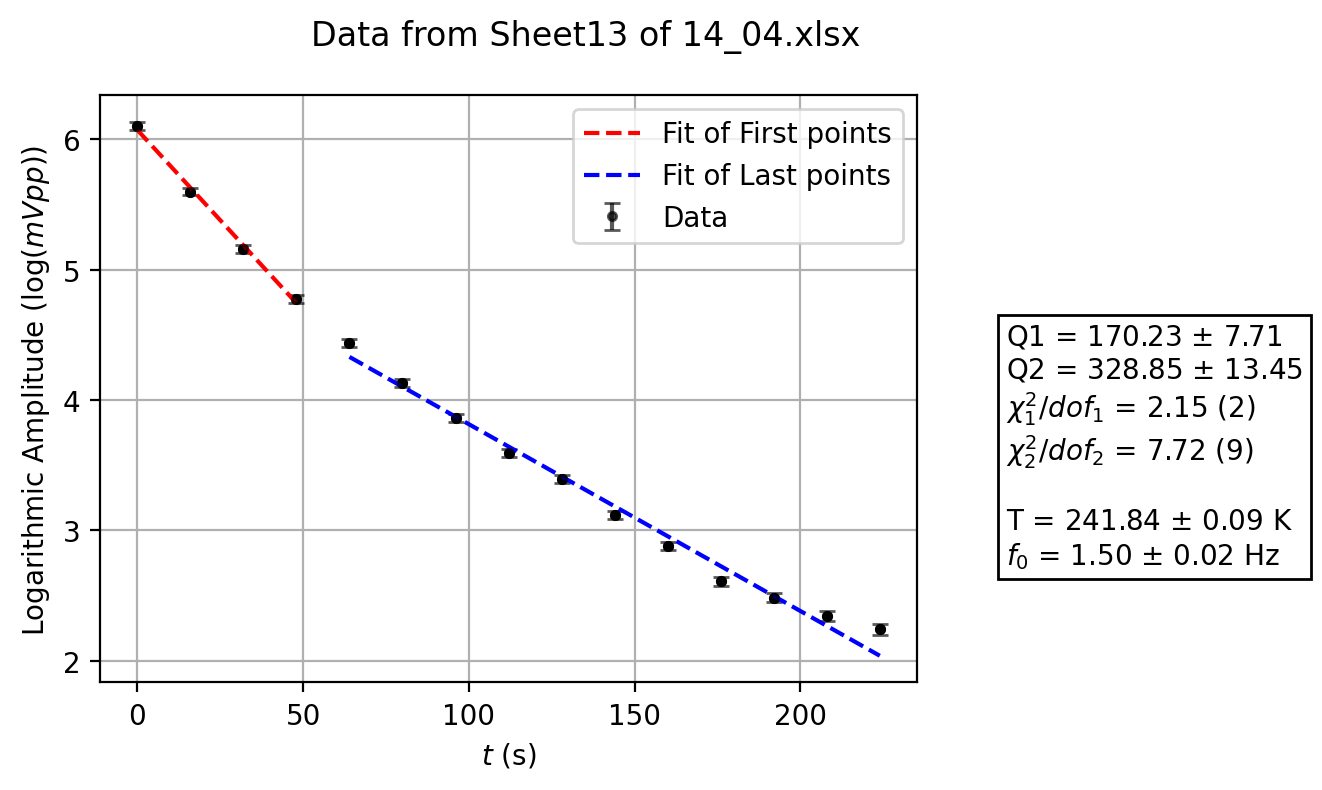

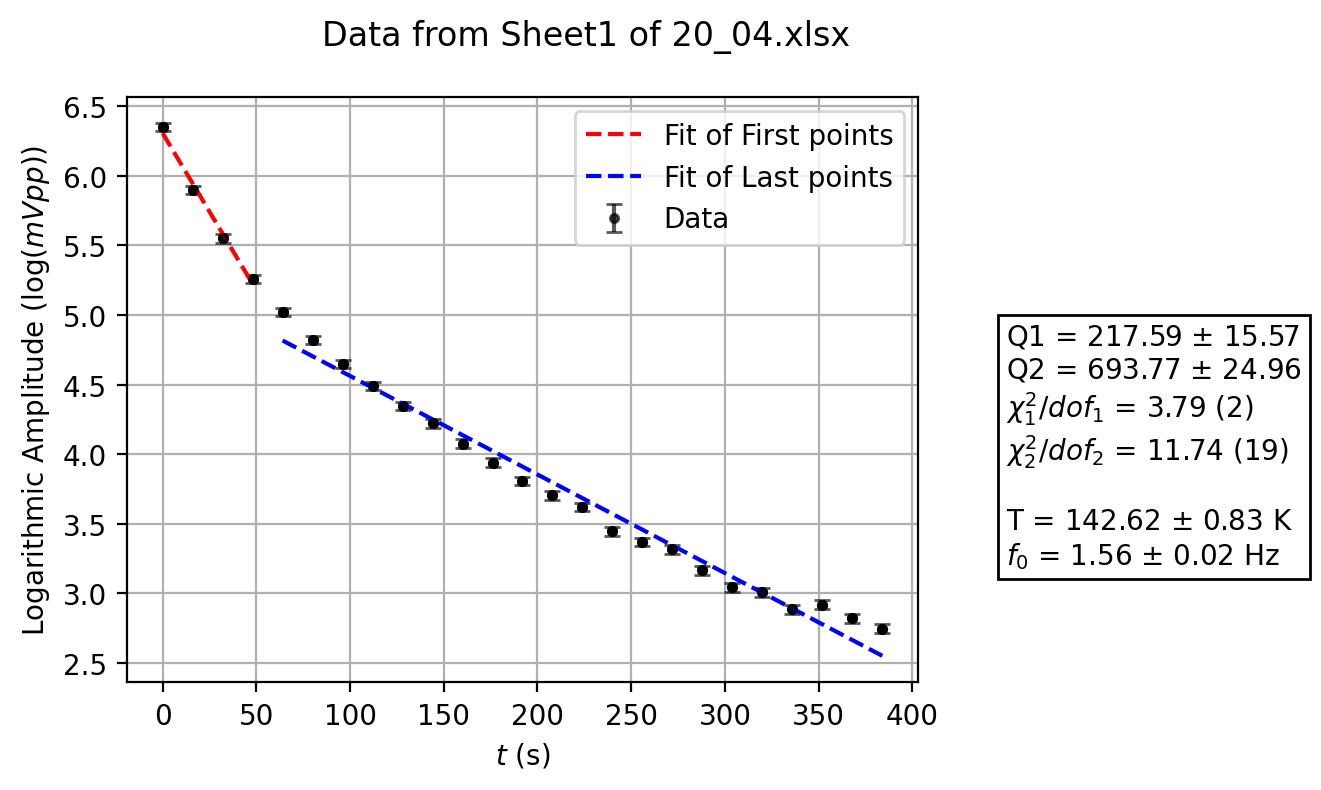

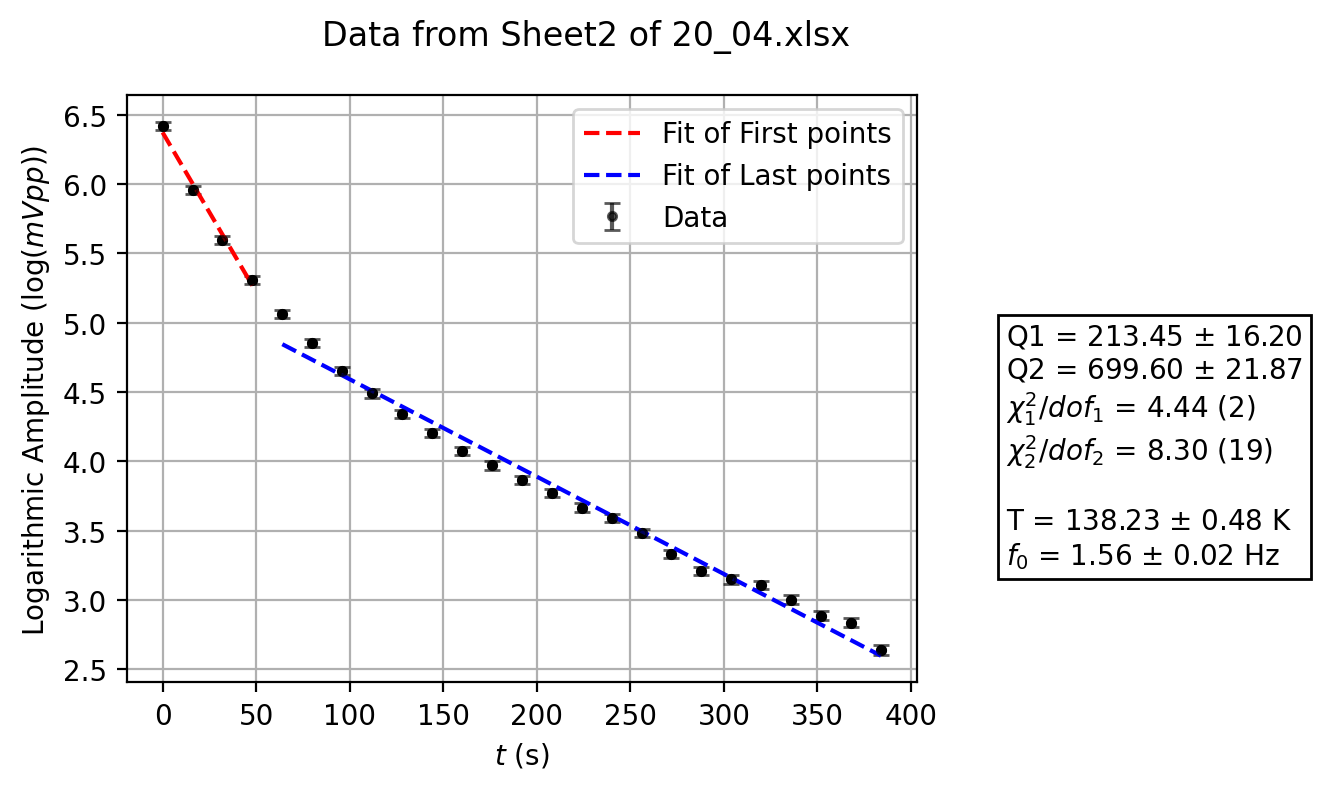

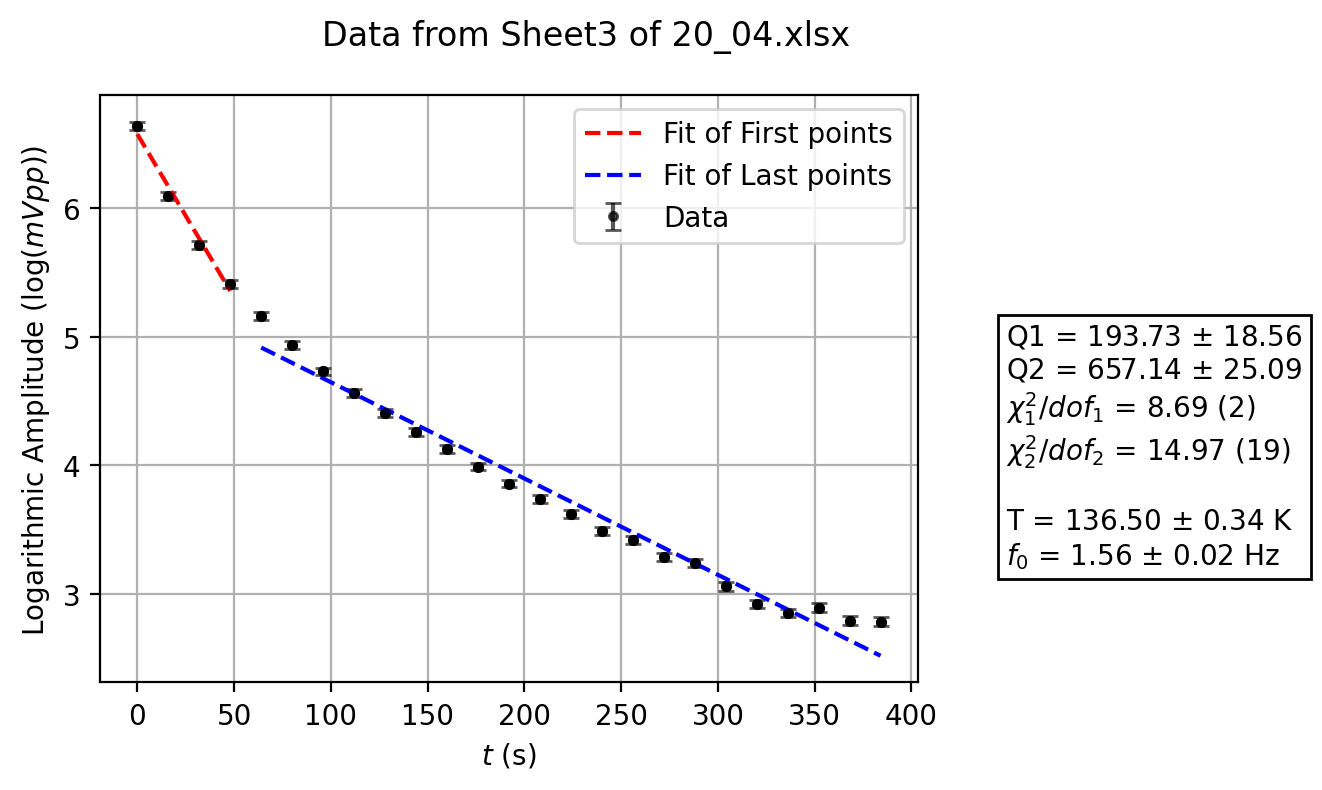

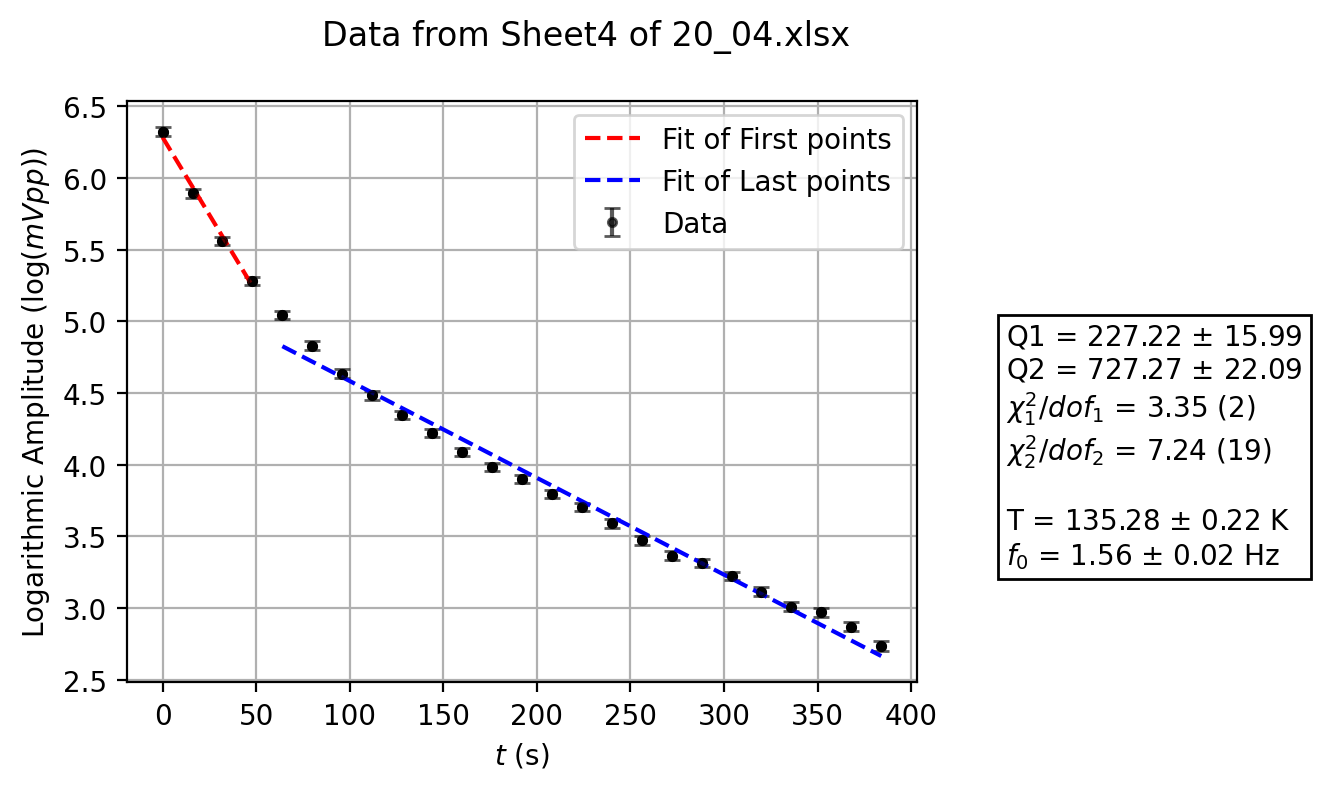

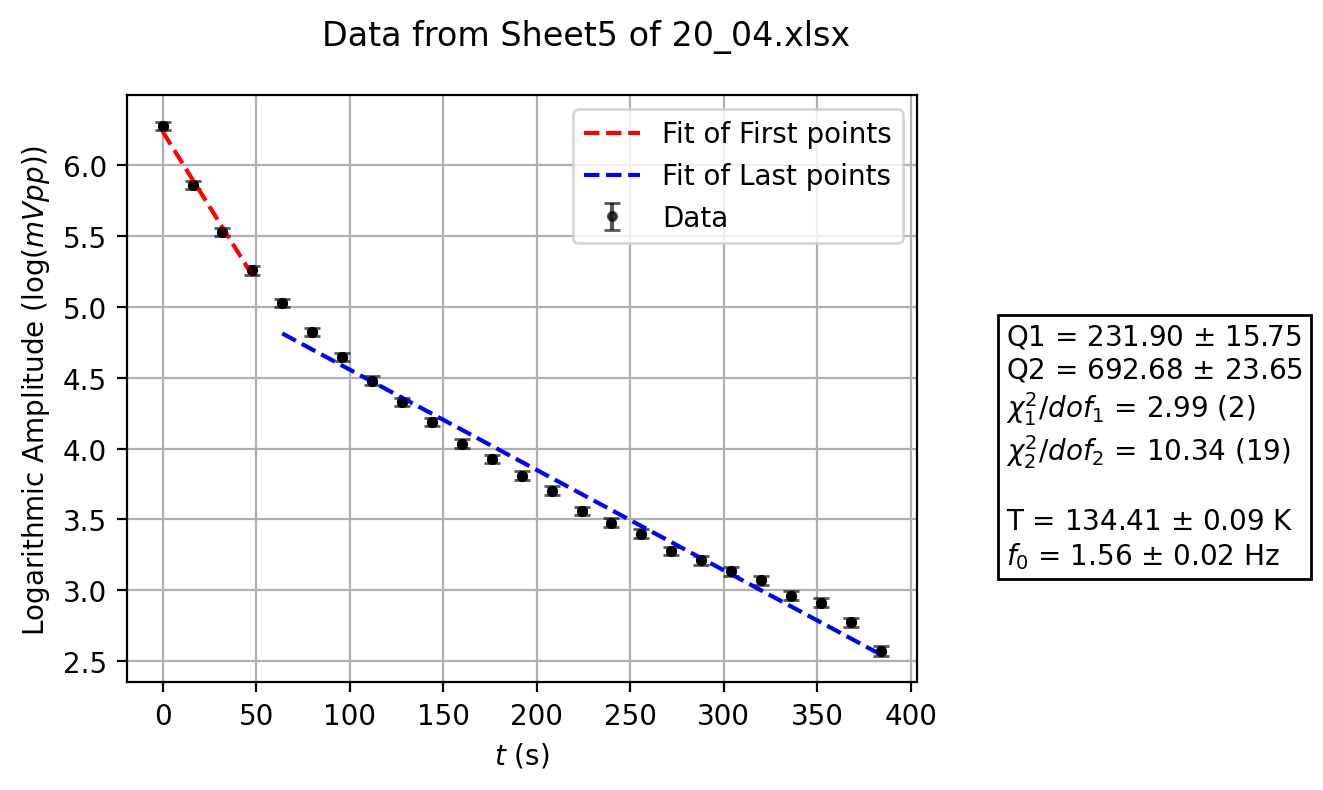

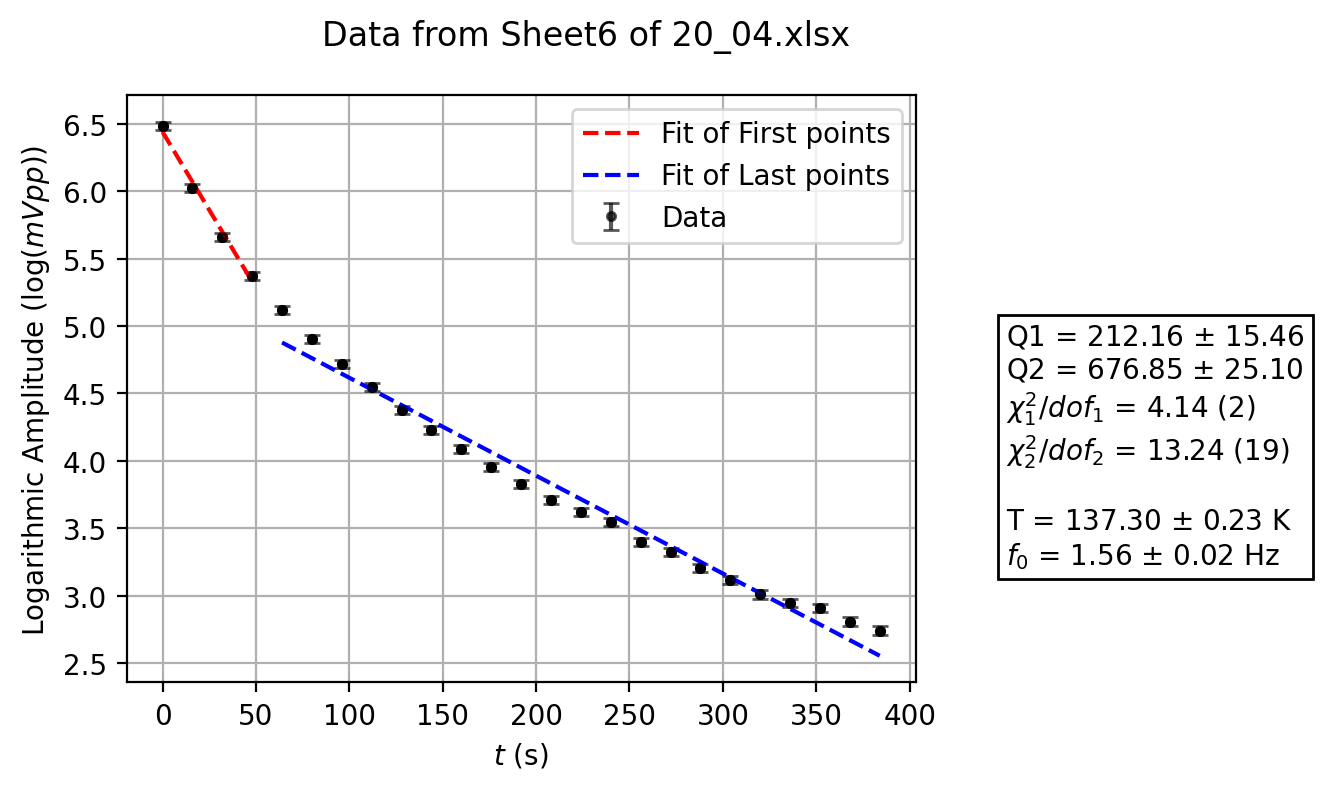

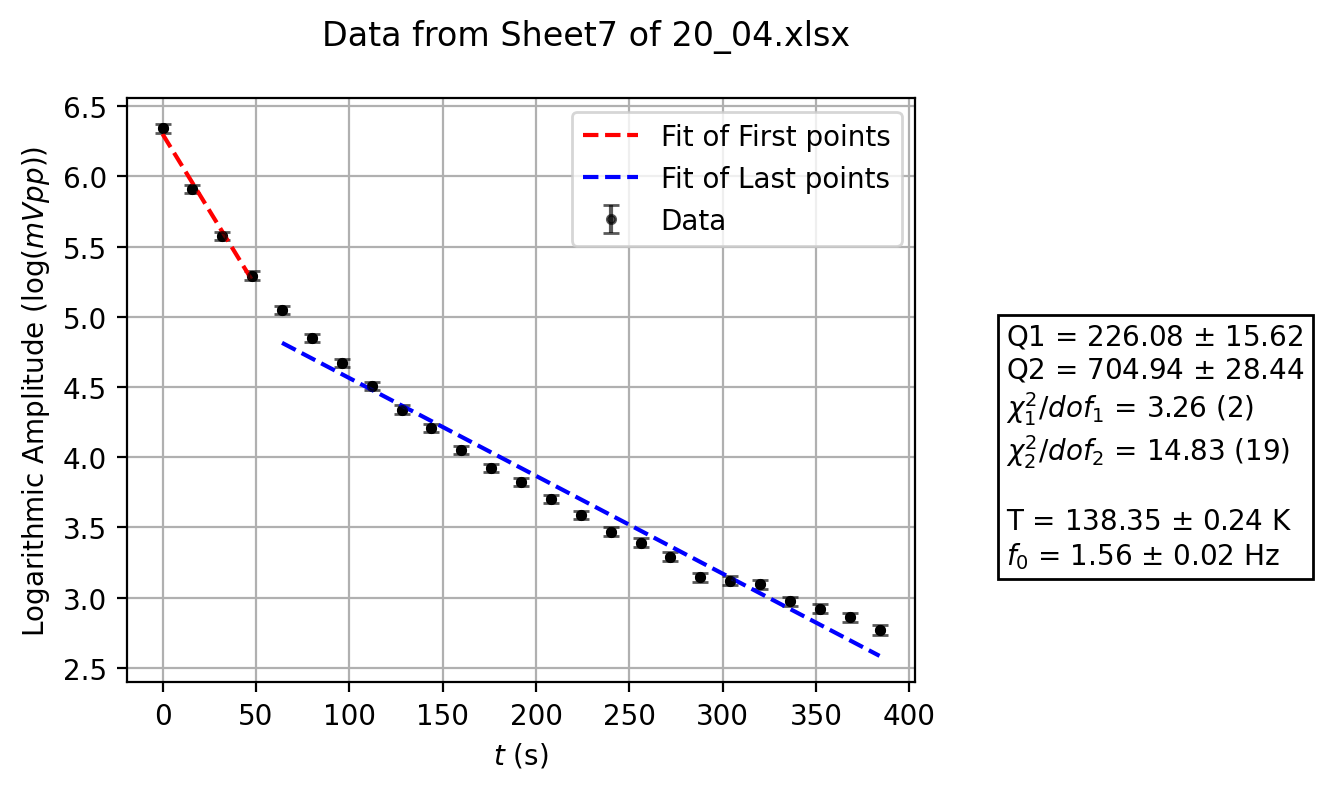

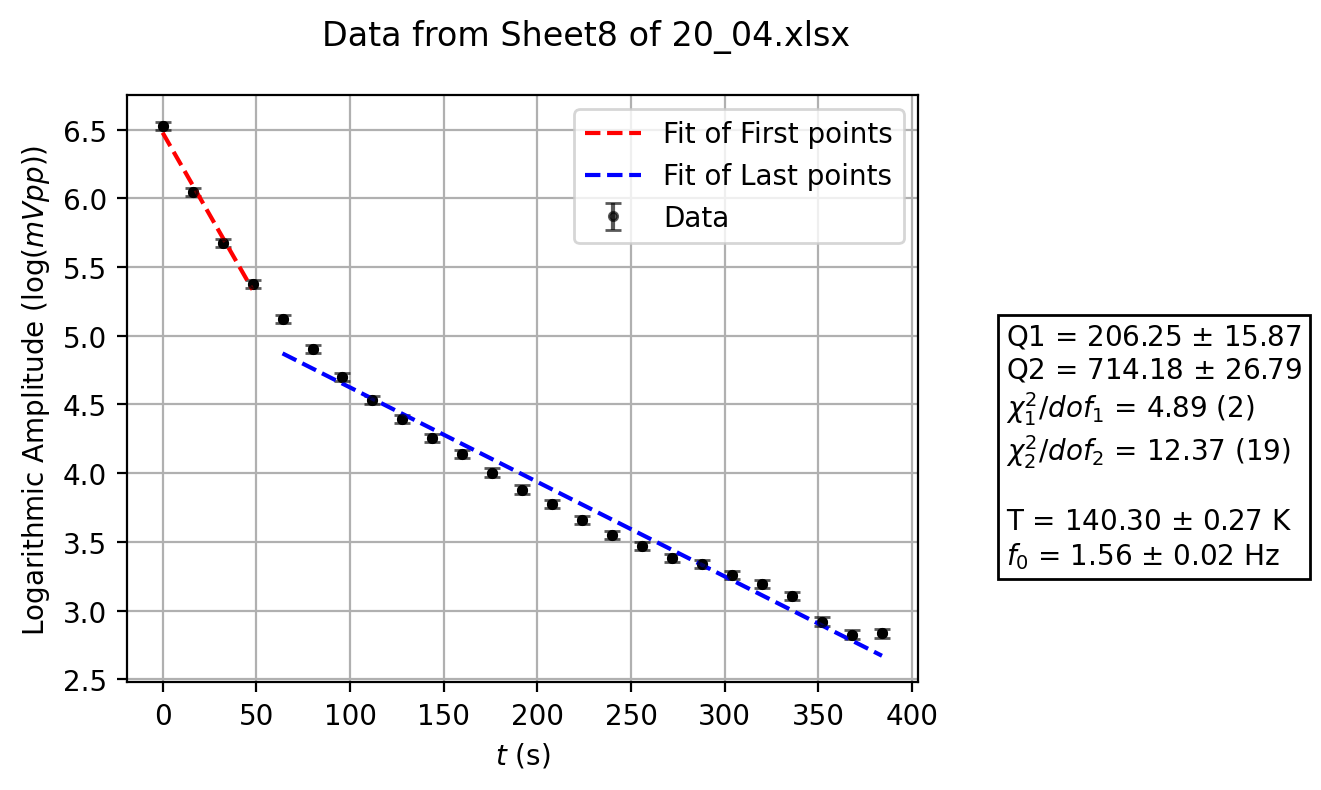

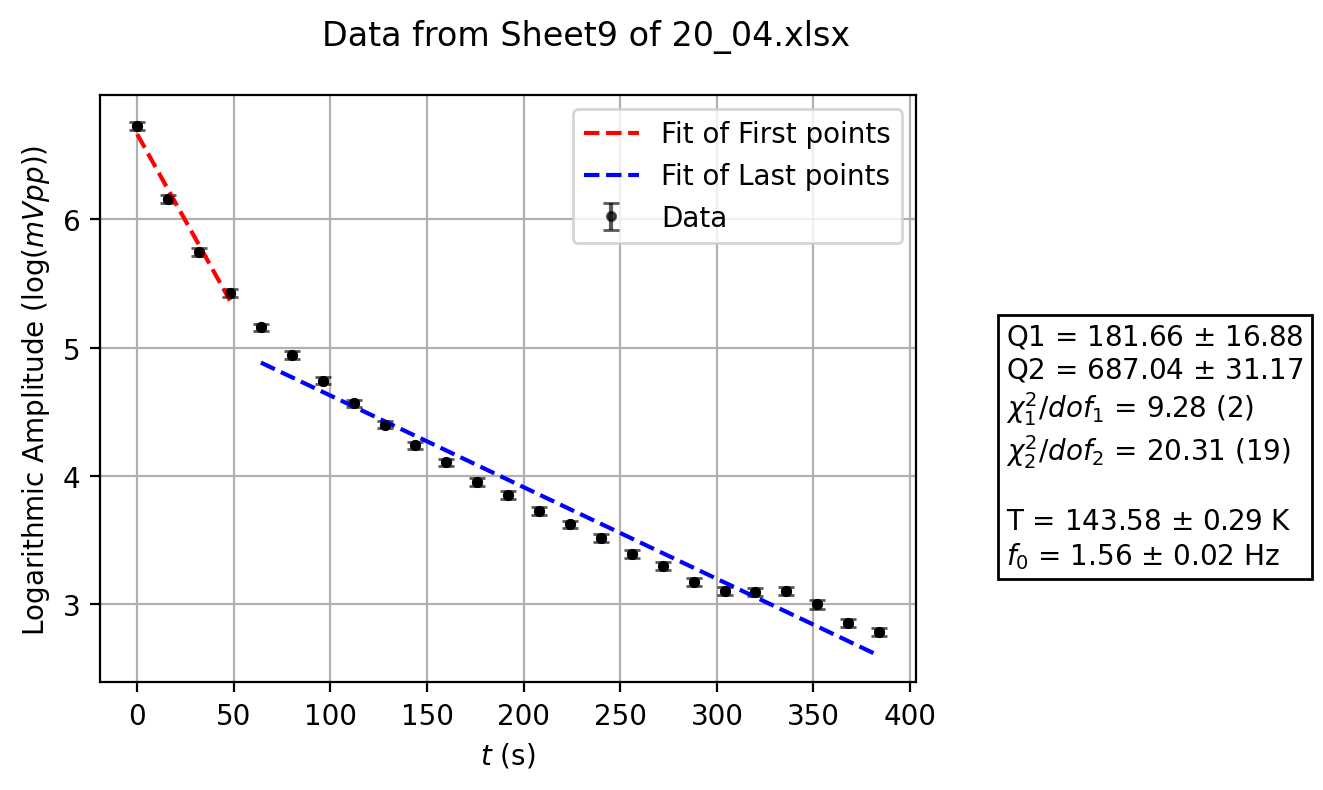

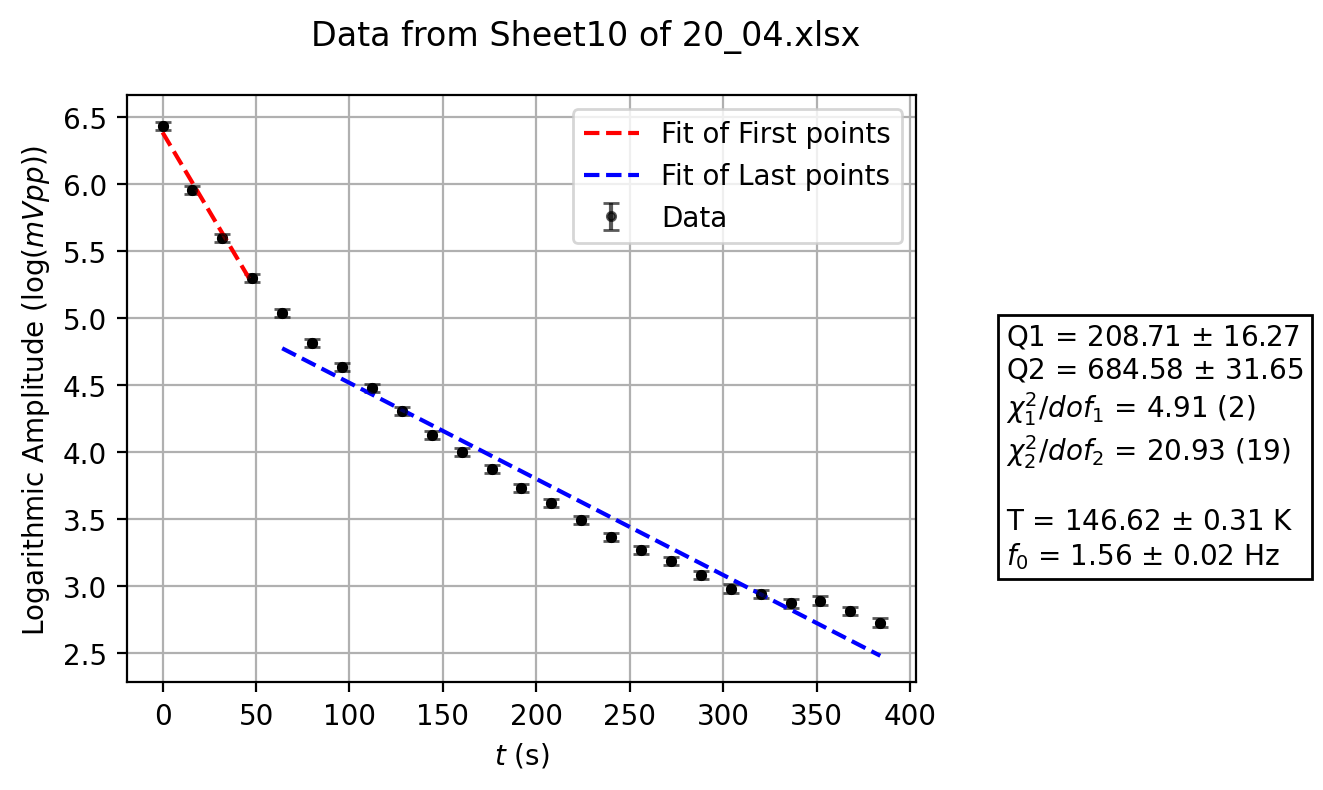

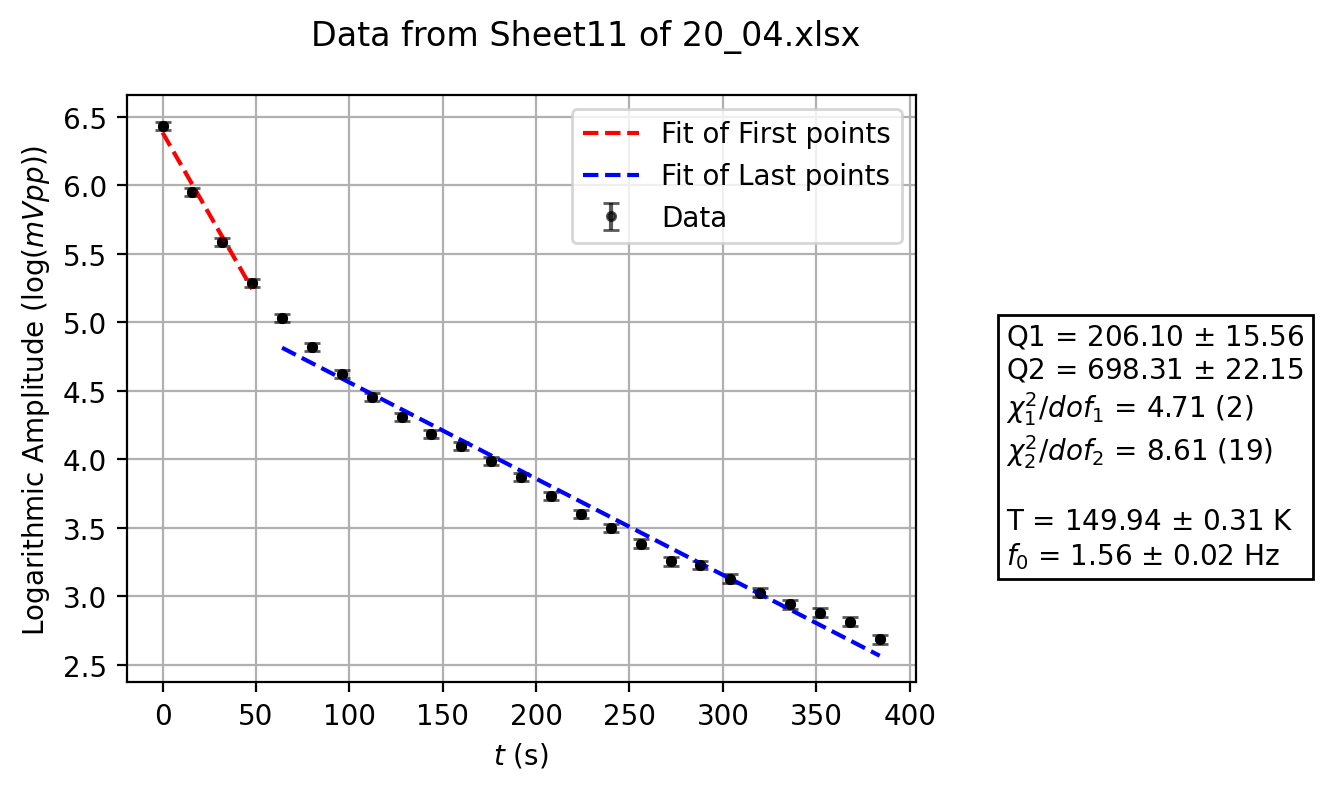

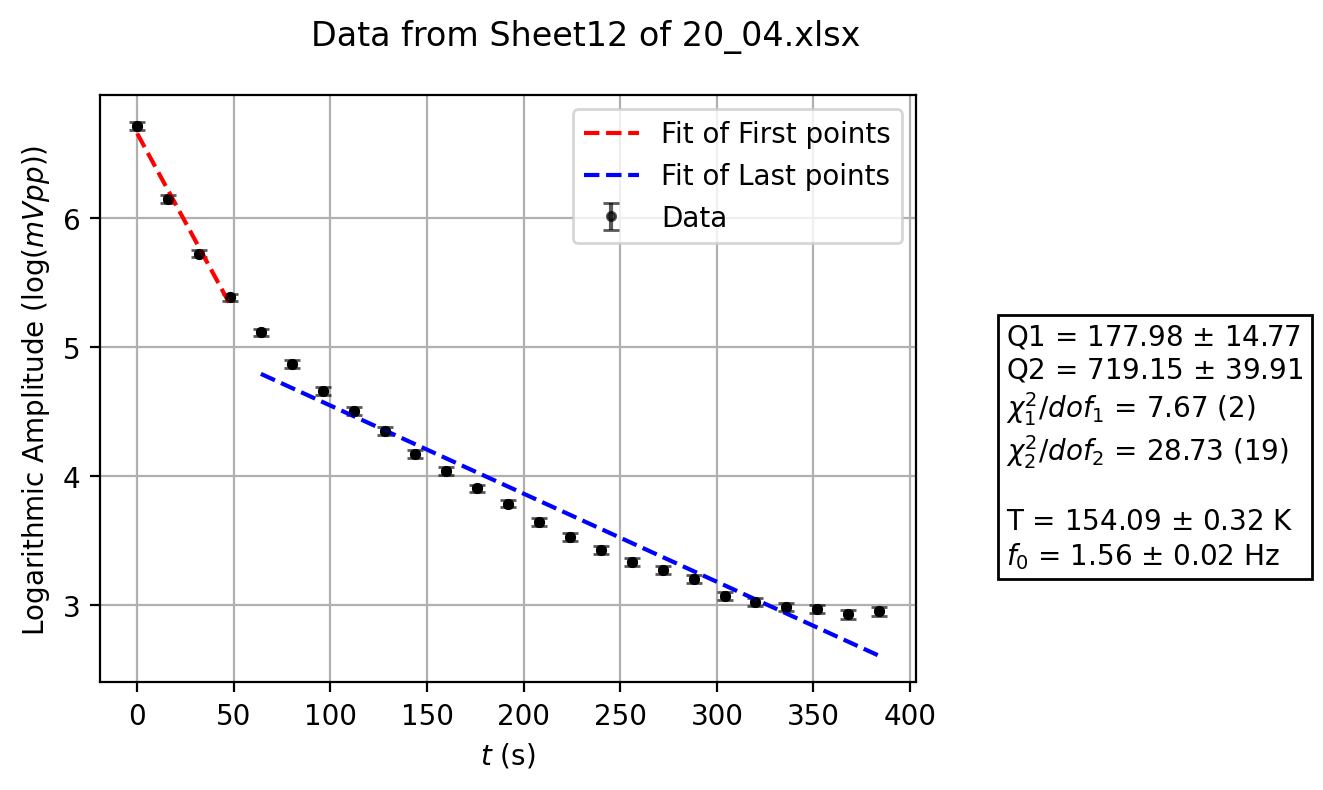

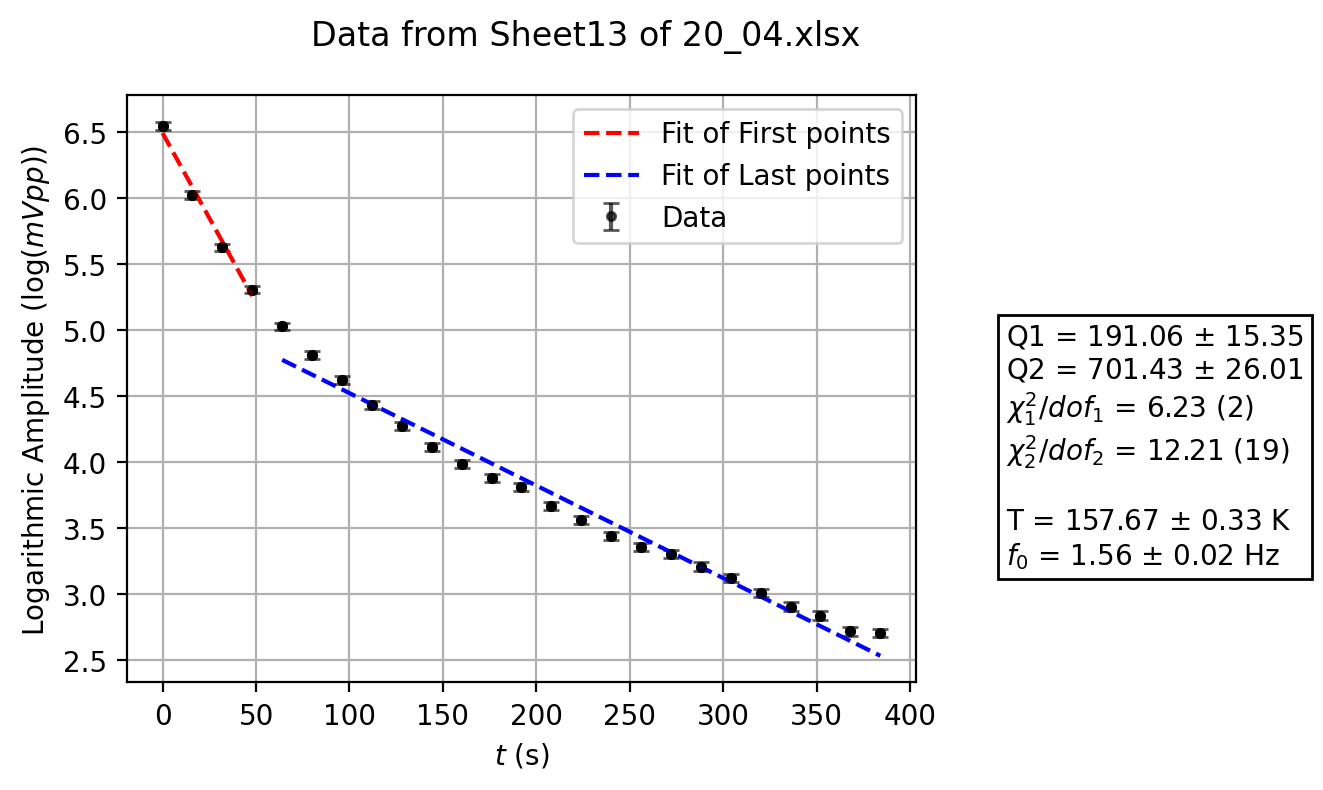

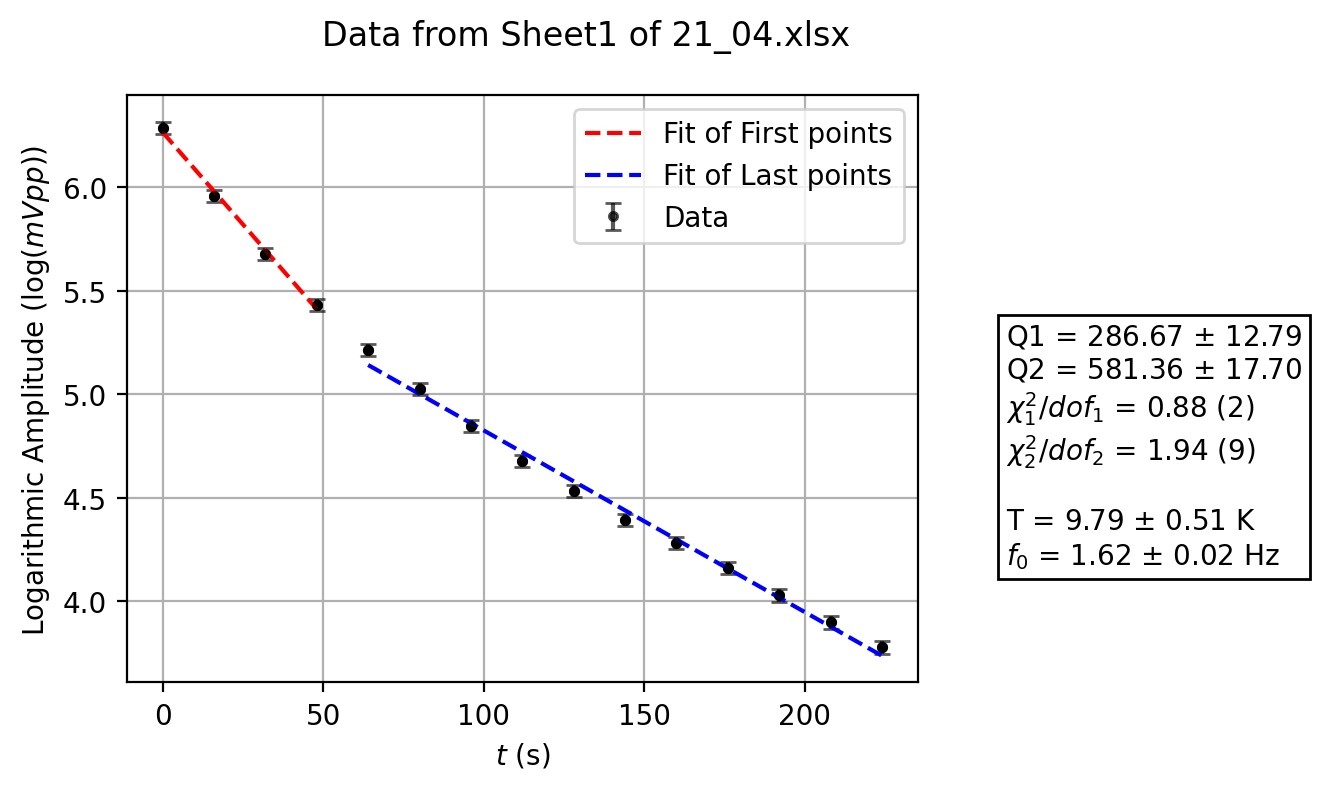

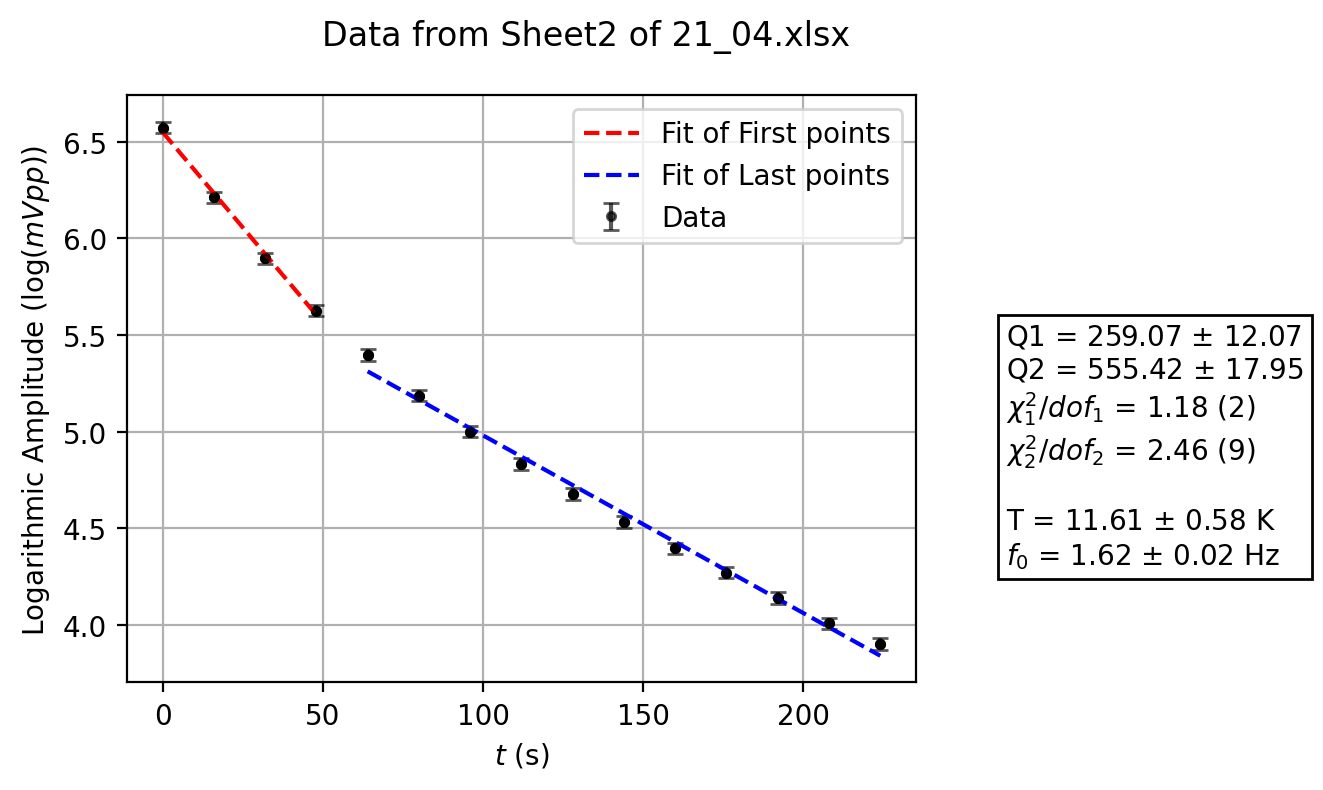

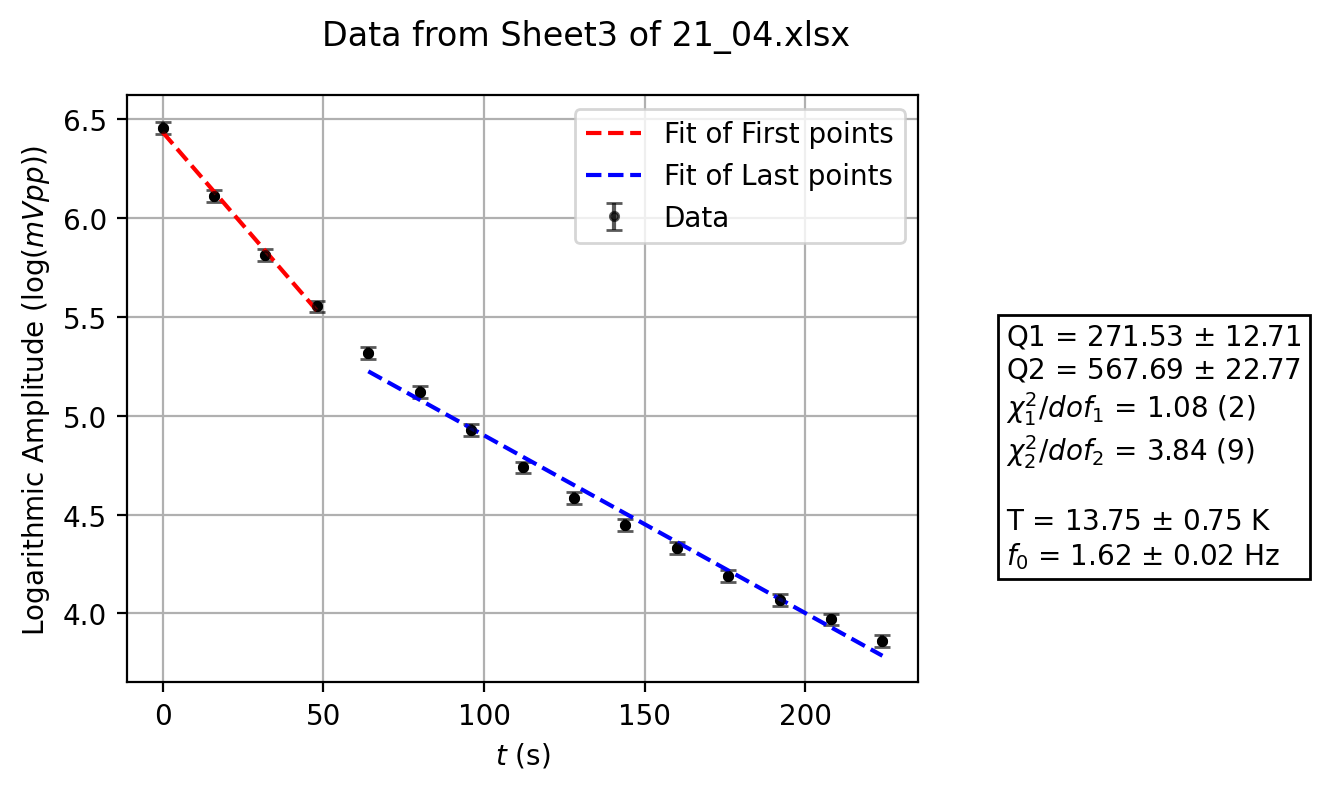

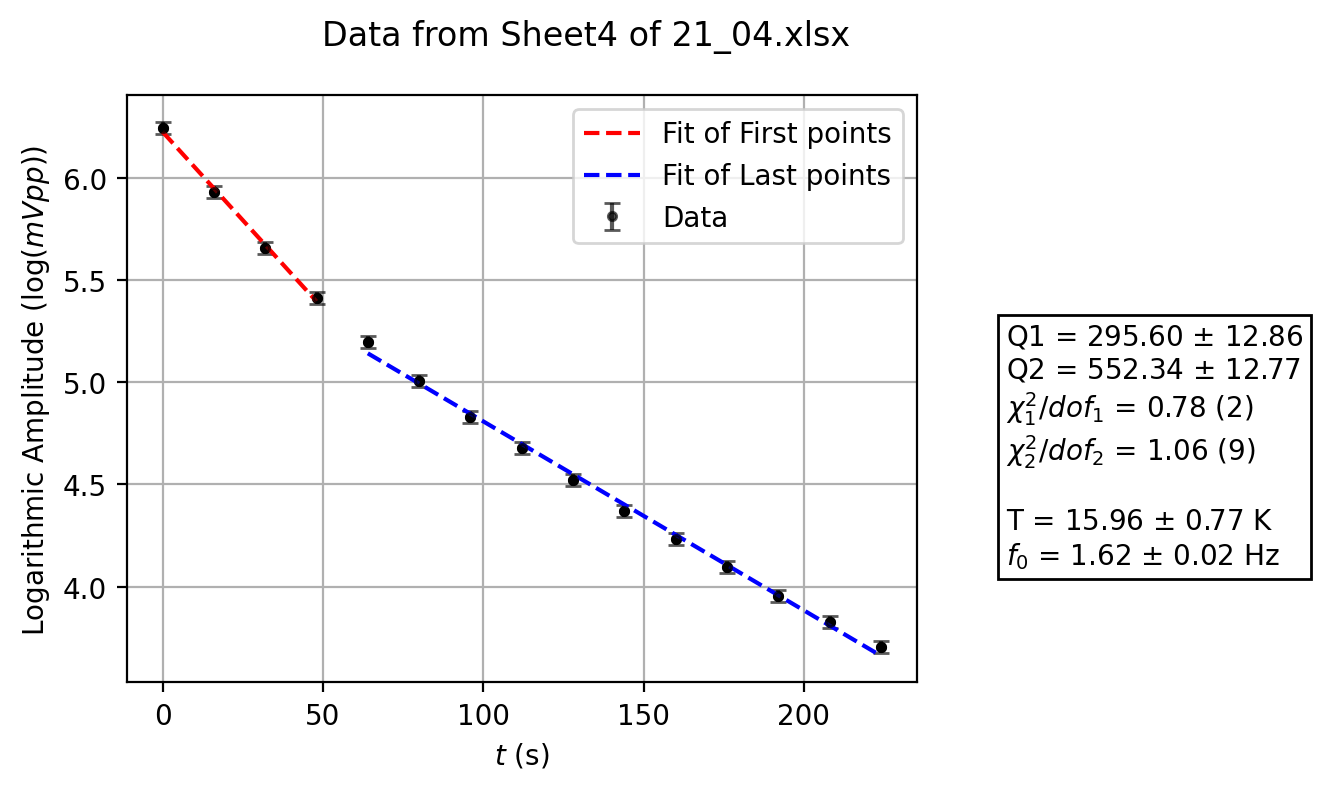

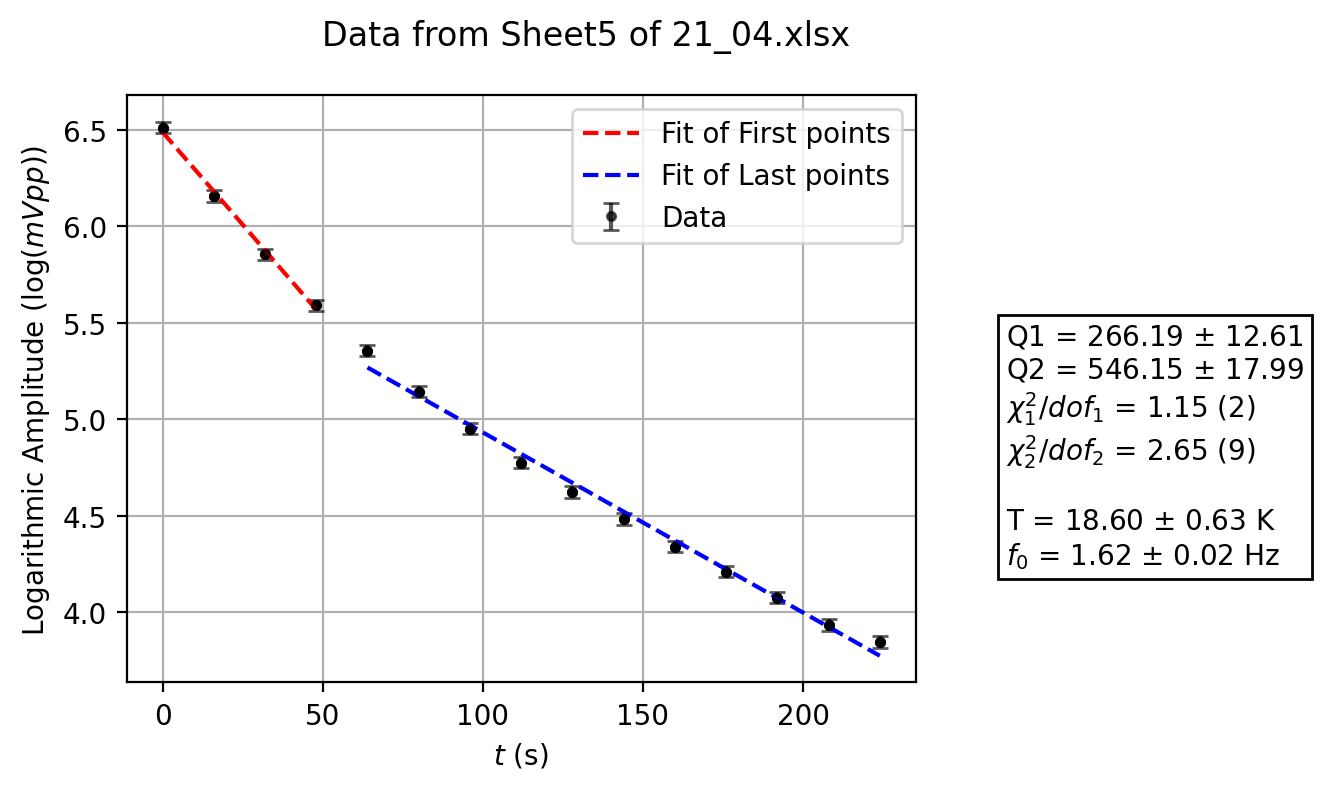

In [119]:
#This is needed to plot in floating window
#%matplotlib qt 

initial = [10, 10]

# The function fitandplot takes as input : 
# path, filename, the fitting function, the initial guess list 
# and a boolean variable if you want or not the plots
# Returns 4 arrays containing Q, T and their errors

Q1 = []
errQ1 = []
Q2 = []
errQ2 = []
T = []
errT = []
chisq1 = []
chisq2 = []

for i in range(len(files)):
    q1, errq1, q2, errq2, t, errt, chi1, chi2 = fitandplot(path, files[i] + extension, f, initial, True, False)
    Q1.extend(q1)
    errQ1.extend(errq1)
    Q2.extend(q2)
    errQ2.extend(errq2)
    T.extend(t)
    errT.extend(errt)
    chisq1.extend(chi1)
    chisq2.extend(chi2)

Q1 = np.array(Q1)
Q2 = np.array(Q2)
errQ1 = np.array(errQ1)
errQ2 = np.array(errQ2)

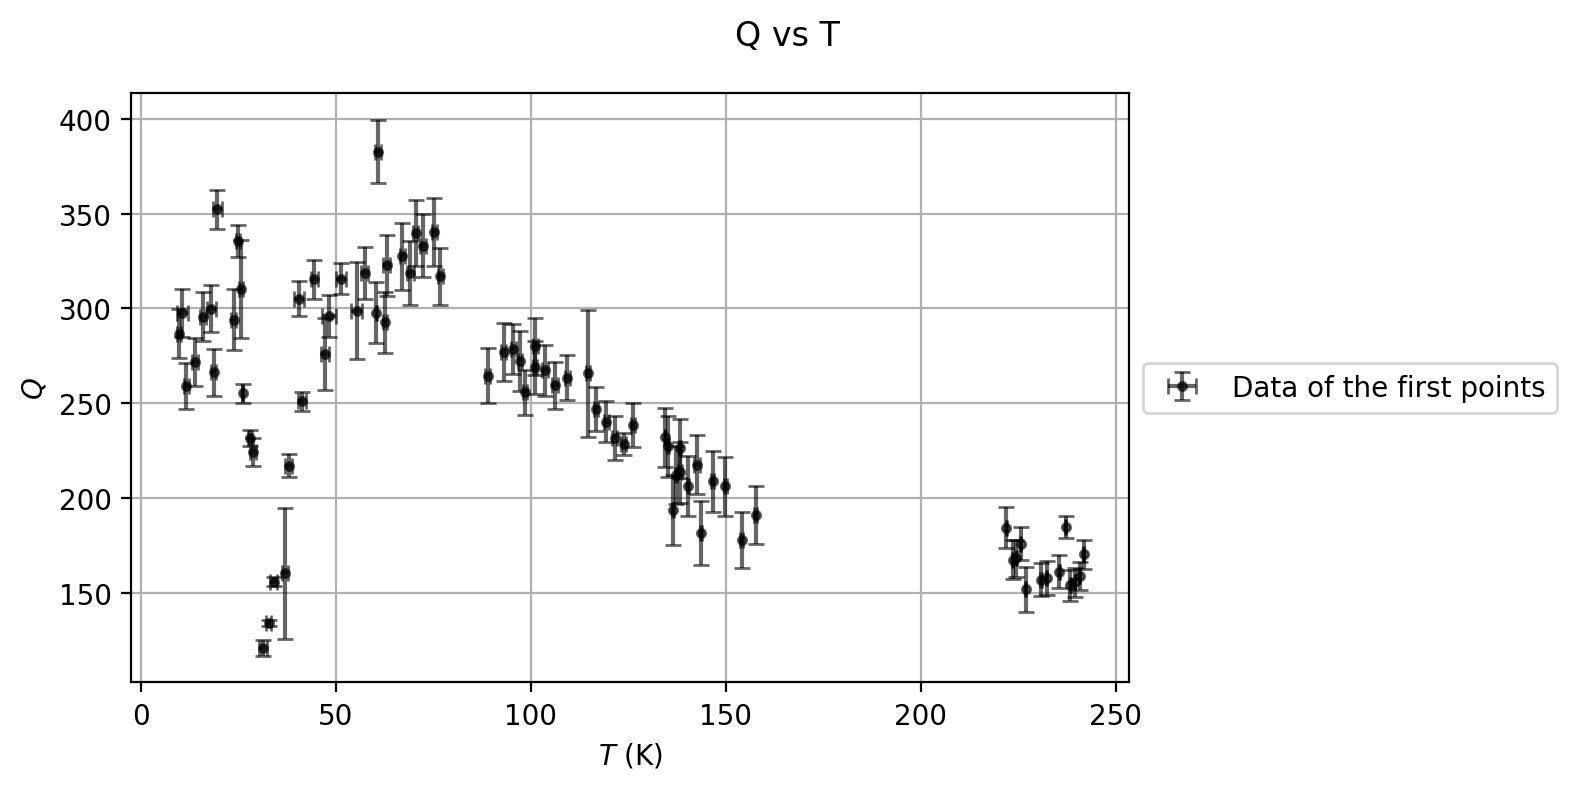

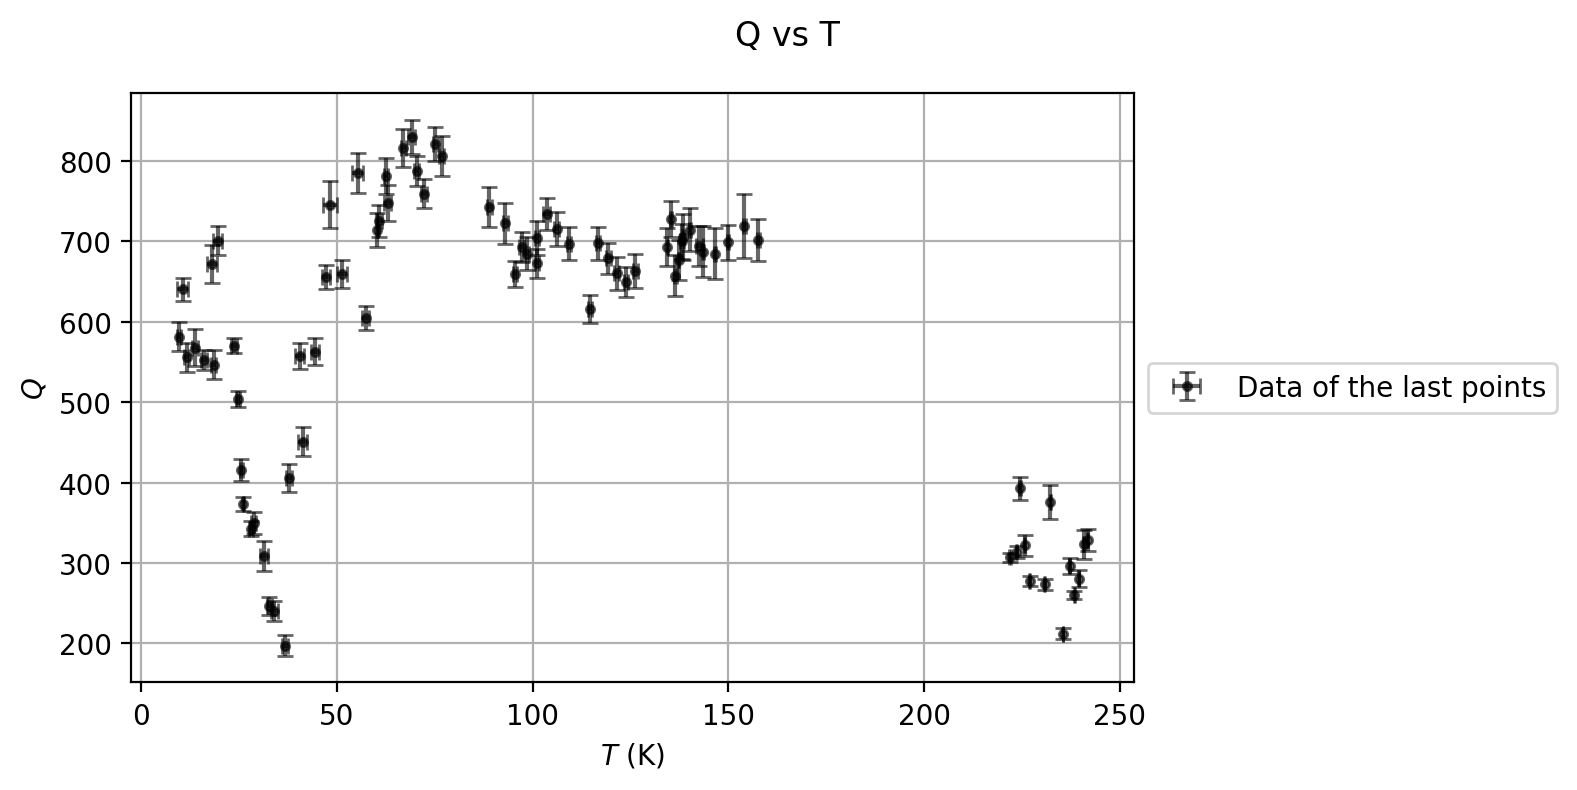

In [116]:
# We now plot the results of Q1
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(8,4), dpi=100);
fig.suptitle('Q vs T')
plt.xlabel(r"$T$ ({0})".format(T_unit), size = 10)
plt.ylabel(r"$Q$",size = 10)

plt.errorbar(T,Q1, xerr = errT, yerr = errQ1,c = 'k',fmt=".",lw = 1.5,
             alpha = 0.6, capsize=3,label="Data of the first points")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid()
plt.show()

# We now plot the results of Q2
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(8,4), dpi=100);
fig.suptitle('Q vs T')
plt.xlabel(r"$T$ ({0})".format(T_unit), size = 10)
plt.ylabel(r"$Q$",size = 10)

plt.errorbar(T,Q2, xerr = errT, yerr = errQ2, c = 'k',fmt=".",lw = 1.5,
             alpha = 0.6, capsize=3,label="Data of the last points")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid()
plt.show()

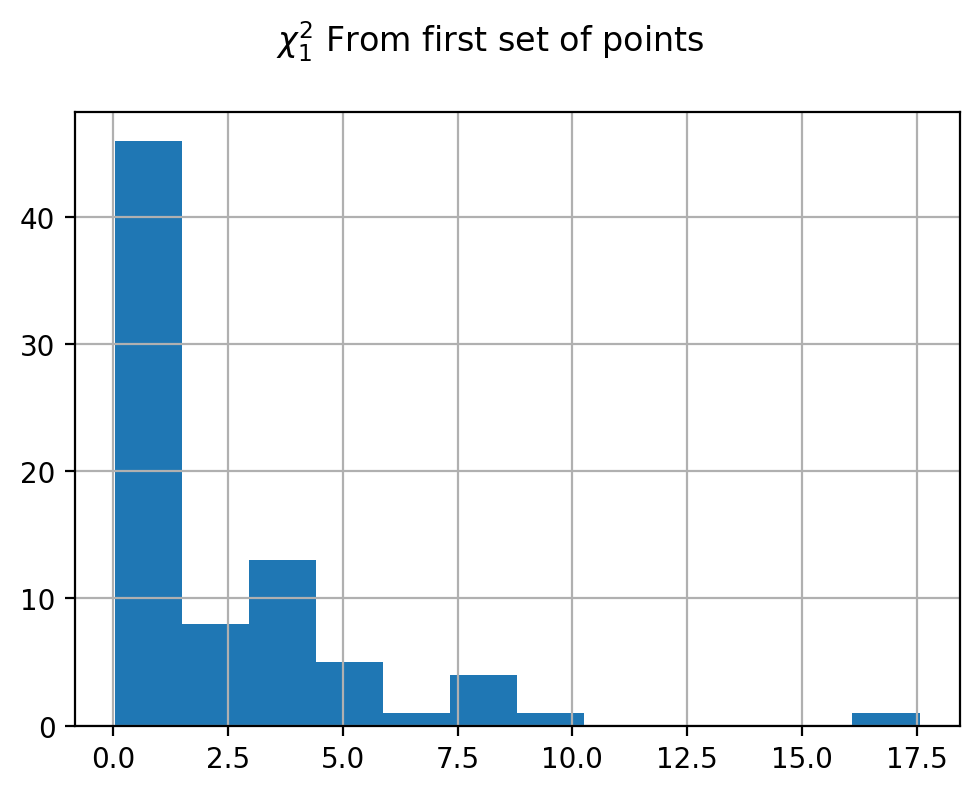

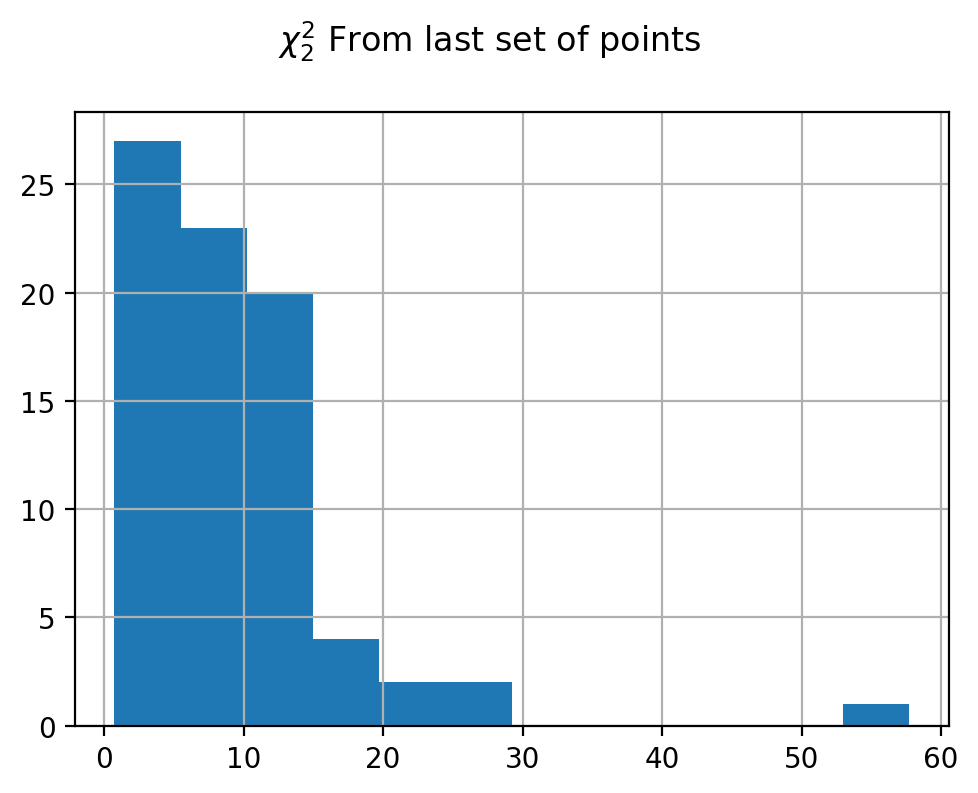

In [117]:
# We now plot the results of Q1
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(5,4), dpi=100);
fig.suptitle(r"$\chi^2_1$ From first set of points")

plt.hist(chisq1,bins = 12)
plt.tight_layout()
plt.grid()
plt.show()

# We now plot the results of Q2
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(5,4), dpi=100);
fig.suptitle(r"$\chi^2_2$ From last set of points")

plt.hist(chisq2,bins = 12)
plt.tight_layout()
plt.grid()
plt.show()

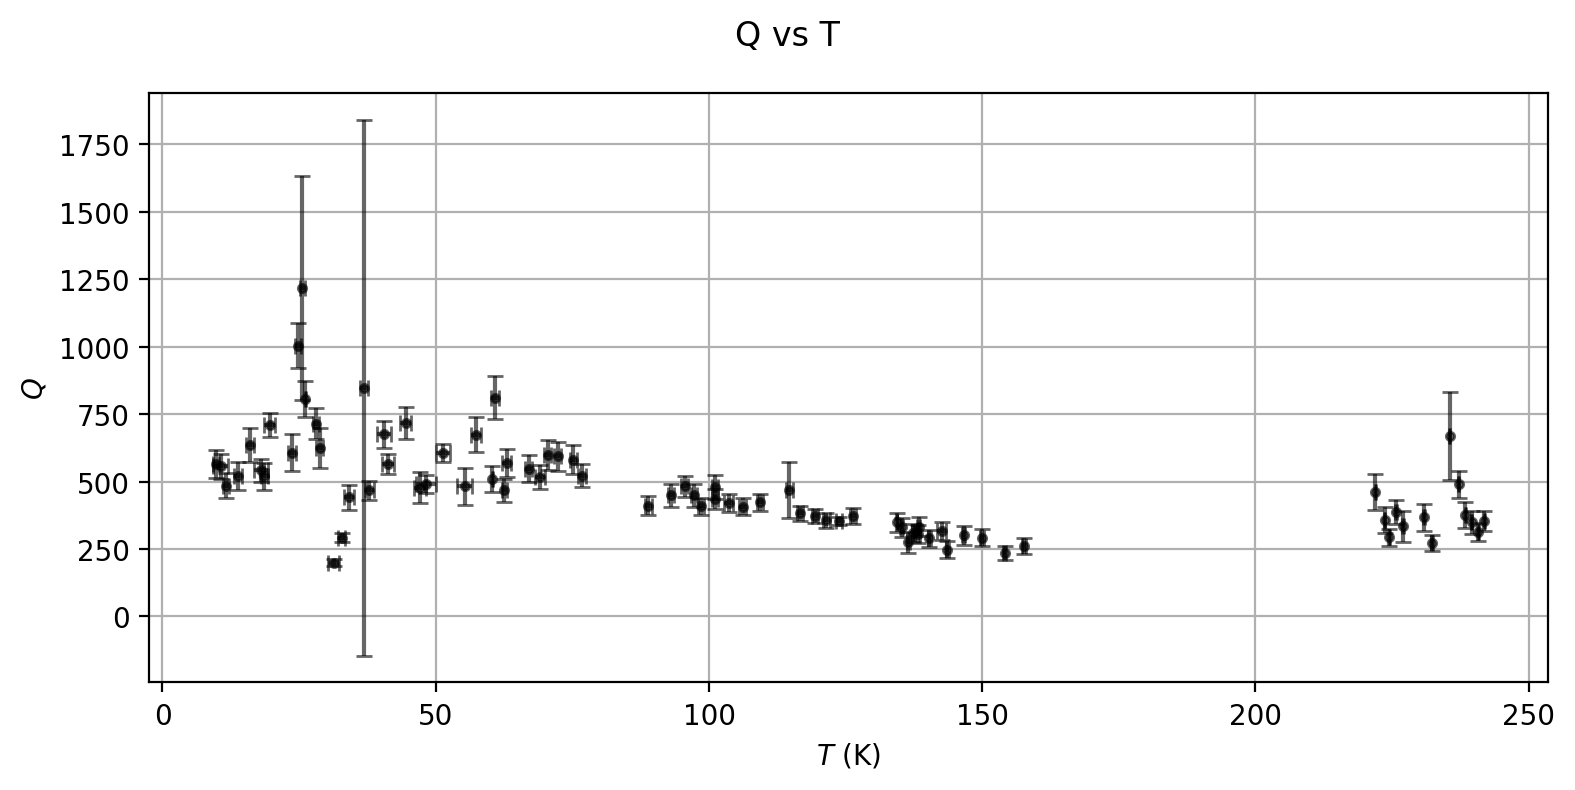

In [118]:
M = 1/(1/(Q1)-1/(Q2))
EM = np.sqrt((errQ1**2*(M**4)/(Q1**4))+(errQ2**2*(M**4)/(Q2**4)))

# We now plot the results of Q2
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(8,4), dpi=100);
fig.suptitle('Q vs T')
plt.xlabel(r"$T$ ({0})".format(T_unit), size = 10)
plt.ylabel(r"$Q$",size = 10)

plt.errorbar(T,M, xerr = errT, yerr = EM, c = 'k',fmt=".",lw = 1.5,
             alpha = 0.6, capsize=3,label="Data of the last points")


#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
EM